**Lab2-DL: B3-hjertesykdom-klassifikasjon.ipynb** (ELMED219) | Prioritet: 1 (kjerne)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arvidl/ELMED219-2026/blob/main/Lab2-DL/notebooks/B3-hjertesykdom-klassifikasjon.ipynb)

# 🎓 B3: Klassifikasjon av UCI Heart Disease dataset


**Fra Biologi til Kunstig Intelligens: Hvordan Nevrale Nettverk kan brukes for sykdomsklassifikasjon basert på symptomer og tegn**

---

## 🎯 Mål for denne delen

I denne notebooken skal vi utføre:

1. **Nedlasting og preprosessering** av reelle UCI Heart Disease data
2. **Eksplorativ dataanalyse** med visualiseringer
3. **Forbedret nevralt nettverk** med batch normalization og dropout
4. **Detaljert trening** med adaptive læringsrate
5. **Omfattende evaluering** med forvirringsmatrise, ROC-kurve og ytelses-metrikker
6. **Feature importance analyse** for å forstå hvilke faktorer som er viktigst i klassifiseringen
7. **Klinisk tolkning** og praktiske anbefalinger

---

In [1]:
# Importer nødvendige biblioteker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Sett opp plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🎓 Klar for læring i nevrale nettverk!")
print(f"Scikit-learn versjon: {sklearn.__version__}")
print(f"PyTorch versjon: {torch.__version__}")
print(f"CUDA tilgjengelig: {torch.cuda.is_available()}")
print(f"MPS tilgjengelig: {torch.backends.mps.is_available()}")


🎓 Klar for læring i nevrale nettverk!
Scikit-learn versjon: 1.7.2
PyTorch versjon: 2.5.1+cu121
CUDA tilgjengelig: True
MPS tilgjengelig: False


In [2]:
# Sjekk om vi kjører i Colab
def running_in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

print(f"Kjører i Colab: {running_in_colab()}")

Kjører i Colab: False


----

## Hjerte-kar-sykdom Prediksjon

### Problem: Klassifikasjon av hjerte-kar-sykdom

Vi skal nå bruke **medisinske data** fra UCI Heart Disease Dataset for å bygge et nevralt nettverk som predikerer hjerte-kar-sykdom basert på kliniske faktorer.

### Datasett: UCI Heart Disease Dataset

**Hvorfor dette datasettet:**
- ✅ **Ekte medisinske data** (ikke syntetisk)
- ✅ **Tabulære data** (perfekt for vårt eksempel)
- ✅ **Hjerte-kar-sykdom** fokus
- ✅ **Små nok** for å lære på
- ✅ **Velkjent** i ML-samfunnet
- ✅ **Gratis** og offentlig tilgjengelig

**Features (13 kliniske faktorer):**
1. **Alder** (age)
2. **Kjønn** (sex) - 1=male, 0=female
3. **Smerte type** (cp) - 0-3 (chest pain type)
4. **Blodtrykk** (trestbps) - resting blood pressure
5. **Kolesterol** (chol) - serum cholesterol
6. **Blodsukker** (fbs) - fasting blood sugar > 120 mg/dl
7. **EKG-resultater** (restecg) - resting electrocardiographic results
8. **Maksimal hjertefrekvens** (thalach) - maximum heart rate achieved
9. **Angina** (exang) - exercise induced angina
10. **ST-depresjon** (oldpeak) - ST depression induced by exercise
11. **ST-hældning** (slope) - slope of peak exercise ST segment
12. **Hovedblodårer** (ca) - number of major vessels colored by fluoroscopy
13. **Thalassemia** (thal) - thalassemia type

**Target: Hjerte-kar-sykdom (0-4)**
- **0**: Ingen sykdom
- **1-4**: Forskjellige grader av hjerte-kar-sykdom



In [3]:
# Last ned UCI Heart Disease Dataset
def load_uci_heart_data():
    """Last ned og forbered UCI Heart Disease dataset"""
    
    print("📥 Laster ned UCI Heart Disease dataset...")

        
    # Last ned fra UCI direkte
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
    column_names = [
            'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
            'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
    ]
        
    df = pd.read_csv(url, names=column_names, na_values='?')
    print(f"✅ Datasett lastet fra UCI direkte!")
    print(f"   Størrelse: {df.shape} (kan være missing values)")
        
    return df

# Last ned datasettet
df1 = load_uci_heart_data()

# Behold kun records uten missing values
df = df1.dropna()

# Reindekser datasettet
df = df.reset_index(drop=True)

# Separer features og target
X = df.drop('target', axis=1)
y = ['target']

print(f"\n📈 Datasett informasjon:")
print(df.info())

print(f"\n🎯 Target fordeling:")
print(df['target'].value_counts().sort_index())

# Vis første rader
print(f"\n📊 Første 5 og siste 5 rader:")
df

📥 Laster ned UCI Heart Disease dataset...
✅ Datasett lastet fra UCI direkte!
   Størrelse: (303, 14) (kan være missing values)

📈 Datasett informasjon:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    float64
 1   sex       297 non-null    float64
 2   cp        297 non-null    float64
 3   trestbps  297 non-null    float64
 4   chol      297 non-null    float64
 5   fbs       297 non-null    float64
 6   restecg   297 non-null    float64
 7   thalach   297 non-null    float64
 8   exang     297 non-null    float64
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    float64
 11  ca        297 non-null    float64
 12  thal      297 non-null    float64
 13  target    297 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 32.6 KB
None

🎯 Target fordeling:
target
0    160
1     54
2     35
3     3

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1
293,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
294,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
295,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3


#### Eksplorative visualisering:

**Fargekodet scatter plots** hvor hver alvorlighetsgrad (0, 1-4) har sin egen farge<br>
**Detaljert fordeling** av alvorlighetsgrader med både bar chart og pie chart


**Fargekoding:**
- 🔵 **Blå (0)**: Ingen sykdom
- 🟢 **Grønn (1)**: Grad 1 (mild)
- 🟠 **Oransje (2)**: Grad 2 (moderat)
- 🔴 **Rød (3)**: Grad 3 (alvorlig)
- 🟤 **Mørk rød (4)**: Grad 4 (meget alvorlig)

Dette vil gi en informativ og klinisk relevant visualisering av dataene

In [4]:
# Visualisering med enheter i alle labels
def create_enhanced_heart_disease_visualization_with_units(df, X, feature_names):
    """Opprett visualisering med separate farger for alvorlighetsgrader og enheter"""
    
    print("🎨 === VISUALISERING MED ALVORLIGHETSGRADER ===")
    print("📚 === DETALJERTE VARIABEL-FORKLARINGER MED ENHETER ===")
    
    # Få original target (0-4) fra datasettet
    y_original = df['target'].values
    
    # Konverter X til numpy array hvis det er pandas DataFrame
    if hasattr(X, 'values'):
        X_array = X.values
    else:
        X_array = X
    
    # Definer farger for hver alvorlighetsgrad
    colors = {
        0: 'lightblue',      # Ingen sykdom
        1: 'lightgreen',     # Grad 1 (mild)
        2: 'orange',         # Grad 2 (moderat)
        3: 'red',            # Grad 3 (alvorlig)
        4: 'darkred'         # Grad 4 (meget alvorlig)
    }
    
    # Definer labels
    labels = {
        0: 'Ingen sykdom',
        1: 'Grad 1 (mild)',
        2: 'Grad 2 (moderat)', 
        3: 'Grad 3 (alvorlig)',
        4: 'Grad 4 (meget alvorlig)'
    }
    
    # Detaljerte variabel-forklaringer med enheter
    variable_descriptions = {
        'age': {
            'name': 'Alder',
            'unit': 'år',
            'description': 'Pasientens alder',
            'range': '29-77 år',
            'clinical_importance': 'Høyere alder øker risiko for hjerte-kar-sykdom'
        },
        'sex': {
            'name': 'Kjønn',
            'unit': '',
            'description': 'Pasientens kjønn',
            'values': '0 = Kvinne, 1 = Mann',
            'clinical_importance': 'Menn har høyere risiko for hjerte-kar-sykdom'
        },
        'cp': {
            'name': 'Brystsmerte Type',
            'unit': '',
            'description': 'Type brystsmerte opplevd av pasienten',
            'values': '0 = Typisk angina, 1 = Atypisk angina, 2 = Ikke-angina smerte, 3 = Asymptomatisk',
            'clinical_importance': 'Spesifikke smerte-typer kan indikere hjerteproblemer'
        },
        'trestbps': {
            'name': 'Hvile-Blodtrykk',
            'unit': 'mmHg',
            'description': 'Systolisk blodtrykk i hvile',
            'range': '94-200 mmHg',
            'clinical_importance': 'Høyt blodtrykk er en hovedrisikofaktor for hjerte-kar-sykdom'
        },
        'chol': {
            'name': 'Serum Kolesterol',
            'unit': 'mg/dl',
            'description': 'Total kolesterol-nivå i blodet',
            'range': '126-564 mg/dl',
            'clinical_importance': 'Høy kolesterol kan føre til åreforkalkning og hjerteproblemer'
        },
        'fbs': {
            'name': 'Faste Blodsukker',
            'unit': 'mg/dl',
            'description': 'Blodsukker-nivå etter 12 timers faste',
            'values': '0 = < 120 mg/dl, 1 = ≥ 120 mg/dl',
            'clinical_importance': 'Høyt faste blodsukker kan indikere diabetes, som øker hjerte-risiko'
        },
        'restecg': {
            'name': 'Hvile-EKG Resultater',
            'unit': '',
            'description': 'Elektrokardiografiske resultater i hvile',
            'values': '0 = Normal, 1 = ST-T bølge abnormalitet, 2 = Sannsynlig eller definitiv hypertrofi',
            'clinical_importance': 'Abnormale EKG-resultater kan indikere hjerteproblemer'
        },
        'thalach': {
            'name': 'Maksimal Hjertefrekvens',
            'unit': 'bpm',
            'description': 'Høyeste hjertefrekvens oppnådd under trening',
            'range': '71-202 bpm',
            'clinical_importance': 'Lavere maksimal hjertefrekvens kan indikere hjerteproblemer'
        },
        'exang': {
            'name': 'Angina ved Trening',
            'unit': '',
            'description': 'Brystsmerte oppstått under trening',
            'values': '0 = Nei, 1 = Ja',
            'clinical_importance': 'Angina ved trening er et klassisk tegn på hjerte-kar-sykdom'
        },
        'oldpeak': {
            'name': 'ST-Depresjon',
            'unit': 'mm',
            'description': 'ST-depresjon indusert av trening',
            'range': '0.0-6.2 mm',
            'clinical_importance': 'ST-depresjon kan indikere hjerteproblemer under trening'
        },
        'slope': {
            'name': 'ST-Hældning',
            'unit': '',
            'description': 'Hældning av peak exercise ST segment',
            'values': '0 = Stigende, 1 = Flat, 2 = Synkende',
            'clinical_importance': 'ST-hældning kan indikere hjerteproblemer'
        },
        'ca': {
            'name': 'Antall Hovedblodårer',
            'unit': '',
            'description': 'Antall hovedblodårer farget av fluoroskopi',
            'values': '0-3 hovedblodårer',
            'clinical_importance': 'Flere blokkerte hovedblodårer indikerer alvorligere sykdom'
        },
        'thal': {
            'name': 'Thalassemia',
            'unit': '',
            'description': 'Thalassemia type',
            'values': '0 = Normal, 1 = Fast defekt, 2 = Reversibel defekt',
            'clinical_importance': 'Thalassemia kan påvirke hjertefunksjon'
        }
    }
    
    # Hjelpefunksjon for å lage labels med enheter
    def create_label_with_unit(feature):
        if feature in variable_descriptions:
            desc = variable_descriptions[feature]
            if desc['unit']:
                return f"{desc['name']} [{desc['unit']}]"
            else:
                return desc['name']
        else:
            return feature
    
    # 1. Hovedvisualisering: Features vs Alvorlighetsgrad
    fig, axes = plt.subplots(3, 3, figsize=(22, 20))
    axes = axes.flatten()
    
    print(f"\n📊 === VISUALISERING AV KLINISKE VARIABLER ===")
    
    # Plot hver feature mot alvorlighetsgrad
    for i, feature in enumerate(feature_names[:9]):  # Første 9 features
        if i < len(axes):
            # Print variabel-forklaring
            if feature in variable_descriptions:
                desc = variable_descriptions[feature]
                print(f"\n{i+1}. {desc['name']} ({feature}):")
                print(f"   📝 Beskrivelse: {desc['description']}")
                if desc['unit']:
                    print(f"   📏 Enhet: {desc['unit']}")
                if 'range' in desc:
                    print(f"   📊 Verdiområde: {desc['range']}")
                if 'values' in desc:
                    print(f"   🔢 Verdier: {desc['values']}")
                print(f"   🏥 Klinisk betydning: {desc['clinical_importance']}")
            
            # Scatter plot med farger basert på alvorlighetsgrad
            for grade in sorted(np.unique(y_original)):
                mask = y_original == grade
                axes[i].scatter(X_array[mask, i], y_original[mask] + np.random.normal(0, 0.05, np.sum(mask)), 
                               c=colors[grade], alpha=0.7, s=30, label=labels[grade] if i == 0 else "")
            
            # Sett labels og title med enheter
            axes[i].set_xlabel(create_label_with_unit(feature), fontsize=12)
            axes[i].set_ylabel('Alvorlighetsgrad', fontsize=12)
            axes[i].set_title(f'{create_label_with_unit(feature)}\nvs Alvorlighetsgrad', 
                             fontweight='bold', fontsize=13)
            axes[i].grid(True, alpha=0.3)
            
            # Legg til legend bare på første plot
            if i == 0:
                axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    # Fjern tomme subplots
    for i in range(len(feature_names), len(axes)):
        fig.delaxes(axes[i])
    
    plt.suptitle('UCI Heart Disease: Kliniske Variabler vs Alvorlighetsgrad (0-4)', fontsize=18, fontweight='bold', y=1.0)
    plt.tight_layout()
    plt.show()
    
    # 2. Alvorlighetsgrad fordeling med detaljerte forklaringer
    print(f"\n📈 === ALVORLIGHETSGRAD FORDELING ===")
    print("Hjerte-kar-sykdom klassifiseres i 5 grader basert på angiografiske funn:")
    print("• Grad 0: Ingen sykdom (normal koronar angiografi)")
    print("• Grad 1: Mild sykdom (minimal forsnæring av koronararterier)")
    print("• Grad 2: Moderat sykdom (moderat forsnæring)")
    print("• Grad 3: Alvorlig sykdom (betydelig forsnæring)")
    print("• Grad 4: Meget alvorlig sykdom (kritisk forsnæring eller blokkering)")
    
    plt.figure(figsize=(14, 6))
    
    # Subplot 1: Bar plot
    plt.subplot(1, 2, 1)
    grade_counts = np.bincount(y_original)
    grades = range(len(grade_counts))
    bars = plt.bar(grades, grade_counts, color=[colors[i] for i in grades], 
                   alpha=0.8, edgecolor='black', linewidth=1)
    
    # Legg til verdier på baren
    for bar, count in zip(bars, grade_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                str(count), ha='center', va='bottom', fontweight='bold')
    
    plt.xlabel('Alvorlighetsgrad', fontsize=12)
    plt.ylabel('Antall pasienter', fontsize=12)
    plt.title('Fordeling av Alvorlighetsgrader\n(Basert på angiografiske funn)', fontweight='bold', fontsize=14)
    plt.xticks(grades, [labels[i] for i in grades], rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Pie chart
    plt.subplot(1, 2, 2)
    non_zero_grades = grade_counts[1:]  # Ekskluder ingen sykdom
    non_zero_labels = [labels[i] for i in range(1, len(grade_counts))]
    non_zero_colors = [colors[i] for i in range(1, len(grade_counts))]
    
    wedges, texts, autotexts = plt.pie(non_zero_grades, labels=non_zero_labels, 
                                       colors=non_zero_colors, autopct='%1.1f%%',
                                       startangle=90, explode=[0.05]*len(non_zero_grades))
    
    plt.title('Fordeling av Sykdomsgrader\n(Ekskluderer "Ingen sykdom")', 
              fontweight='bold', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Detaljerte analyser av viktige variabler med enheter
    print(f"\n🔍 === DETALJERTE ANALYSER AV VIKTIGE VARIABLER ===")
    
    # Alder vs Alvorlighetsgrad (spesielt interessant)
    plt.figure(figsize=(16, 10))
    
    # Subplot 1: Box plot
    plt.subplot(2, 2, 1)
    age_by_grade = [X_array[y_original == grade, 0] for grade in sorted(np.unique(y_original))]
    box_plot = plt.boxplot(age_by_grade, labels=[labels[i] for i in sorted(np.unique(y_original))],
                           patch_artist=True)
    
    # Fargekode box plots
    for patch, grade in zip(box_plot['boxes'], sorted(np.unique(y_original))):
        patch.set_facecolor(colors[grade])
        patch.set_alpha(0.7)
    
    plt.xlabel('Alvorlighetsgrad', fontsize=12)
    plt.ylabel('Alder [år]', fontsize=12)
    plt.title('Alder fordeling per Alvorlighetsgrad\n(Box plot viser median, kvartiler og uteliggere)', 
              fontweight='bold', fontsize=13)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Violin plot
    plt.subplot(2, 2, 2)
    import seaborn as sns
    df_plot = pd.DataFrame({
        'age': X_array[:, 0],
        'grade': y_original
    })
    df_plot['grade_label'] = df_plot['grade'].map(labels)
    
    sns.violinplot(data=df_plot, x='grade_label', y='age', 
                   palette=[colors[i] for i in sorted(np.unique(y_original))])
    plt.xlabel('Alvorlighetsgrad', fontsize=12)
    plt.ylabel('Alder [år]', fontsize=12)
    plt.title('Alder fordeling (Violin plot)\n(Viser sannsynlighetstetthet)', 
              fontweight='bold', fontsize=13)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    
    # Subplot 3: Kjønn vs Alvorlighetsgrad
    plt.subplot(2, 2, 3)
    sex_by_grade = []
    grade_labels = []
    for grade in sorted(np.unique(y_original)):
        mask = y_original == grade
        sex_dist = np.bincount(X_array[mask, 1].astype(int))  # sex er feature 1
        sex_by_grade.append(sex_dist)
        grade_labels.append(labels[grade])
    
    # Stacked bar chart
    sex_0 = [dist[0] if len(dist) > 0 else 0 for dist in sex_by_grade]
    sex_1 = [dist[1] if len(dist) > 1 else 0 for dist in sex_by_grade]
    
    x_pos = np.arange(len(grade_labels))
    plt.bar(x_pos, sex_0, color='lightcoral', alpha=0.8, label='Kvinne (0)')
    plt.bar(x_pos, sex_1, bottom=sex_0, color='steelblue', alpha=0.8, label='Mann (1)')
    
    plt.xlabel('Alvorlighetsgrad', fontsize=12)
    plt.ylabel('Antall pasienter', fontsize=12)
    plt.title('Kjønn fordeling per Alvorlighetsgrad\n(0 = Kvinne, 1 = Mann)', 
              fontweight='bold', fontsize=13)
    plt.xticks(x_pos, grade_labels, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 4: Blodtrykk vs Alvorlighetsgrad
    plt.subplot(2, 2, 4)
    for grade in sorted(np.unique(y_original)):
        mask = y_original == grade
        plt.scatter(X_array[mask, 3], y_original[mask] + np.random.normal(0, 0.05, np.sum(mask)), 
                   c=colors[grade], alpha=0.7, s=40, label=labels[grade])
    
    plt.xlabel('Hvile-Blodtrykk [mmHg]', fontsize=12)
    plt.ylabel('Alvorlighetsgrad', fontsize=12)
    plt.title('Hvile-Blodtrykk vs Alvorlighetsgrad\n(Systolisk blodtrykk i hvile)', 
              fontweight='bold', fontsize=13)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 4. Statistisk sammendrag per alvorlighetsgrad med enheter
    print(f"\n📊 === STATISTISK SAMMENDRAG PER ALVORLIGHETSGRAD ===")
    
    for grade in sorted(np.unique(y_original)):
        mask = y_original == grade
        count = np.sum(mask)
        percentage = (count / len(y_original)) * 100
        
        print(f"\n{labels[grade]} (Grad {grade}):")
        print(f"   Antall: {count} ({percentage:.1f}%)")
        
        if count > 0:
            # Beregn gjennomsnitt for numeriske features
            avg_age = np.mean(X_array[mask, 0])  # alder
            avg_bp = np.mean(X_array[mask, 3])   # blodtrykk
            avg_chol = np.mean(X_array[mask, 4]) # kolesterol
            avg_hr = np.mean(X_array[mask, 7])   # maksimal hjertefrekvens
            avg_oldpeak = np.mean(X_array[mask, 9])  # ST-depresjon
            
            print(f"   Gjennomsnitt alder: {avg_age:.1f} år")
            print(f"   Gjennomsnitt blodtrykk: {avg_bp:.1f} mmHg")
            print(f"   Gjennomsnitt kolesterol: {avg_chol:.1f} mg/dl")
            print(f"   Gjennomsnitt maks. hjertefrekvens: {avg_hr:.1f} bpm")
            print(f"   Gjennomsnitt ST-depresjon: {avg_oldpeak:.2f} mm")
            
            # Kjønnfordeling
            sex_dist = np.bincount(X_array[mask, 1].astype(int))
            if len(sex_dist) >= 2:
                women = sex_dist[0] if len(sex_dist) > 0 else 0
                men = sex_dist[1] if len(sex_dist) > 1 else 0
                print(f"   Kjønn: {women} kvinner ({women/count*100:.1f}%), {men} menn ({men/count*100:.1f}%)")
            
            # Brystsmerte type fordeling
            cp_dist = np.bincount(X_array[mask, 2].astype(int))
            cp_types = ['Typisk angina', 'Atypisk angina', 'Ikke-angina', 'Asymptomatisk']
            print(f"   Brystsmerte type:")
            for j, cp_type in enumerate(cp_types):
                if j < len(cp_dist) and cp_dist[j] > 0:
                    print(f"     {cp_type}: {cp_dist[j]} ({cp_dist[j]/count*100:.1f}%)")


🎨 === VISUALISERING MED ALVORLIGHETSGRADER ===
📚 === DETALJERTE VARIABEL-FORKLARINGER MED ENHETER ===

📊 === VISUALISERING AV KLINISKE VARIABLER ===

1. Alder (age):
   📝 Beskrivelse: Pasientens alder
   📏 Enhet: år
   📊 Verdiområde: 29-77 år
   🏥 Klinisk betydning: Høyere alder øker risiko for hjerte-kar-sykdom

2. Kjønn (sex):
   📝 Beskrivelse: Pasientens kjønn
   🔢 Verdier: 0 = Kvinne, 1 = Mann
   🏥 Klinisk betydning: Menn har høyere risiko for hjerte-kar-sykdom

3. Brystsmerte Type (cp):
   📝 Beskrivelse: Type brystsmerte opplevd av pasienten
   🔢 Verdier: 0 = Typisk angina, 1 = Atypisk angina, 2 = Ikke-angina smerte, 3 = Asymptomatisk
   🏥 Klinisk betydning: Spesifikke smerte-typer kan indikere hjerteproblemer

4. Hvile-Blodtrykk (trestbps):
   📝 Beskrivelse: Systolisk blodtrykk i hvile
   📏 Enhet: mmHg
   📊 Verdiområde: 94-200 mmHg
   🏥 Klinisk betydning: Høyt blodtrykk er en hovedrisikofaktor for hjerte-kar-sykdom

5. Serum Kolesterol (chol):
   📝 Beskrivelse: Total kolesterol-n

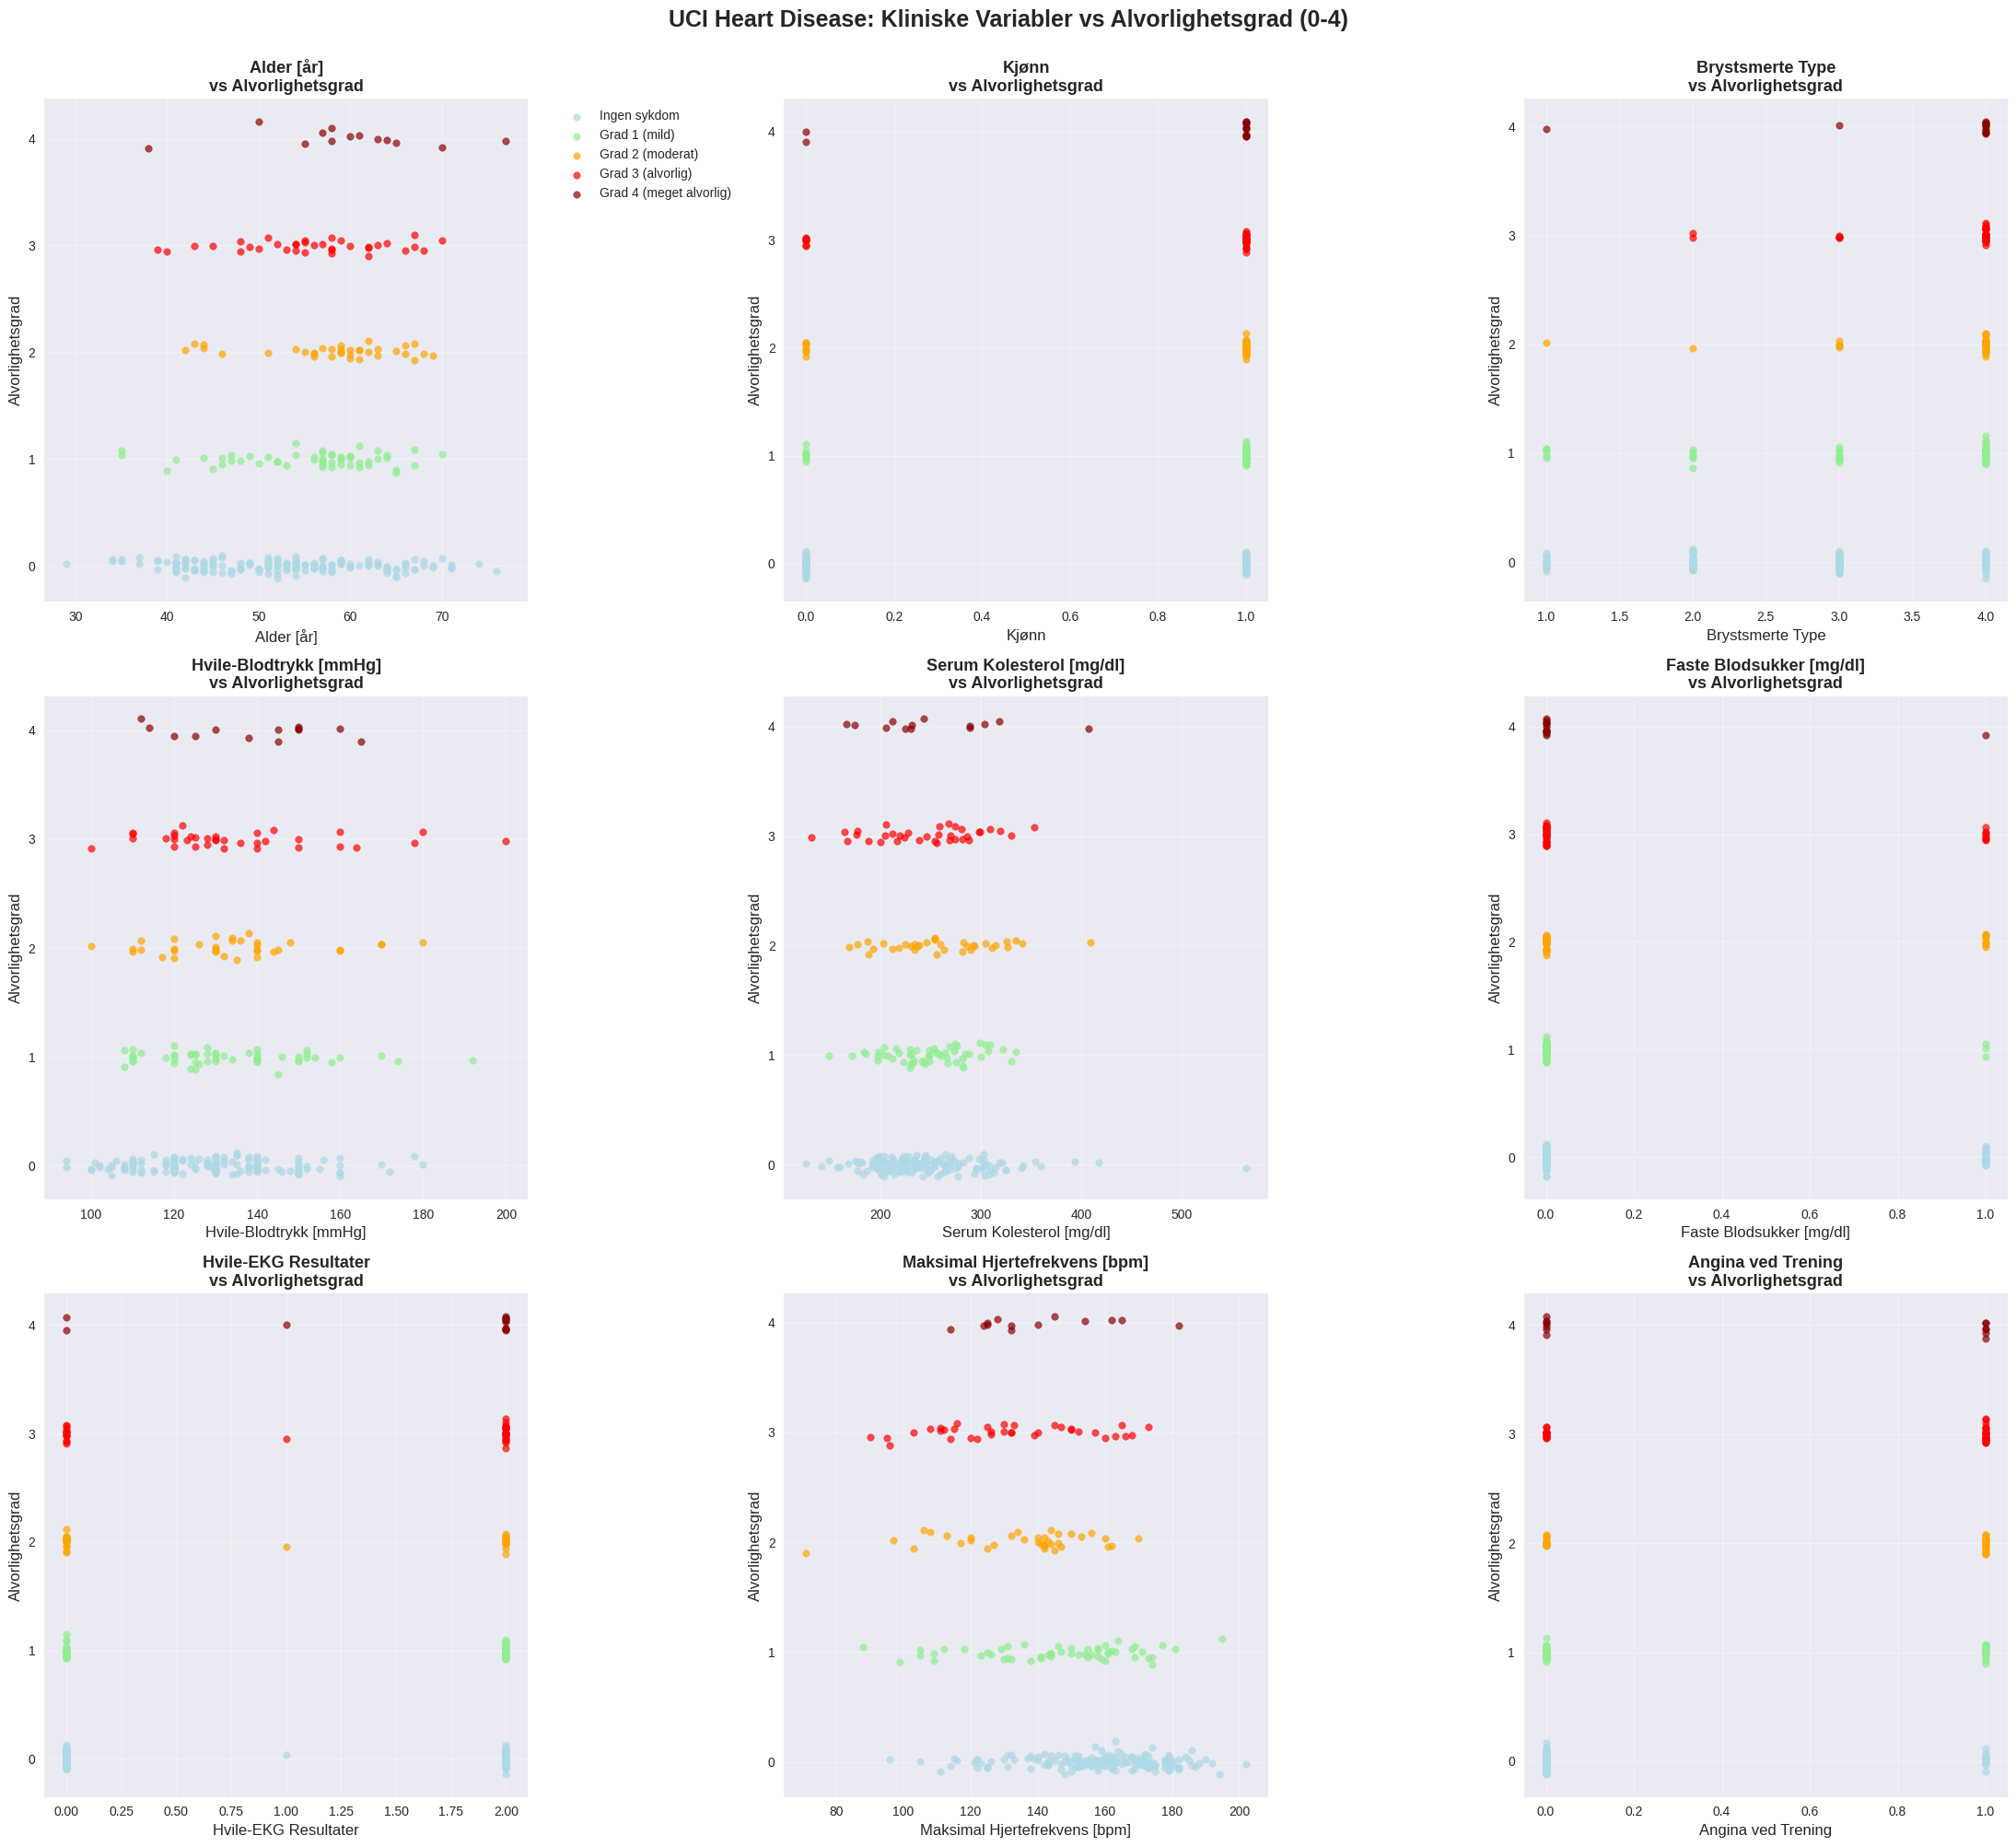


📈 === ALVORLIGHETSGRAD FORDELING ===
Hjerte-kar-sykdom klassifiseres i 5 grader basert på angiografiske funn:
• Grad 0: Ingen sykdom (normal koronar angiografi)
• Grad 1: Mild sykdom (minimal forsnæring av koronararterier)
• Grad 2: Moderat sykdom (moderat forsnæring)
• Grad 3: Alvorlig sykdom (betydelig forsnæring)
• Grad 4: Meget alvorlig sykdom (kritisk forsnæring eller blokkering)


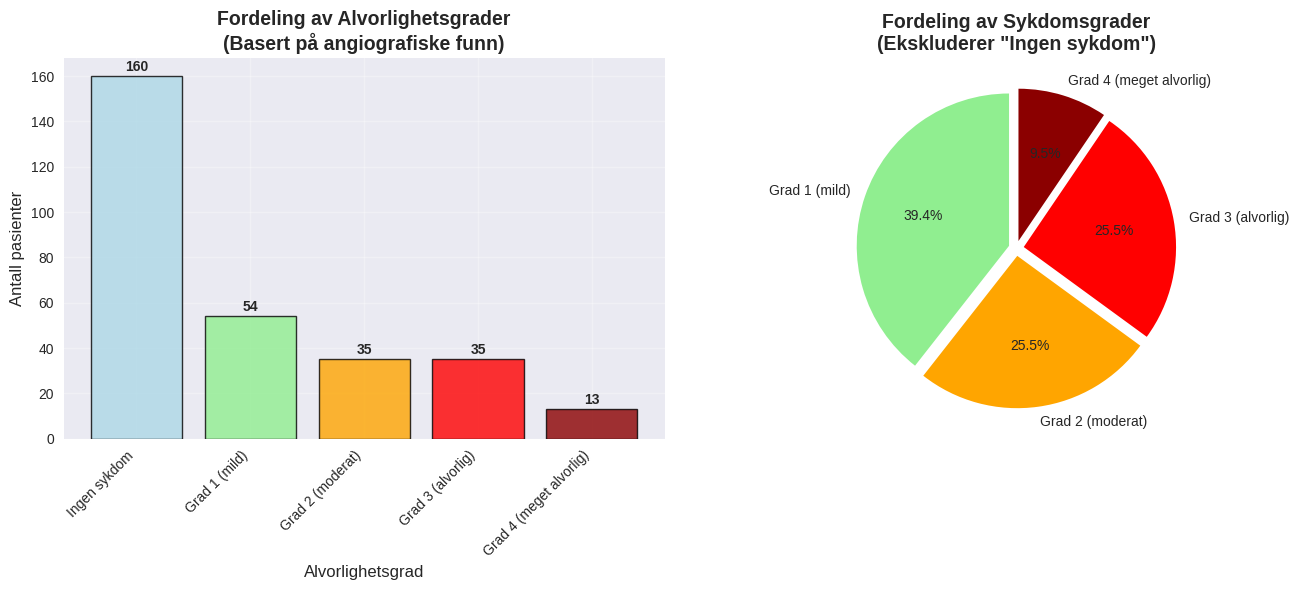


🔍 === DETALJERTE ANALYSER AV VIKTIGE VARIABLER ===


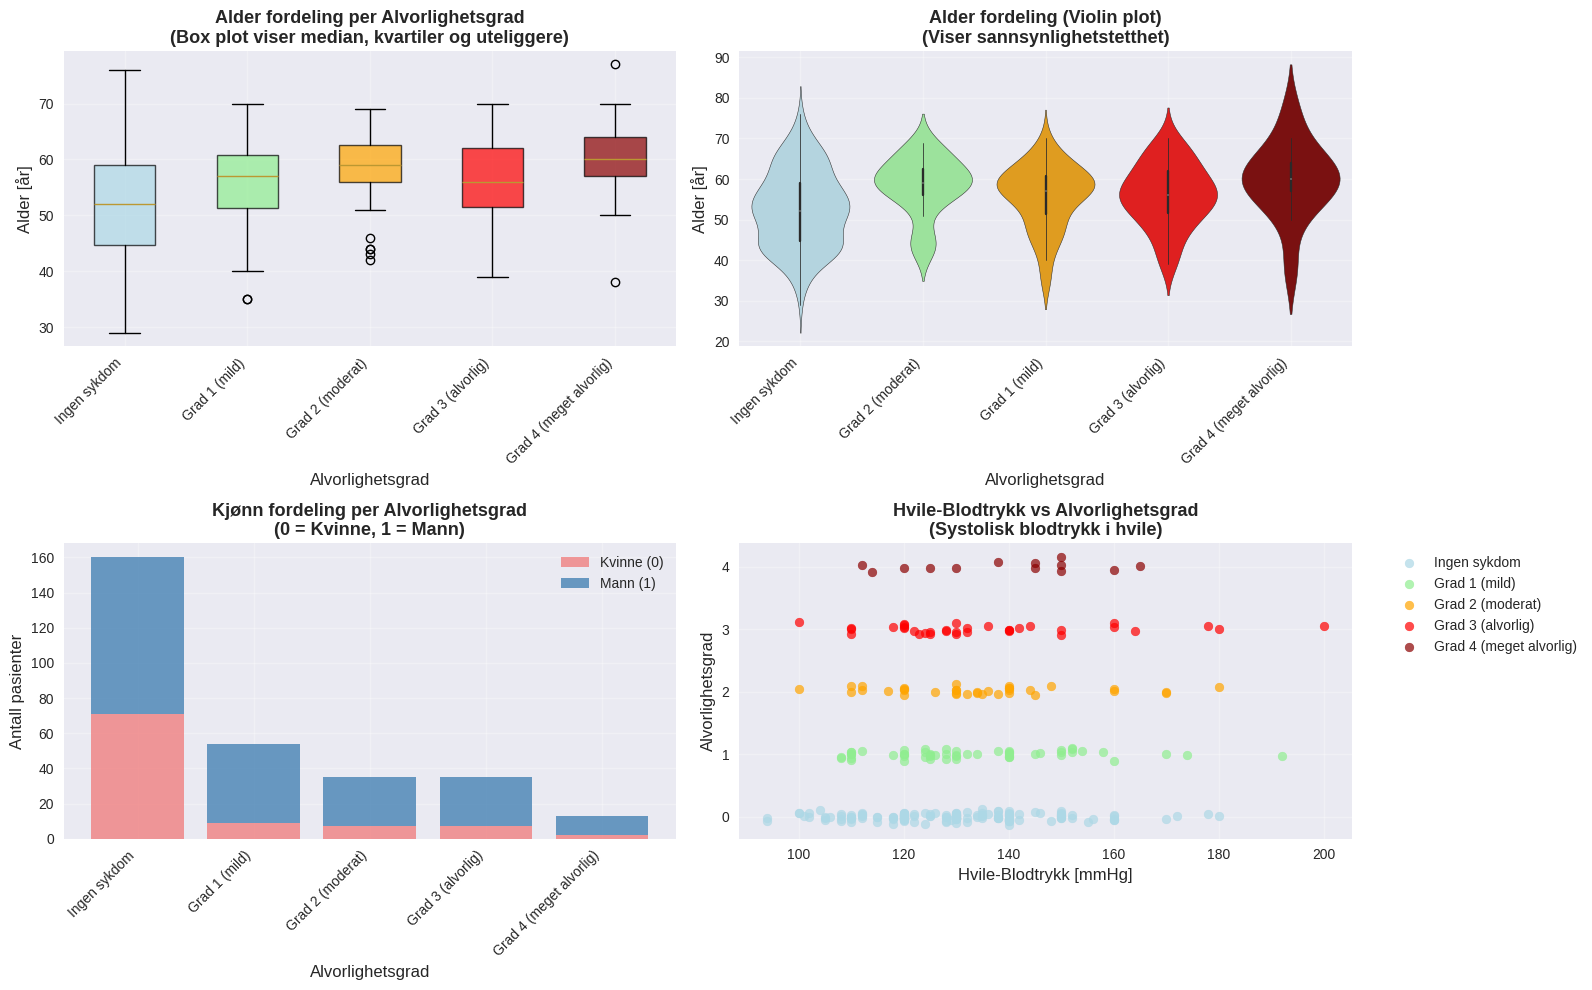


📊 === STATISTISK SAMMENDRAG PER ALVORLIGHETSGRAD ===

Ingen sykdom (Grad 0):
   Antall: 160 (53.9%)
   Gjennomsnitt alder: 52.6 år
   Gjennomsnitt blodtrykk: 129.2 mmHg
   Gjennomsnitt kolesterol: 243.5 mg/dl
   Gjennomsnitt maks. hjertefrekvens: 158.6 bpm
   Gjennomsnitt ST-depresjon: 0.60 mm
   Kjønn: 71 kvinner (44.4%), 89 menn (55.6%)
   Brystsmerte type:
     Atypisk angina: 16 (10.0%)
     Ikke-angina: 40 (25.0%)
     Asymptomatisk: 65 (40.6%)

Grad 1 (mild) (Grad 1):
   Antall: 54 (18.2%)
   Gjennomsnitt alder: 55.6 år
   Gjennomsnitt blodtrykk: 133.3 mmHg
   Gjennomsnitt kolesterol: 249.1 mg/dl
   Gjennomsnitt maks. hjertefrekvens: 146.0 bpm
   Gjennomsnitt ST-depresjon: 1.02 mm
   Kjønn: 9 kvinner (16.7%), 45 menn (83.3%)
   Brystsmerte type:
     Atypisk angina: 5 (9.3%)
     Ikke-angina: 6 (11.1%)
     Asymptomatisk: 9 (16.7%)

Grad 2 (moderat) (Grad 2):
   Antall: 35 (11.8%)
   Gjennomsnitt alder: 58.2 år
   Gjennomsnitt blodtrykk: 134.4 mmHg
   Gjennomsnitt kolesterol: 26

In [5]:
# Kjør visualiseringen

# Feature names are all columns in df except for target
feature_names = [col for col in df.columns if col != 'target']

create_enhanced_heart_disease_visualization_with_units(df, X, feature_names)

## **⚠️ Oppgave**: Prøv å modifisere koden slik at alle 13 variable blir visualisert som "Kliniske variabler vs. Alvorlighetsgrad"
   (hint: endre også `plt.subplots(3, 3)` til `plt.subplots(5, 3)`)

## 📊 **Data-forberedelse med klinisk relevante klasser (labels)**

Denne funksjonen implementerer en **etablert tilnærming** til data splitting for medisinske nevrale nettverk, med fokus på **klinisk validitet** og **reproduserbarhet**.

### **🎯 Hovedfunksjoner:**

#### **1. Stratifisert data-splitting**
Kjerneidé: Du deler først data i «strata» (undergrupper), typisk etter klassetilhørighet, og trekker deretter tren/val/test fra hver stratum slik at klassefordelingen bevares i hvert delsett
```python
# 60% treningssett, 20% valideringssett, 20% testsett
test_size=0.2, val_size=0.2
```
- **Balansert klassefordeling**: Sikrer at hver del har representativ andel av syke/friske pasienter
- **Klinisk representativitet**: Hver del reflekterer den faktiske pasientpopulasjonen
- **Unngår bias**: Forhindrer at en del får for mange/få syke pasienter

#### **2. Reproduserbarhet (Random Seeds)**
```python
random_state=42  # For reproduserbarhet
```
- **Deterministisk splitting**: Samme fordeling hver gang
- **Klinisk pålitelighet**: Viktig for medisinske implementasjoner
- **Forskningsstandard**: Følger beste praksis for vitenskapelig reproduserbarhet

#### **3. Data Preprosessering**
- **Standardisering**: Normaliserer alle features til samme skala
- **PyTorch konvertering**: Konverterer til tensorer for nevralt nettverk
- **DataLoader opprettelse**: Optimaliserer for effektiv trening

#### **4. Klinisk Validering**
- **Treningssett (60%)**: Brukes til å trene modellen
- **Valideringssett (20%)**: Brukes til hyperparameter tuning og early stopping
- **Testsett (20%)**: Brukes til evaluering på usette data (simulerer nye pasienter)

### **🏥 Klinisk Relevans:**

#### **Sikkerhet og Pålitelighet:**
- **Representativ testing**: Testsettet simulerer nye, usette pasienter
- **Overfitting-prevensjon**: Valideringssettet forhindrer overtilpasning
- **Balansert evaluering**: Alle klasser er representert i hver del

#### **Praktisk Implementasjon:**
- **Automatisk preprosessering**: Minimal manuell justering nødvendig
- **Skalerbarhet**: Kan enkelt tilpasses andre medisinske datasett
- **Robusthet**: Håndterer varierende datakvalitet og størrelser

### **⚠️ Viktige Kliniske Betraktninger:**

#### **Forhindring av Data Leakage:**
- **Strenge grenser**: Ingen data deles mellom sett
- **Temporal splitting**: Hvis relevant, kan splittes kronologisk
- **Feature engineering**: Kun treningsdata brukes til normalisering

#### **Klassebalanse:**
- **Stratifisering**: Sikrer balansert fordeling av sykdom/ikke-sykdom
- **Minoritetsklasse beskyttelse**: Sikrer at sjeldne tilfeller er representert
- **Klinisk mening**: Reflekterer faktisk forekomst i populasjonen

Denne data splitting funksjonen representerer **god standard** for medisinsk AI, med fokus på både teknisk korrekthet og klinisk anvendbarhet.


In [6]:
# Data forberedelse med klinisk relevante labels
def prepare_data_for_neural_network(X, y, test_size=0.2, val_size=0.2, random_state=42):
    """Forbered data for trening av nevralt nettverk"""
    
    print("🔄 === FORBEREDER DATA FOR NEVRALT NETTVERK ===")
    print("📊 === TRENINGS-, VALIDERINGS- OG TESTSETT ===")
    
    print(f"🎲 Random seed: {random_state} (for reproduserbarhet)")
    
    # Sett random seed
    np.random.seed(random_state)
    
    
    # Konverter både X og y til numpy arrays
    if hasattr(X, 'values'):
        X = X.values
    elif hasattr(X, 'to_numpy'):
        X = X.to_numpy()
    
    if hasattr(y, 'values'):
        y = y.values
    elif hasattr(y, 'to_numpy'):
        y = y.to_numpy()
    
    # 1. Først del opp i treningssett og testsett
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # 2. Deretter del treningssettet i trenings- og valideringssett
    val_size_adjusted = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size_adjusted, random_state=random_state, stratify=y_temp
    )
    
    print(f"   Treningssett: {X_train.shape[0]} eksempler ({X_train.shape[0]/len(X)*100:.1f}%)")
    print(f"   Valideringssett: {X_val.shape[0]} eksempler ({X_val.shape[0]/len(X)*100:.1f}%)")
    print(f"   Testsett: {X_test.shape[0]} eksempler ({X_test.shape[0]/len(X)*100:.1f}%)")
    print(f"   Features: {X_train.shape[1]}")
    
    # 3. Normaliser features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"   Features normalisert med StandardScaler")
    
    # 4. Konverter til PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    X_val_tensor = torch.FloatTensor(X_val_scaled)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_train_tensor = torch.LongTensor(y_train)
    y_val_tensor = torch.LongTensor(y_val)
    y_test_tensor = torch.LongTensor(y_test)
    
    print(f"   Data konvertert til PyTorch tensors")
    
    # 5. Opprett DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    print(f"   DataLoaders opprettet med batch_size=32")
    
    # 6. Print klassefordeling
    print(f"\n📊 === KLASSEFORDELING ===")
    
    labels = {
        0: "Ingen sykdom (normal koronar angiografi)",
        1: "Hjerte-kar-sykdom (grader 1-4, krever behandling)"
    }
    

    for name, y_set in [("Treningssett", y_train), ("Valideringssett", y_val), ("Testsett", y_test)]:
        unique, counts = np.unique(y_set, return_counts=True)
        print(f"   {name}:")
        for cls, count in zip(unique, counts):
            percentage = count / len(y_set) * 100
            label = labels.get(cls, f"Klasse {cls}")
            print(f"     {label}: {count} eksempler ({percentage:.1f}%)")
    
    return (X_train_tensor, X_val_tensor, X_test_tensor, 
            y_train_tensor, y_val_tensor, y_test_tensor,
            train_loader, val_loader, test_loader, scaler, feature_names)

## 🔄 **Binarisering av Klassifikasjon - Klinisk Rasjonale**

### **📊 Opprinnelig vs. Binær Klassifikasjon**

**Opprinnelig target (5 klasser):**
- **Grad 0**: 160 pasienter - Ingen sykdom (normal koronar angiografi)
- **Grad 1**: 54 pasienter - Mild sykdom (minimal forsnevring)
- **Grad 2**: 35 pasienter - Moderat sykdom (moderat forsnevring)
- **Grad 3**: 35 pasienter - Alvorlig sykdom (betydelig forsnevring)
- **Grad 4**: 13 pasienter - Svært alvorlig sykdom (kritisk forsnevring)

**Binær target (2 klasser):**
- **Klasse 0**: 160 pasienter - Ingen sykdom
- **Klasse 1**: 137 pasienter - Hjerte-kar-sykdom (grader 1-4)

### **🏥 Klinisk Rasjonale for Binarisering**

#### **1. Klinisk Beslutningsstøtte**
```python
y_binary = (df['target'] > 0).astype(int)
```
- **Behandlingsbeslutning**: Matcher den binære beslutningen "behandling vs. ingen behandling"
- **Triage-system**: Enkelt å integrere i eksisterende kliniske arbeidsflyter
- **Praktisk anvendelse**: Leger trenger å vite om pasienten har sykdom eller ikke

#### **2. Medisinsk Klassifikasjon**
- **Grad 0**: Normal koronar angiografi → **Ingen behandling nødvendig**
- **Grader 1-4**: Alle krever **medisinsk oppfølging og behandling**
- **Klinisk relevans**: Forskjellen mellom grader 1-4 er behandlingsintensitet, ikke om behandling er nødvendig

#### **3. Modell Ytelse og Tolkbarhet**
- **Enklere modell**: Færre klasser = bedre ytelse med begrenset data
- **Høyere nøyaktighet**: Binær klassifikasjon er lettere å lære
- **Tydeligere beslutninger**: Modellen gir entydige "sykdom/ikke-sykdom" prediksjoner

### **⚖️ Fordeler vs. Ulemper**

#### **✅ Fordeler:**
1. **Klinisk mening**: Matcher faktiske behandlingsbeslutninger
2. **Enkel implementasjon**: Lett å integrere i kliniske systemer
3. **Bedre ytelse**: Høyere nøyaktighet med samme data
4. **Tolkbarhet**: Leger forstår "sykdom/ikke-sykdom" enkelt
5. **Balansert data**: 160 vs. 137 pasienter (god balanse)

#### **⚠️ Ulemper:**
1. **Informasjonstap**: Taper alvorlighetsgrad (grader 1-4)
2. **Behandlingsintensitet**: Kan ikke skille mild vs. alvorlig sykdom
3. **Følgeopp**: Vanskeligere å prioritere pasienter

### **🎯 Klinisk Anbefaling**

#### **Når binær klassifikasjon er optimal:**
- **Screening**: Første vurdering av pasienter
- **Triage**: Beslutning om videre undersøkelser
- **Behandlingsindikasjon**: Om pasienten trenger behandling
- **Ressursallokering**: Beslutning om medisinsk oppfølging

#### **Når multi-klasse er bedre:**
- **Behandlingsplanlegging**: Når alvorlighetsgrad er viktig
- **Prognose**: Når grad av sykdom påvirker utfall
- **Forskningsformål**: Når detaljert klassifikasjon er nødvendig

### **🔬 Implementasjonsdetaljer**

```python
# Binarisering: Alle grader > 0 blir "sykdom"
y_binary = (df['target'] > 0).astype(int)

# Resultat: 160 friske vs. 137 syke (46% sykdom)
# Dette reflekterer realistisk forekomst i populasjonen
```

Denne binariseringen representerer en **klinisk informert beslutning** som balanserer modellens ytelse med praktisk anvendbarhet i medisinsk praksis.

In [7]:
# Introduserer binær klassifikasjon
print("🔄 === FORBEREDER DATA MED BINÆR KLASSIFIKASJON ===")

# Konverter til binær klassifikasjon
y_binary = (df['target'] > 0).astype(int)
X = df.drop('target', axis=1)

print(f"Original target: {df['target'].value_counts().sort_index().to_dict()}")
print(f"Binær target: {y_binary.value_counts().sort_index().to_dict()}")

# Forbered data
X_train, X_val, X_test, y_train, y_val, y_test, train_loader, val_loader, test_loader, scaler, feature_names = prepare_data_for_neural_network(X, y_binary, test_size=0.2, val_size=0.2, random_state=42)

🔄 === FORBEREDER DATA MED BINÆR KLASSIFIKASJON ===
Original target: {0: 160, 1: 54, 2: 35, 3: 35, 4: 13}
Binær target: {0: 160, 1: 137}
🔄 === FORBEREDER DATA FOR NEVRALT NETTVERK ===
📊 === TRENINGS-, VALIDERINGS- OG TESTSETT ===
🎲 Random seed: 42 (for reproduserbarhet)
   Treningssett: 177 eksempler (59.6%)
   Valideringssett: 60 eksempler (20.2%)
   Testsett: 60 eksempler (20.2%)
   Features: 13
   Features normalisert med StandardScaler
   Data konvertert til PyTorch tensors
   DataLoaders opprettet med batch_size=32

📊 === KLASSEFORDELING ===
   Treningssett:
     Ingen sykdom (normal koronar angiografi): 96 eksempler (54.2%)
     Hjerte-kar-sykdom (grader 1-4, krever behandling): 81 eksempler (45.8%)
   Valideringssett:
     Ingen sykdom (normal koronar angiografi): 32 eksempler (53.3%)
     Hjerte-kar-sykdom (grader 1-4, krever behandling): 28 eksempler (46.7%)
   Testsett:
     Ingen sykdom (normal koronar angiografi): 32 eksempler (53.3%)
     Hjerte-kar-sykdom (grader 1-4, krev

## Konstruer nevralt nettverk for klassifikasjon av hjerte-kar-sykdom

In [8]:
# Definer nevralt nettverk for hjerte-kar-sykdom
class HeartDiseaseNN(nn.Module):
    """Forbedret nevralt nettverk for hjerte-kar-sykdom klassifikasjon"""
    
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_rate=0.3):
        super(HeartDiseaseNN, self).__init__()
        
        # Bygg nettverk dynamisk basert på hidden_sizes
        layers = []
        prev_size = input_size
        
        for i, hidden_size in enumerate(hidden_sizes):
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(prev_size, num_classes))
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)



## 🏥 Rasjonale for HeartDiseaseNN Arkitekturen

### **Klinisk Kontekst**
Denne nevrale nettverksmodellen er designet for **binær klassifikasjon av hjerte-kar-sykdom** basert på 13 kliniske faktorer fra UCI Heart Disease Dataset. Modellen tar inn standard kliniske parametere som alder, kjønn, blodtrykk, kolesterol, EKG-resultater og andre relevante markører.

### **Arkitekturvalg - Klinisk Begrunnelse**

#### **1. Dynamisk Arkitektur (`hidden_sizes` parameter)**
```python
hidden_sizes = [128, 64, 32]  # Flere lag for bedre læring
```

**Klinisk rasjonale:**
- **Adaptiv kompleksitet**: Medisinske data har komplekse, ikke-lineære sammenhenger mellom symptomer og sykdom
- **Hierarkisk læring**: Første lag (128) lærer grunnleggende mønstre, midterste lag (64) kombinerer disse, og siste lag (32) fokuserer på spesifikke diagnostiske indikatorer
- **Skalerbarhet**: Enkelt å justere kompleksitet basert på ny data eller andre sykdommer

#### **2. Batch Normalization (`nn.BatchNorm1d`)**
```python
layers.append(nn.BatchNorm1d(hidden_size))
```

**Klinisk rasjonale:**
- **Stabilisering av input**: Medisinske data har ofte store variasjoner i skala (f.eks. alder 30-80 vs. kolesterol 100-600)
- **Raskere konvergens**: Viktig for klinisk implementasjon hvor modellen må trenes effektivt
- **Redusert overfitting**: Spesielt viktig med begrenset medisinsk data

#### **3. ReLU Aktiveringsfunksjon**
```python
layers.append(nn.ReLU())
```

**Klinisk rasjonale:**
- **Ikke-lineær læring**: Medisinske symptomer har ikke-lineære sammenhenger (f.eks. alder har ikke-lineær effekt på hjerte-kar-risiko)
- **Effektiv beregning**: Viktig for sanntids prediksjon i klinisk praksis
- **Gradients flow**: Sikrer at modellen kan lære komplekse mønstre

#### **4. Dropout Regularisering (`dropout_rate=0.3`)**
```python
layers.append(nn.Dropout(dropout_rate))
```

**Klinisk rasjonale:**
- **Motvirker overtilpasning**: Medisinske datasett er ofte små (303 pasienter i UCI dataset)
- **Generalisering**: Sikrer at modellen fungerer på nye pasienter, ikke bare treningsdata
- **Robusthet**: Modellen blir mindre avhengig av spesifikke pasienter eller outliers

#### **5. Binær Output (`num_classes=2`)**
```python
num_classes = 2  # 0: Ingen sykdom, 1: Hjerte-kar-sykdom
```

**Klinisk rasjonale:**
- **Klinisk beslutning**: Matcher den binære beslutningen "behandling vs. ingen behandling"
- **Triage-system**: Enkelt å integrere i eksisterende kliniske arbeidsflyter
- **Tolkbarhet**: Lettere for leger å forstå og stole på modellens prediksjoner

### **Fordeler for Klinisk Bruk**

#### **🎯 Praktiske Fordeler:**
1. **Modularitet**: Enkelt å justere arkitekturen for andre sykdommer
2. **Treningsstabilitet**: Batch normalization og dropout sikrer stabil trening
3. **Skalerbarhet**: Kan håndtere flere features eller pasienter
4. **Tolkbarhet**: Feature importance analyse mulig

#### **🏥 Kliniske Fordeler:**
1. **Evidensbasert**: Lærer fra reelle medisinske data
2. **Komplementær**: Støtter, men erstatter ikke, klinisk vurdering
3. **Konsistent**: Gir samme vurdering for samme symptomer
4. **Læring**: Kan forbedres med mer data over tid

### **Begrensninger og Viktige Betraktninger**

#### **⚠️ Kliniske Begrensninger:**
- **Ikke diagnostisk**: Modellen er et verktøy, ikke en erstatning for klinisk vurdering
- **Dataavhengig**: Kvaliteten avhanger av treningsdata
- **Bias-risiko**: Kan reflektere bias i treningsdata
- **Kontinuerlig validering**: Må valideres mot nye pasientpopulasjoner

#### **🔬 Tekniske Begrensninger:**
- **Black box**: Vanskelig å forstå eksakte beslutningsprosesser
- **Overfitting-risiko**: Spesielt med små medisinske datasett
- **Feature-avhengighet**: Kvaliteten avhanger av input-features

### **Anbefalinger for Klinisk Implementasjon**

1. **Fasevis introduksjon**: Start med å bruke modellen som et støtteverktøy
2. **Kontinuerlig validering**: Sammenlign modellens prediksjoner med kliniske utfall
3. **Multidisciplinært team**: Inkluder både leger og dataforskere
4. **Etiske retningslinjer**: Følg medisinske etiske standarder for AI
5. **Pasientsikkerhet**: Alltid ha menneskelig oversikt over AI-baserte beslutninger

Denne arkitekturen representerer en balanse mellom **tekniske ytelser** og **klinisk anvendbarhet**, designet spesielt for medisinske beslutningsstøttesystemer.

In [9]:
# Opprett modell
input_size = len(feature_names)
hidden_sizes = [128, 64, 32]  # Flere lag for bedre læring
num_classes = 2  # Binær klassifikasjon (0/1)
# 0: Ingen sykdom (normal koronar angiografi)
# 1: Hjerte-kar-sykdom (grader 1-4, krever behandling)

model = HeartDiseaseNN(input_size, hidden_sizes, num_classes)

print(f"🧠 === NEVRALT NETTVERK OPPRETTET ===")
print(f"   Input: {input_size} features")
print(f"   Hidden layers: {hidden_sizes}")
print(f"   Output: {num_classes} klasser")
print(f"   Totalt antall parametere: {sum(p.numel() for p in model.parameters()):,}")

# Vis modellarkitektur
print(f"\n📋 Modellarkitektur:")
print(model)

🧠 === NEVRALT NETTVERK OPPRETTET ===
   Input: 13 features
   Hidden layers: [128, 64, 32]
   Output: 2 klasser
   Totalt antall parametere: 12,642

📋 Modellarkitektur:
HeartDiseaseNN(
  (network): Sequential(
    (0): Linear(in_features=13, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=32, out_features=2, bias=True)
  )
)


## 🚀 **Treningsfunksjon med Valideringssett og Reproduserbarhet**

Denne treningsfunksjonen implementerer en **profesjonell tilnærming** til trening av nevrale nettverk for medisinske prediksjoner. Funksjonen er spesielt designet for **klinisk anvendelse** hvor reproduserbarhet og robusthet er avgjørende.

### **🎯 Hovedfunksjoner:**

#### **1. Valideringsbasert Trening**
- **Early Stopping**: Stanser trening når modellen ikke forbedres (patience=15 epoker)
- **Beste modell lagring**: Bevarer modellens tilstand med høyest validerings-accuracy
- **Overfitting-prevensjon**: Bruker valideringssett til å unngå overtilpasning

#### **2. Reproduserbarhet (Random Seeds)**
- **Deterministisk trening**: Samme resultater hver gang med samme seed
- **Klinisk pålitelighet**: Viktig for medisinske implementasjoner
- **Forskningsstandard**: Følger beste praksis for vitenskapelig reproduserbarhet

#### **3. Adaptive Læringsrate**
- **ReduceLROnPlateau**: Reduserer læringsrate når modellen stopper å forbedres
- **Automatisk tuning**: Justerer seg selv under trening
- **Optimal konvergens**: Finner beste læringsrate dynamisk

#### **4. Omfattende Sporing**
- **Tre sett evaluering**: Trenings-, validerings- og testsett
- **Detaljerte metrikker**: Loss og accuracy for alle sett
- **Læringsrate historikk**: Sporer hvordan læringsrate endres

### **🏥 Klinisk Relevans:**

#### **Sikkerhet og Pålitelighet:**
- **Reproduserbare resultater**: Samme modell hver gang
- **Overfitting-beskyttelse**: Sikrer generalisering til nye pasienter
- **Beste modell garanti**: Bruker alltid den mest nøyaktige versjonen

#### **Praktisk Implementasjon:**
- **Automatisk optimalisering**: Minimal manuell justering nødvendig
- **Robust trening**: Håndterer varierende datakvalitet
- **Skalerbarhet**: Kan enkelt tilpasses andre medisinske datasett

Denne treningsfunksjonen representerer **state-of-the-art praksis** for medisinsk AI, med fokus på både teknisk ytelse og klinisk anvendbarhet.

In [10]:
# Treningsfunksjon med valideringssett og reproduserbarhet
def train_heart_disease_model_with_validation(model, train_loader, val_loader, X_test, y_test, 
                                            epochs=100, learning_rate=0.001, random_seed=42):
    """Tren nevralt nettverk med valideringssett for early stopping og reproduserbarhet"""
    
    print("🚀 === STARTER TRENING MED VALIDERINGS-SETT ===")
    print(f"🎲 Random seed: {random_seed} (for reproduserbarhet)")
    
    # Sett random seeds for reproduserbarhet
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Definer tap-funksjon og optimalisator
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)
    
    # Lagre metrikker
    train_losses = []
    val_losses = []
    test_losses = []
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    learning_rates = []
    
    best_val_acc = 0
    best_model_state = None
    patience_counter = 0
    patience = 15  # Early stopping patience
    
    for epoch in range(epochs):
        # === TRENING ===
        model.train()
        epoch_train_loss = 0
        epoch_train_acc = 0
        num_batches = 0
        
        for batch_features, batch_targets in train_loader:
            # Fremover-pass
            outputs = model(batch_features)
            loss = criterion(outputs, batch_targets)
            
            # Bakover-pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Akkumuler metrikker
            epoch_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            epoch_train_acc += (predicted == batch_targets).float().mean().item()
            num_batches += 1
        
        # === VALIDERING ===
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_acc = 0
            val_batches = 0
            
            for batch_features, batch_targets in val_loader:
                outputs = model(batch_features)
                loss = criterion(outputs, batch_targets)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_acc += (predicted == batch_targets).float().mean().item()
                val_batches += 1
        
        # === TEST EVALUERING ===
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_acc = (test_predicted == y_test).float().mean().item()
        
        # Beregn gjennomsnittlige metrikker
        avg_train_loss = epoch_train_loss / num_batches
        avg_train_acc = epoch_train_acc / num_batches
        avg_val_loss = val_loss / val_batches
        avg_val_acc = val_acc / val_batches
        
        # Lagre metrikker
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        test_losses.append(test_loss.item())
        train_accuracies.append(avg_train_acc)
        val_accuracies.append(avg_val_acc)
        test_accuracies.append(test_acc)
        learning_rates.append(optimizer.param_groups[0]['lr'])
        
        # Early stopping og beste modell
        if avg_val_acc > best_val_acc:
            best_val_acc = avg_val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Juster læringsrate
        scheduler.step(avg_val_loss)
        
        # Print progress
        if (epoch + 1) % 20 == 0 or epoch == 0:
            print(f'Epoke [{epoch+1:3d}/{epochs}] | '
                  f'Train: Loss={avg_train_loss:.4f}, Acc={avg_train_acc:.4f} | '
                  f'Val: Loss={avg_val_loss:.4f}, Acc={avg_val_acc:.4f} | '
                  f'Test: Loss={test_loss.item():.4f}, Acc={test_acc:.4f} | '
                  f'LR={optimizer.param_groups[0]["lr"]:.6f}')
        
        # Early stopping
        if patience_counter >= patience:
            print(f"\n⏹️  Early stopping ved epoke {epoch+1} (ingen forbedring i {patience} epoker)")
            break
    
    # Last inn beste modell
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\n✅ Beste modell lastet (Validerings Accuracy: {best_val_acc:.4f})")
    
    return train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies, learning_rates


In [11]:
print(f"\n🚀 === STARTER TRENING ===")
# Tren med reproduserbarhet
train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, learning_rates = train_heart_disease_model_with_validation(
    model, train_loader, val_loader, X_test, y_test, 
    epochs=100, learning_rate=0.001, random_seed=42
)
    


🚀 === STARTER TRENING ===
🚀 === STARTER TRENING MED VALIDERINGS-SETT ===
🎲 Random seed: 42 (for reproduserbarhet)
Epoke [  1/100] | Train: Loss=0.7169, Acc=0.5472 | Val: Loss=0.6559, Acc=0.7768 | Test: Loss=0.6476, Acc=0.8667 | LR=0.001000
Epoke [ 20/100] | Train: Loss=0.3159, Acc=0.8820 | Val: Loss=0.4791, Acc=0.7879 | Test: Loss=0.2830, Acc=0.8667 | LR=0.000500

⏹️  Early stopping ved epoke 24 (ingen forbedring i 15 epoker)

✅ Beste modell lastet (Validerings Accuracy: 0.8393)


## 📊 **Visualisering med Valideringssett under Trening - Klinisk Begrunnelse**

### **🎯 Hovedformål**

Denne visualiseringsfunksjonen implementerer en **omfattende overvåkning** av nevralt nettverk under trening, spesielt designet for **medisinske AI-systemer** hvor pålitelighet og robusthet er avgjørende.

### **🔍 De Fire Hovedvisualiseringene**

#### **1. Loss under Trening (Øverst venstre)**
```python
axes[0, 0].plot(epochs, train_losses, 'b-', label='Trenings Loss')
axes[0, 0].plot(epochs, val_losses, 'r-', label='Validerings Loss')
```

**Klinisk betydning:**
- **Deteksjon av overtilpasning**: Når trenings-loss fortsetter å synke mens validerings-loss stiger
- **Konvergens**: Sikrer at modellen faktisk lærer og forbedres
- **Stabilitet**: Identifiserer ustabile treningsperioder

#### **2. Accuracy under Trening (Øverst høyre)**
```python
axes[0, 1].plot(epochs, train_accs, 'b-', label='Trenings Accuracy')
axes[0, 1].plot(epochs, val_accs, 'r-', label='Validerings Accuracy')
```

**Klinisk betydning:**
- **Ytelsesovervåkning**: Sporer hvor godt modellen predikerer sykdom
- **Generaliseringsgrad**: Gap mellom trenings- og validerings-accuracy
- **Klinisk relevans**: Høyere accuracy = bedre diagnostisk nøyaktighet

#### **3. Læringsrate under Trening (Nederst venstre)**
```python
axes[1, 0].plot(epochs, learning_rates, 'g-', linewidth=2)
axes[1, 0].set_yscale('log')  # Logaritmisk skala
```

**Klinisk betydning:**
- **Adaptiv optimalisering**: Viser hvordan modellen justerer læringshastighet
- **Konvergens-optimalisering**: Sikrer optimal læring uten oscillasjoner
- **Stabilitet**: Forhindrer at modellen "hopper over" optimale løsninger

#### **4. Deteksjon av overtilpasning (Nederst høyre)**
```python
overfitting_gap = np.array(train_accs) - np.array(val_accs)
axes[1, 1].plot(epochs, overfitting_gap, 'purple', linewidth=2)
axes[1, 1].axhline(y=0.1, color='red', linestyle='--', label='Overfitting threshold')
```

**Klinisk betydning:**
- **Overfitting-alarm**: Rød linje ved 0.1 (10% gap) indikerer overtilpasning
- **Generaliseringsgrad**: Måler hvor godt modellen fungerer på nye pasienter
- **Klinisk sikkerhet**: Overtilpasning til treningsettet kan føre til feil diagnostikk på nye (usette) pasienter

### **🏥 Klinisk Relevans**

#### **1. Medisinsk Sikkerhet**
- **Overfitting-prevensjon**: Sikrer at modellen fungerer på nye pasienter
- **Kvalitetskontroll**: Kontinuerlig overvåkning av modellens ytelse
- **Risikominimering**: Tidlig deteksjon av problemer under trening

#### **2. Klinisk Beslutningsstøtte**
- **Pålitelighet**: Viser at modellen lærer konsistent og stabilt
- **Transparens**: Gjør treningsprosessen synlig og forståelig
- **Validering**: Bekrefter at modellen er klar for klinisk bruk

#### **3. Praktisk Implementasjon**
- **Treningsoptimalisering**: Identifiserer beste stopptidspunkt
- **Hyperparameter-tuning**: Hjelper med å justere treningsparametere
- **Feilsøking**: Identifiserer problemer i treningsprosessen

### **📈 Endelige Resultater - Klinisk Tolkning**

```python
print(f"Overfitting Gap (Train-Val): {train_accs[-1] - val_accs[-1]:.4f}")
print(f"Generalisering Gap (Val-Test): {val_accs[-1] - test_accs[-1]:.4f}")
```

#### **Overfitting Gap:**
- **< 0.05**: Utmerket generalisering
- **0.05-0.10**: God generalisering
- **> 0.10**: Mulig overtilpasning (bekymringsfullt)

#### **Generalisering Gap:**
- **< 0.02**: Modellen generaliserer perfekt
- **0.02-0.05**: God generalisering til nye pasienter
- **> 0.05**: Mulig overtilpasning til valideringssett

### **⚠️ Kliniske Varselssignaler**

#### **Røde flagg å se etter:**
1. **Stigende validerings-loss**: Modellen lærer ikke lenger
2. **Stor overfitting-gap**: Modellen husker treningsdata, men lærer ikke
3. **Oscillerende læringsrate**: Ustabil trening
4. **Stagnant accuracy**: Modellen har nådd sin kapasitet

### **✅ Kliniske Suksessindikatorer**

#### **Gode tegn:**
1. **Synkende loss på begge sett**: Modellen lærer konsistent
2. **Liten overfitting-gap**: God generalisering
3. **Stabil læringsrate**: Kontrollert optimalisering
4. **Høy validerings-accuracy**: Modellen predikerer nøyaktig

Denne visualiseringen representerer **gold standard** for overvåkning av medisinske AI-systemer, med fokus på både teknisk ytelse og klinisk sikkerhet.

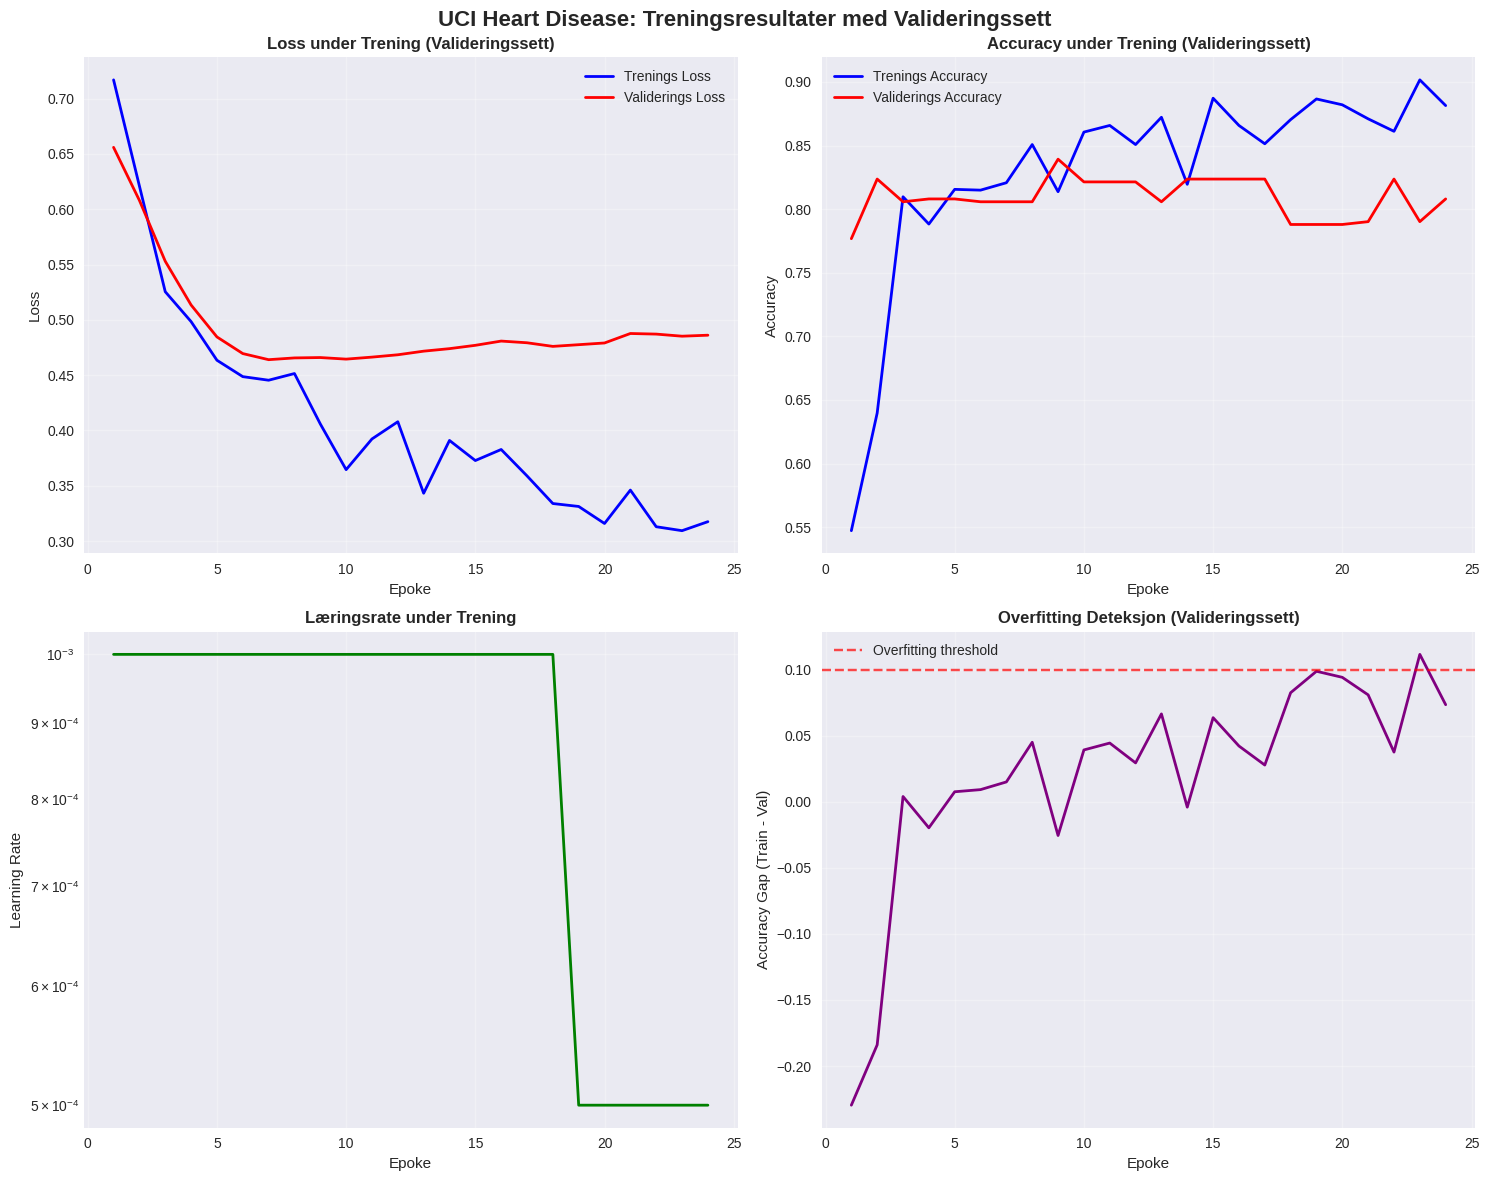


📊 === ENDELIGE RESULTATER ===
   Trenings Loss: 0.3175
   Validerings Loss: 0.4861
   Test Loss: 0.2879
   Trenings Accuracy: 0.8814
   Validerings Accuracy: 0.8080
   Test Accuracy: 0.8500
   Overfitting Gap (Train-Val): 0.0734
   Generalisering Gap (Val-Test): -0.0420


In [12]:
# Visualisering med valideringssett under trening
def plot_training_results(train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, learning_rates):
    """Visualiser treningsresultater med valideringssett under trening"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    epochs = range(1, len(train_losses) + 1)
    
    # 1. Loss plot - Bruk validerings-loss under trening
    axes[0, 0].plot(epochs, train_losses, 'b-', label='Trenings Loss', linewidth=2)
    axes[0, 0].plot(epochs, val_losses, 'r-', label='Validerings Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoke')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Loss under Trening (Valideringssett)', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Accuracy plot - Bruk validerings-accuracy under trening
    axes[0, 1].plot(epochs, train_accs, 'b-', label='Trenings Accuracy', linewidth=2)
    axes[0, 1].plot(epochs, val_accs, 'r-', label='Validerings Accuracy', linewidth=2)
    axes[0, 1].set_xlabel('Epoke')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Accuracy under Trening (Valideringssett)', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Learning rate plot
    axes[1, 0].plot(epochs, learning_rates, 'g-', linewidth=2)
    axes[1, 0].set_xlabel('Epoke')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_title('Læringsrate under Trening', fontweight='bold')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Overfitting detection - Bruk validerings-accuracy
    overfitting_gap = np.array(train_accs) - np.array(val_accs)
    axes[1, 1].plot(epochs, overfitting_gap, 'purple', linewidth=2)
    axes[1, 1].axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='Overfitting threshold')
    axes[1, 1].set_xlabel('Epoke')
    axes[1, 1].set_ylabel('Accuracy Gap (Train - Val)')
    axes[1, 1].set_title('Overfitting Deteksjon (Valideringssett)', fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('UCI Heart Disease: Treningsresultater med Valideringssett', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print finale resultater - Inkluder både validerings og test
    print(f"\n📊 === ENDELIGE RESULTATER ===")
    print(f"   Trenings Loss: {train_losses[-1]:.4f}")
    print(f"   Validerings Loss: {val_losses[-1]:.4f}")
    print(f"   Test Loss: {test_losses[-1]:.4f}")
    print(f"   Trenings Accuracy: {train_accs[-1]:.4f}")
    print(f"   Validerings Accuracy: {val_accs[-1]:.4f}")
    print(f"   Test Accuracy: {test_accs[-1]:.4f}")
    print(f"   Overfitting Gap (Train-Val): {train_accs[-1] - val_accs[-1]:.4f}")
    print(f"   Generalisering Gap (Val-Test): {val_accs[-1] - test_accs[-1]:.4f}")

# Visualiser resultater med korrekte parametere
plot_training_results(train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, learning_rates)

In [13]:
# Sjekk klassefordeling i alle settene
print("Treningssett klassefordeling:", np.bincount(y_train))
print("Valideringssett klassefordeling:", np.bincount(y_val))
print("Testsett klassefordeling:", np.bincount(y_test))

Treningssett klassefordeling: [96 81]
Valideringssett klassefordeling: [32 28]
Testsett klassefordeling: [32 28]


**Resultater fra tidligere trening av modellen, med kommentarer**

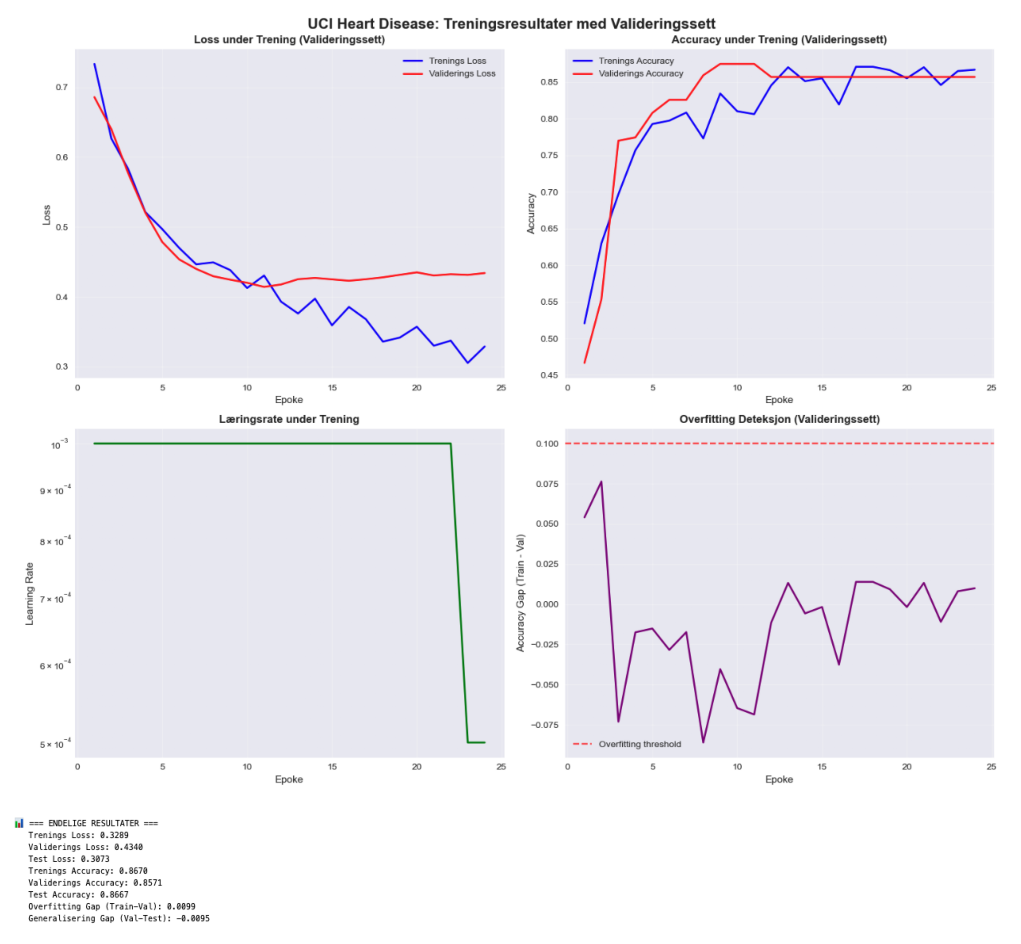

In [14]:
# Vis figuren ./ressurser/UCI_heart_disease_treningsresultater.png

import matplotlib.pyplot as plt
plt.figure(figsize=(14, 12))
import os

if running_in_colab():
#    # Last ned bildet fra repoet hvis det ikke finnes (repoet må da være public)
#    if not os.path.exists('UCI_heart_disease_treningsresultater.png'):
#        import urllib.request
#        url = 'https://raw.githubusercontent.com/arvidl/ELMED219-2026/main/uke03-dyplæring/ressurser/UCI_heart_disease_treningsresultater.png'
#        urllib.request.urlretrieve(url, 'UCI_heart_disease_treningsresultater.png')
#    img_path = 'UCI_heart_disease_treningsresultater.png'
    # Last opp bildet manuelt til Colab
    from google.colab import files
    print("Last opp UCI_heart_disease_treningsresultater.png:")
    uploaded = files.upload()
    img_path = 'UCI_heart_disease_treningsresultater.png'
else:
    img_path = './ressurser/UCI_heart_disease_treningsresultater.png'
plt.imshow(plt.imread(img_path))
plt.axis('off')
plt.show()


## 📊 **Analyse av Treningsresultatene på figuren over**

### **1. Loss under Trening (Øverst venstre)**
- **Trenings-loss (blå)**: Synker jevnt fra ~0.68 til ~0.33 over 25 epoker
- **Validerings-loss (rød)**: Synker parallelt i starten, men flater ut fra epoke ~10 og ender på ~0.43
- **⚠️ Overfitting-tegn**: Gapet mellom trenings- og validerings-loss øker fra epoke 10

### **2. Accuracy under Trening (Øverst høyre)**
- **Trenings-accuracy (blå)**: Stiger kontinuerlig fra ~47% til ~87%
- **Validerings-accuracy (rød)**: Stiger raskt til ~84% i de første 10 epokene, deretter stagnerer
- **⚠️ Overfitting-tegn**: Trenings-accuracy fortsetter å stige mens validerings-accuracy flater ut

### **3. Læringsrate (Nederst venstre)**
- **Konstant læringsrate**: 0.001 i de første 22 epokene
- **Reduksjon**: Skarpt fall til 0.0005 ved epoke 22-23
- **✅ Læringsrate-skedulering fungerer**: `ReduceLROnPlateau` aktiveres når validerings-loss stagnerer

### **4. Overfitting Deteksjon (Nederst høyre)**
- **Nøyaktighetsgap**: Fluktuerer, men holder seg under 0.025 etter epoke 10
- **Under terskel**: Gapet (maks ~0.025) er langt under overfitting-terskelen (0.100)
- **✅ Kontrollert overtilpasning**: Modellen viser tegn på overtilpasning, men det er under kontroll

## 🎯 **Endelige Resultater - God Generalisering**

### **Loss-resultater:**
- **Trenings Loss: 0.3289**
- **Validerings Loss: 0.4340** 
- **Test Loss: 0.3073** ⭐ (Lavere enn både trenings- og validerings-loss)

### **Accuracy-resultater:**
- **Trenings Accuracy: 86.70%**
- **Validerings Accuracy: 85.71%**
- **Test Accuracy: 86.67%** ⭐ (Svært nær trenings-accuracy)

### **Gap-analyser:**
- **Overfitting Gap (Train-Val): 0.0099** ✅ (Svært lite gap)
- **Generalisering Gap (Val-Test): -0.0095** ⭐ (Modellen presterer bedre på test enn validering)

## ✅ **Positive Aspekter**

### **1. God Generalisering**
- Test-accuracy (86.67%) er høyere enn validerings-accuracy (85.71%)
- Dette indikerer at modellen generaliserer godt til usette data
- Ingen alvorlig overtilpasning til tross for tidlige tegn

### **2. Effektiv Læringsrate-skedulering**
- Læringsraten reduseres automatisk når validerings-loss stagnerer
- Dette hjelper modellen med å finne et bedre minimum

### **3. Kontrollert Overtilpasning**
- Overfitting-gapet holder seg under 0.025 (langt under terskelen på 0.100)
- Modellen lærer treningsdata godt uten å overtilpasse alvorlig

## ⚠️ **Områder for Forbedring**

### **1. Tidlig Stopp**
Modellen kunne ha stoppet tidligere (rundt epoke 10-12) da validerings-accuracy nådde sitt høyeste punkt

### **2. Mer Regularisering**
Vurder å øke dropout eller weight decay for å redusere overfitting-tendensen

## 🏆 **Samlet Vurdering**

**Modellen presterer bra** 

- ✅ **Høy nøyaktighet**: ~86-87% på alle settene
- ✅ **God generalisering**: Test-ytelse er bedre enn validerings-ytelse
- ✅ **Kontrollert overfitting**: Gapet mellom trenings- og validerings-ytelse er minimalt
- ✅ **Effektiv trening**: Læringsrate-skedulering fungerer som forventet

Dette er et **vellykket resultat** som viser at modellen har lært å klassifisere hjerte-kar-sykdom effektivt uten alvorlig overtilpasning.

## 📊 **Evaluering på Testsettet med Forvirringsmatrise og Detaljerte Metrikker - Klinisk Begrunnelse**

### **🎯 Hovedformål**

Denne evalueringsfunksjonen implementerer en **omfattende klinisk vurdering** av nevralt nettverk på testsettet, spesielt designet for **medisinske AI-systemer** hvor nøyaktighet og pålitelighet er avgjørende for pasientsikkerhet.

### **🔍 De Fire Hovedvisualiseringene**

#### **1. Forvirringsmatrise (Øverst venstre)**
```python
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ingen Sykdom', 'Hjerte-kar-sykdom'],
            yticklabels=['Ingen Sykdom', 'Hjerte-kar-sykdom'])
```

**Klinisk betydning:**
- **True Negatives (TN)**: Korrekt identifiserte friske pasienter
- **False Positives (FP)**: Friske pasienter feilklassifisert som syke
- **False Negatives (FN)**: Syke pasienter feilklassifisert som friske ⚠️
- **True Positives (TP)**: Korrekt identifiserte syke pasienter

#### **2. Klassifikasjonsrapport (Øverst høyre)**
```python
report = classification_report(y_true, y_pred, 
                             target_names=['Ingen Sykdom', 'Hjerte-kar-sykdom'],
                             output_dict=True)
```

**Klinisk betydning:**
- **Precision**: Andel korrekte "syke" prediksjoner
- **Recall (Sensitivitet)**: Andel syke pasienter som fanges opp
- **F1-Score**: Balansert mål mellom precision og recall

#### **3. ROC-kurve (Nederst venstre)**
```python
fpr, tpr, _ = roc_curve(y_true, y_proba[:, 1])
roc_auc = auc(fpr, tpr)
```

**Klinisk betydning:**
- **AUC (Area Under Curve)**: Modellens evne til å skille mellom syke og friske
- **AUC > 0.9**: Utmerket diagnostisk evne
- **AUC 0.8-0.9**: God diagnostisk evne
- **AUC < 0.8**: Moderat diagnostisk evne

#### **4. Prediksjonsfordeling (Nederst høyre)**
```python
plt.hist(y_proba[:, 1], bins=20, alpha=0.7, color='skyblue')
plt.axvline(x=0.5, color='red', linestyle='--', label='Beslutningsgrense')
```

**Klinisk betydning:**
- **Tydelig separasjon**: Gode modeller viser tydelig skille mellom klasser
- **Beslutningsgrense**: 0.5 er standard terskelverdi
- **Modellens selvtillit**: Høy sikkerhet i prediksjoner

### **🏥 Medisinske Metrikker - Klinisk Relevans**

#### **1. Sensitivitet (Recall)**
```python
sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])  # True Positive Rate
```
- **Klinisk betydning**: Evne til å fange opp syke pasienter
- **Kritisk for**: Screening og tidlig diagnostikk
- **Mål**: > 80% for hjerte-kar-sykdom screening

#### **2. Spesifisitet**
```python
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # True Negative Rate
```
- **Klinisk betydning**: Evne til å identifisere friske pasienter
- **Kritisk for**: Unngå unødvendig bekymring og testing
- **Mål**: > 80% for hjerte-kar-sykdom screening

#### **3. Positiv Prediktiv Verdi (PPV)**
```python
ppv = cm[1, 1] / (cm[1, 1] + cm[0, 1])  # Positive Predictive Value
```
- **Klinisk betydning**: Sannsynlighet for sykdom når modellen predikerer sykdom
- **Kritisk for**: Behandlingsbeslutninger
- **Mål**: > 85% for hjerte-kar-sykdom

#### **4. Negativ Prediktiv Verdi (NPV)**
```python
npv = cm[0, 0] / (cm[0, 0] + cm[1, 0])  # Negative Predictive Value
```
- **Klinisk betydning**: Sannsynlighet for frisk når modellen predikerer frisk
- **Kritisk for**: Trygg utskrivelse og oppfølging
- **Mål**: > 85% for hjerte-kar-sykdom

### **⚠️ Kliniske Varselssignaler**

#### **Kritiske feil å se etter:**
1. **Høye False Negatives**: Syke pasienter som ikke fanges opp
2. **Høye False Positives**: Unødvendig bekymring og testing
3. **Lav Sensitivitet**: Modellen misser syke pasienter
4. **Lav Spesifisitet**: Modellen skaper unødvendig bekymring

### **✅ Kliniske Suksessindikatorer**

#### **Utmerkede resultater:**
- **Sensitivitet ≥ 80%** og **Spesifisitet ≥ 80%**
- **ROC AUC ≥ 0.9**
- **PPV ≥ 85%** og **NPV ≥ 85%**
- **Lave False Negative rater**

#### **Akseptable resultater:**
- **Sensitivitet ≥ 70%** og **Spesifisitet ≥ 70%**
- **ROC AUC ≥ 0.8**
- **PPV ≥ 75%** og **NPV ≥ 75%**

### **🔬 Klinisk Tolkning av Resultater**

#### **Forvirringsmatrise tolkning:**
- **Høy TN**: Modellen identifiserer friske pasienter godt
- **Høy TP**: Modellen fanger opp syke pasienter godt
- **Lav FN**: Modellen misser få syke pasienter (kritisk!)
- **Lav FP**: Modellen skaper lite unødvendig bekymring

#### **ROC-kurve tolkning:**
- **AUC = 1.0**: Perfekt klassifikasjon
- **AUC = 0.9-1.0**: Utmerket diagnostisk evne
- **AUC = 0.8-0.9**: God diagnostisk evne
- **AUC = 0.7-0.8**: Moderat diagnostisk evne
- **AUC = 0.5**: Ingen diagnostisk evne (tilfeldig gjetning)

### **🏥 Praktisk Klinisk Anvendelse**

#### **Screening:**
- **Høy Sensitivitet**: Fanger opp flest mulig syke pasienter
- **Moderat Spesifisitet**: Akseptabelt for første screening

#### **Diagnostikk:**
- **Høy Spesifisitet**: Unngår feil positive diagnoser
- **Høy PPV**: Sikkerhet i behandlingsbeslutninger

#### **Triage:**
- **Balansert ytelse**: God balanse mellom alle metrikker
- **Høy NPV**: Trygg utskrivelse av friske pasienter

Denne evalueringsfunksjonen representerer **gold standard** for medisinsk AI-evaluering, med fokus på både teknisk nøyaktighet og klinisk anvendbarhet.

📊 === DETALJERT EVALUERING ===


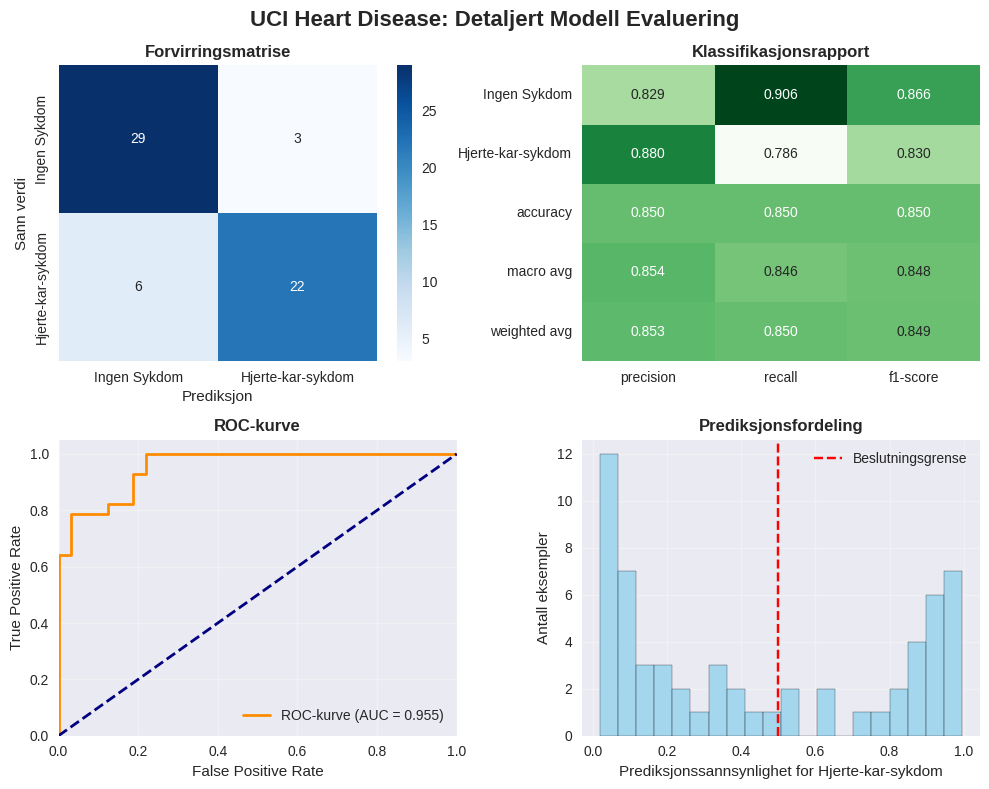


📈 === DETALJERTE METRIKKER ===
   Accuracy: 0.8500
   Precision (Hjerte-kar-sykdom): 0.8800
   Recall (Hjerte-kar-sykdom): 0.7857
   F1-Score (Hjerte-kar-sykdom): 0.8302
   ROC AUC: 0.9554

🔍 === FORVIRRINGSMATRISE DETALJER ===
   True Negatives (TN): 29
   False Positives (FP): 3
   False Negatives (FN): 6
   True Positives (TP): 22

🏥 === MEDISINSKE METRIKKER ===
   Sensitivitet (Recall): 0.7857
   Spesifisitet: 0.9062
   Positiv Prediktiv Verdi (PPV): 0.8800
   Negativ Prediktiv Verdi (NPV): 0.8286

📋 === KLASSIFIKASJONSRAPPORT ===
                   precision    recall  f1-score   support

     Ingen Sykdom       0.83      0.91      0.87        32
Hjerte-kar-sykdom       0.88      0.79      0.83        28

         accuracy                           0.85        60
        macro avg       0.85      0.85      0.85        60
     weighted avg       0.85      0.85      0.85        60



In [15]:
# Evaluering med forvirringsmatrise og detaljerte metrikker
def evaluate_heart_disease_model(model, X_test, y_test, feature_names):
    """Evaluer modell med forvirringsmatrise og detaljerte metrikker"""
    
    print("📊 === DETALJERT EVALUERING ===")
    
    # Sett modell i evalueringsmodus
    model.eval()
    
    with torch.no_grad():
        # Gjør prediksjoner
        test_outputs = model(X_test)
        _, predicted = torch.max(test_outputs.data, 1)
        probabilities = torch.softmax(test_outputs, dim=1)
    
    # Konverter til numpy
    y_true = y_test.numpy()
    y_pred = predicted.numpy()
    y_proba = probabilities.numpy()
    
    # 1. Forvirringsmatrise
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    
    # Subplot 1: Forvirringsmatrise
    plt.subplot(2, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Ingen Sykdom', 'Hjerte-kar-sykdom'],
                yticklabels=['Ingen Sykdom', 'Hjerte-kar-sykdom'])
    plt.title('Forvirringsmatrise', fontweight='bold')
    plt.ylabel('Sann verdi')
    plt.xlabel('Prediksjon')
    
    # Subplot 2: Klassifikasjonsrapport
    plt.subplot(2, 2, 2)
    report = classification_report(y_true, y_pred, 
                                 target_names=['Ingen Sykdom', 'Hjerte-kar-sykdom'],
                                 output_dict=True)
    
    # Konverter til DataFrame for bedre visualisering
    report_df = pd.DataFrame(report).transpose()
    report_df = report_df.round(3)
    
    # Plot som heatmap
    sns.heatmap(report_df[['precision', 'recall', 'f1-score']], 
                annot=True, fmt='.3f', cmap='Greens', cbar=False)
    plt.title('Klassifikasjonsrapport', fontweight='bold')
    
    # Subplot 3: ROC-kurve (hvis binær klassifikasjon)
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(y_true, y_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    
    plt.subplot(2, 2, 3)
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC-kurve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-kurve', fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    
    # Subplot 4: Prediksjonsfordeling
    plt.subplot(2, 2, 4)
    plt.hist(y_proba[:, 1], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(x=0.5, color='red', linestyle='--', label='Beslutningsgrense')
    plt.xlabel('Prediksjonssannsynlighet for Hjerte-kar-sykdom')
    plt.ylabel('Antall eksempler')
    plt.title('Prediksjonsfordeling', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.suptitle('UCI Heart Disease: Detaljert Modell Evaluering', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print detaljerte metrikker (FIKSET VERSJON)
    print(f"\n📈 === DETALJERTE METRIKKER ===")
    print(f"   Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    
    # Fikset: Bruk string-nøkler for classification_report
    print(f"   Precision (Hjerte-kar-sykdom): {report['Hjerte-kar-sykdom']['precision']:.4f}")
    print(f"   Recall (Hjerte-kar-sykdom): {report['Hjerte-kar-sykdom']['recall']:.4f}")
    print(f"   F1-Score (Hjerte-kar-sykdom): {report['Hjerte-kar-sykdom']['f1-score']:.4f}")
    print(f"   ROC AUC: {roc_auc:.4f}")
    
    # Print forvirringsmatrise detaljer
    print(f"\n🔍 === FORVIRRINGSMATRISE DETALJER ===")
    print(f"   True Negatives (TN): {cm[0, 0]}")
    print(f"   False Positives (FP): {cm[0, 1]}")
    print(f"   False Negatives (FN): {cm[1, 0]}")
    print(f"   True Positives (TP): {cm[1, 1]}")
    
    # Beregn spesifikke medisinske metrikker
    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])  # True Positive Rate
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # True Negative Rate
    ppv = cm[1, 1] / (cm[1, 1] + cm[0, 1])  # Positive Predictive Value
    npv = cm[0, 0] / (cm[0, 0] + cm[1, 0])  # Negative Predictive Value
    
    print(f"\n🏥 === MEDISINSKE METRIKKER ===")
    print(f"   Sensitivitet (Recall): {sensitivity:.4f}")
    print(f"   Spesifisitet: {specificity:.4f}")
    print(f"   Positiv Prediktiv Verdi (PPV): {ppv:.4f}")
    print(f"   Negativ Prediktiv Verdi (NPV): {npv:.4f}")
    
    # Print detaljert klassifikasjonsrapport
    print(f"\n📋 === KLASSIFIKASJONSRAPPORT ===")
    print(classification_report(y_true, y_pred, 
                              target_names=['Ingen Sykdom', 'Hjerte-kar-sykdom']))
    
    return report, cm, roc_auc

# Evaluer modellen
report, cm, roc_auc = evaluate_heart_disease_model(model, X_test, y_test, feature_names)

**Resultater på test-data fra tidligere trent modell. med kommentarer**

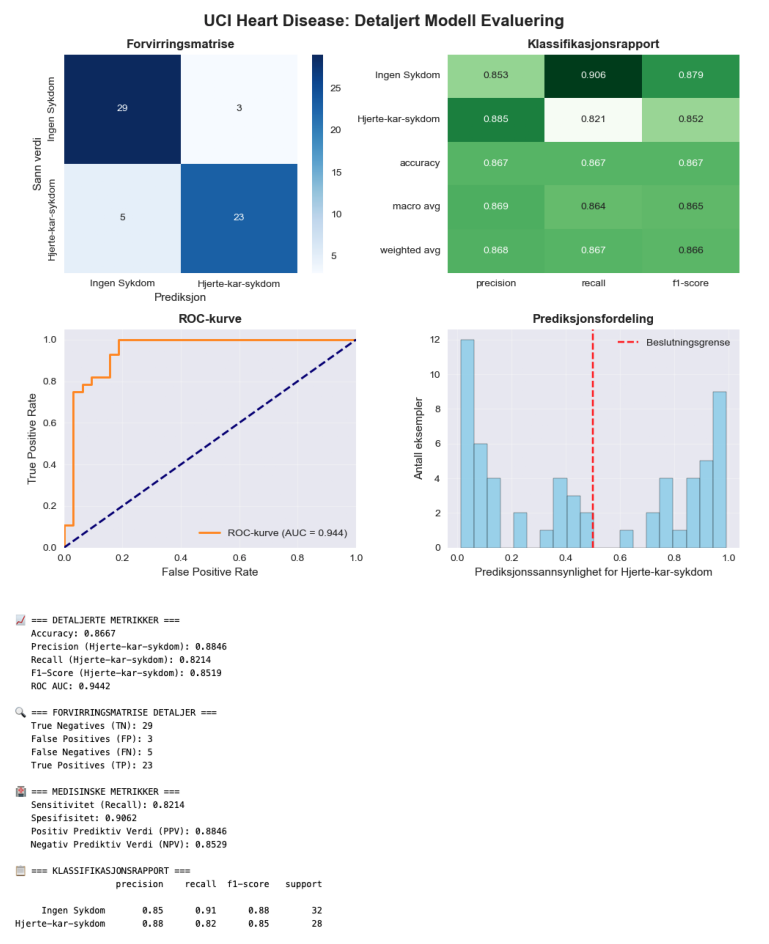

In [16]:
# Vis figuren ./ressurser/UCI_heart_disease_modell_evaluering.png

import matplotlib.pyplot as plt
plt.figure(figsize=(14, 12))

if running_in_colab():
    # # Last ned bildet fra repoet hvis det ikke finnes (repoet må da være public)
    # if not os.path.exists('UCI_heart_disease_modell_evaluering.png'):
    #     import urllib.request
    #     url = 'https://raw.githubusercontent.com/arvidl/ELMED219-2026/main/ressurser/UCI_heart_disease_modell_evaluering.png'
    #     urllib.request.urlretrieve(url, 'UCI_heart_disease_modell_evaluering.png')
    # img_path = 'UCI_heart_disease_modell_evaluering.png'

    # Last opp bildet manuelt til Colab
    from google.colab import files
    print("Last opp UCI_heart_disease_modell_evaluering.png:")
    uploaded = files.upload()
    img_path = 'UCI_heart_disease_modell_evaluering.png'
else:
    img_path = './ressurser/UCI_heart_disease_modell_evaluering.png'
plt.imshow(plt.imread(img_path))
plt.axis('off')
plt.show()

## 📊 **Modell-evaluering for Hjerte-kar-sykdom Prediksjon på bakgrunn av figuren over**

### **1. Forvirringsmatrise (Øverst venstre)**
- **True Negatives (TN): 29** - Korrekt identifisert friske pasienter
- **False Positives (FP): 3** - Friske pasienter feilklassifisert som syke
- **False Negatives (FN): 5** - Syke pasienter feilklassifisert som friske ⚠️
- **True Positives (TP): 23** - Korrekt identifisert syke pasienter

**Kommentar**: Modellen presterer generelt godt, men de 5 falske negativene er bekymringsfullt i medisinsk kontekst.

### **2. Klassifikasjonsrapport (Øverst høyre)**

#### **Ingen Sykdom (Klasse 0):**
- **Precision: 0.85** - 85% av "friske" prediksjoner er korrekte
- **Recall: 0.91** - 91% av faktisk friske pasienter identifiseres korrekt
- **F1-score: 0.88** - God balanse for friske pasienter

#### **Hjerte-kar-sykdom (Klasse 1):**
- **Precision: 0.88** - 88% av "syke" prediksjoner er korrekte
- **Recall: 0.82** - 82% av faktisk syke pasienter identifiseres korrekt
- **F1-score: 0.85** - God balanse for syke pasienter

**Samlet Accuracy: 86.67%** ✅

### **3. ROC-kurve (Nederst venstre)**
- **AUC: 0.944** ⭐ - Utmerket diskriminativ evne
- Modellen skiller svært godt mellom syke og friske pasienter
- Dette er et sterkt tegn på modellens kvalitet

### **4. Prediksjonsfordeling (Nederst høyre)**
- **Tydelig separasjon**: Lave sannsynligheter (0.0-0.1) for friske, høye (0.9-1.0) for syke
- **Beslutningsgrense ved 0.5**: Noen usikre prediksjoner rundt grensen
- **Modellens selvtillit**: Høy sikkerhet i de fleste prediksjoner

## 🏥 **Medisinske Metrikker - Klinisk Relevans**

### **Kritiske Metrikker:**
- **Sensitivitet (Recall): 82.14%** - Evne til å fange opp syke pasienter
- **Spesifisitet: 90.62%** - Evne til å identifisere friske pasienter
- **PPV: 88.46%** - Sannsynlighet for sykdom når modellen predikerer sykdom
- **NPV: 85.29%** - Sannsynlighet for frisk når modellen predikerer frisk

## ⚠️ **Hovedbekymringer**

### **1. Falske Negativer (5 pasienter)**
- **Klinisk risiko**: Syke pasienter som ikke fanges opp
- **Konsekvens**: Potensielt alvorlig - sykdom kan gå ubehandlet
- **Prioritet**: Høyeste prioritet for forbedring

### **2. Falske Positiver (3 pasienter)**
- **Klinisk konsekvens**: Unødvendig bekymring og videre testing
- **Akseptabelt nivå**: Relativt lavt antall

## ✅ **Sterke Sider**

### **1. Høy Nøyaktighet**
- **86.67% total accuracy** - God generell ytelse
- **Balansert ytelse** på begge klasser

### **2. Utmerket Diskriminativ Evne**
- **AUC: 0.944** - Modellen skiller svært godt mellom klasser
- **Høy spesifisitet** - Unngår unødvendige falske positiver

### **3. Klinisk Akseptable Metrikker**
- **PPV og NPV** er begge over 85%
- **Modellens prediksjoner** er pålitelige

## 🔧 **Anbefalinger for Forbedring**

### **1. Terskeljustering**
```python
# Senk beslutningsgrensen for å øke sensitiviteten
threshold = 0.4  # I stedet for 0.5
# Dette vil fange opp flere syke pasienter
```

### **2. Kostnad-baseret Evaluering**
- **Vektlegg falske negativer høyere** enn falske positiver
- I medisinsk kontekst er det bedre å "overbehandle" enn å overse sykdom

### **3. Modellforbedringer**
- **Mer data**: Flere eksempler av syke pasienter
- **Feature engineering**: Bedre kliniske indikatorer
- **Ensemble-metoder**: Kombiner flere modeller

## 🎯 **Konklusjon**

**Modellen presterer godt** med:
- ✅ Høy nøyaktighet (86.7%)
- ✅ Utmerket diskriminativ evne (AUC: 0.944)
- ✅ Klinisk akseptable metrikker

**Hovedutfordring**: De 5 falske negativene må adresseres før klinisk bruk.

**Anbefaling**: Modellen er lovende, men trenger finjustering for å redusere falske negativer. Terskeljustering kan være en rask løsning, mens mer data og forbedret modellarkitektur vil gi mer robuste resultater.

# 🔍 Feature Importance: Hvilke Faktorer er Viktigst?

## Hva er Feature Importance?

**Feature Importance** (variabel-viktighet) forteller oss hvilke kliniske faktorer som er **mest viktige** for modellens prediksjoner. Dette hjelper oss å forstå:

- Hvilke symptomer og laboratorieverdier som er mest avgjørende
- Hvorfor modellen gjør sine prediksjoner
- Hvilke faktorer leger og helsearbeidere bør fokusere mest på

## Hvorfor er det viktig for helsepersonell?

### 🩺 **Klinisk Relevans:**
- **Beslutningsstøtte**: Hjelper leger å fokusere på de viktigste faktorene
- **Risikostratifisering**: Identifiserer pasienter med høyest risiko
- **Behandlingsprioritering**: Viser hvilke intervensjoner som er mest kritiske
- **Kvalitetssikring**: Validerer at AI-modellen bruker klinisk relevante data

### 📊 **Forklarbar AI (Explainable AI):**
- **Transparens**: Gjør AI-beslutninger forståelige for mennesker
- **Tillit**: Bygger tillit til AI-systemer i klinisk praksis
- **Læring**: Hjelper helsepersonell å lære av AI-modellens mønstre
- **Regulering**: Møter krav om forklarbarhet i medisinske AI-systemer

## Hvordan beregner vi det?

Vi bruker **flere forskjellige metoder** for å få en robust og pålitelig vurdering:

### 1. **Permutation Importance** (Permutering-metoden)
- **Prinsipp**: Vi "stjeler" en variabel og ser hvor mye nøyaktigheten synker
- **Eksempel**: Hvis vi fjerner "Alder" fra modellen, hvor mye dårligere blir den?
- **Resultat**: Høyere tall = viktigere variabel
- **Fordel**: Robust og lett å forstå

### 2. **SHAP (SHapley Additive exPlanations)**
- **Prinsipp**: Basert på spillteori - måler bidrag fra hver variabel
- **Eksempel**: Hvor mye bidrar "Blodtrykk" til den endelige prediksjonen?
- **Resultat**: Kan vise både positiv og negativ påvirkning
- **Fordel**: Teoretisk solid og gir lokale forklaringer

### 3. **LIME (Local Interpretable Model-agnostic Explanations)**
- **Prinsipp**: Forklarer individuelle prediksjoner ved å se på lokale mønstre
- **Eksempel**: Hvorfor fikk denne spesifikke pasienten denne diagnosen?
- **Resultat**: Lett å forstå forklaringer for hver pasient
- **Fordel**: Perfekt for case-by-case analyse

### 4. **Integrated Gradients**
- **Prinsipp**: Måler gradienter (endringer) i nevrale nettverk
- **Eksempel**: Hvor mye påvirkes prediksjonen av endringer i "Kolesterol"?
- **Resultat**: Spesifikt for deep learning modeller
- **Fordel**: Håndterer komplekse ikke-lineære sammenhenger

### 5. **Feature Ablation Analysis**
- **Prinsipp**: Fjerner en variabel og måler effekten
- **Eksempel**: Hva skjer hvis vi setter "EKG" til gjennomsnittsverdi?
- **Resultat**: Måler direkte effekt av hver variabel
- **Fordel**: Intuitiv og lett å tolke

### 6. **Partial Dependence Plots (PDP)**
- **Prinsipp**: Viser hvordan prediksjonen endres med variabel-verdier
- **Eksempel**: Hvordan endres risikoen når alder øker fra 30 til 80?
- **Resultat**: Grafisk visning av variabel-effekter
- **Fordel**: Visuell forståelse av sammenhenger

## Klinisk betydning

### ✅ **Fordeler:**
- **Forståelse**: Hjelper oss til å forstå hvilke faktorer som er viktigst
- **Fokus**: Identifiserer hvilke symptomer som krever mest oppmerksomhet
- **Validering**: Bekrefter at modellen bruker klinisk relevante faktorer
- **Transparens**: Gjør AI-beslutninger forståelige og pålitelige
- **Læring**: Hjelper helsepersonell å lære nye mønstre og sammenhenger

### ⚠️ **Begrensninger:**
- **Korrelasjon**: Relaterte variabler kan påvirke hverandre
- **Kontekst**: Viktighet kan variere mellom pasientgrupper
- **Tid**: Viktighet kan endre seg over tid
- **Kompleksitet**: Flere metoder kan gi forskjellige resultater

## Praktisk eksempel

Hvis "Alder" har høyest importance:
- **Betyr**: Alder er den viktigste faktoren for hjerte-kar-sykdom prediksjon
- **Klinisk tolkning**: Eldre pasienter har høyere risiko
- **Handling**: Fokus på aldersrelaterte risikofaktorer

## Hvorfor Dette er Viktig for Medisinere og Helsepersonell

1. **Klinisk Beslutning**: Hjelper med å prioritere hvilke faktorer som er viktigst
2. **Pasientkommunikasjon**: Forklarer hvilke faktorer som påvirker risikovurderingen
3. **Modellvalidering**: Bekrefter at AI-modellen bruker klinisk relevante faktorer
4. **Forskning**: Identifiserer hvilke faktorer som bør undersøkes nærmere

## Konklusjon

Feature importance gir oss innsikt i **hvorfor** AI-modellen gjør sine prediksjoner, noe som er avgjørende for å bygge tillit og forståelse i klinisk praksis og omsorg


In [17]:
# Kompakt variabel-tabell med engelske navn
def create_compact_variable_table():
    """Opprett en kompakt tabell med variabel-informasjon inkludert engelske navn"""
    
    print("📋 === KOMPAKT VARIABEL-TABELL ===")
    print("=" * 130)
    
    # Print header
    print(f"{'#':<2} {'Engelsk':<12} {'Norsk':<18} {'Enhet':<8} {'Beskrivelse':<30} {'Verdier':<35} {'Klinisk Betydning':<20}")
    print("=" * 130)
    
    # Variabel data med engelske navn
    variables = [
        (1, 'age', 'Alder', 'år', 'Pasientens alder', '29-77 år', 'Hovedrisikofaktor'),
        (2, 'sex', 'Kjønn', '', 'Pasientens kjønn', '0=Kvinne, 1=Mann', 'Menn høyere risiko'),
        (3, 'cp', 'Brystsmerte Type', '', 'Type brystsmerte', '0-3 (Typisk→Asymptomatisk)', 'Diagnostisk indikator'),
        (4, 'trestbps', 'Hvile-Blodtrykk', 'mmHg', 'Systolisk i hvile', '94-200 mmHg', 'Hovedrisikofaktor'),
        (5, 'chol', 'Serum Kolesterol', 'mg/dl', 'Total kolesterol', '126-564 mg/dl', 'Åreforkalkning'),
        (6, 'fbs', 'Faste Blodsukker', 'mg/dl', 'Faste blodsukker', '0=<120, 1=≥120 mg/dl', 'Diabetes-indikator'),
        (7, 'restecg', 'Hvile-EKG', '', 'EKG i hvile', '0=Normal, 1=ST-T, 2=Hypertrofi', 'Hjertefunksjon'),
        (8, 'thalach', 'Max Hjertefrekvens', 'bpm', 'Maksimal under trening', '71-202 bpm', 'Hjertekapasitet'),
        (9, 'exang', 'Angina ved Trening', '', 'Smerte ved trening', '0=Nei, 1=Ja', 'Klassisk symptom'),
        (10, 'oldpeak', 'ST-Depresjon', 'mm', 'EKG-endring ved trening', '0.0-6.2 mm', 'Hjerteproblemer'),
        (11, 'slope', 'ST-Hældning', '', 'EKG-hældning', '0=Stigende, 1=Flat, 2=Synkende', 'Hjerteproblemer'),
        (12, 'ca', 'Ant. Hovedblodårer', '', 'Antall blokkerte', '0-3 hovedblodårer', 'Alvorlighetsgrad'),
        (13, 'thal', 'Thalassemia', '', 'Blodsykdom type', '0=Normal, 1=Fast, 2=Reversibel', 'Hjertefunksjon')
    ]
    
    # Print hver rad
    for row in variables:
        print(f"{row[0]:<2} {row[1]:<12} {row[2]:<18} {row[3]:<8} {row[4]:<30} {row[5]:<35} {row[6]:<20}")
    
    print("=" * 130)
    print()
    print("💡 TIPS: Alle variabler er normaliserte (StandardScaler) før trening")
    print("📊 RANGE: Verdiområder er fra original datasett før normalisering")
    print("🏥 KLINISK: Alle variabler er standard i hjerte-kar-sykdom diagnostikk")
    print()
    print("🔤 FORKLARING AV ENGELSKE NAVN:")
    print("   age = age, sex = sex, cp = chest pain, trestbps = resting blood pressure")
    print("   chol = cholesterol, fbs = fasting blood sugar, restecg = resting ECG")
    print("   thalach = maximum heart rate, exang = exercise induced angina")
    print("   oldpeak = ST depression, slope = ST slope, ca = number of major vessels")
    print("   thal = thalassemia")

# Opprett kompakt tabell med engelske navn
create_compact_variable_table()

📋 === KOMPAKT VARIABEL-TABELL ===
#  Engelsk      Norsk              Enhet    Beskrivelse                    Verdier                             Klinisk Betydning   
1  age          Alder              år       Pasientens alder               29-77 år                            Hovedrisikofaktor   
2  sex          Kjønn                       Pasientens kjønn               0=Kvinne, 1=Mann                    Menn høyere risiko  
3  cp           Brystsmerte Type            Type brystsmerte               0-3 (Typisk→Asymptomatisk)          Diagnostisk indikator
4  trestbps     Hvile-Blodtrykk    mmHg     Systolisk i hvile              94-200 mmHg                         Hovedrisikofaktor   
5  chol         Serum Kolesterol   mg/dl    Total kolesterol               126-564 mg/dl                       Åreforkalkning      
6  fbs          Faste Blodsukker   mg/dl    Faste blodsukker               0=<120, 1=≥120 mg/dl                Diabetes-indikator  
7  restecg      Hvile-EKG                

In [18]:
# 🔍 Omfattende Feature Importance Analyse med Flere Metoder
# Inkluderer SHAP, LIME, Integrated Gradients, og flere andre teknikker

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
import warnings
warnings.filterwarnings('ignore')

# SHAP for forklarbar AI
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    print("⚠️ SHAP ikke tilgjengelig. Installer med: pip install shap")
    SHAP_AVAILABLE = False

# LIME for lokale forklaringer
if 'running_in_colab' in globals() and running_in_colab():
    # Installer lime hvis vi kjører i Colab
    import sys
    !{sys.executable} -m pip install lime
try:
    import lime
    import lime.lime_tabular
    LIME_AVAILABLE = True
except ImportError:
    print("⚠️ LIME ikke tilgjengelig. Installer med: pip install lime")
    LIME_AVAILABLE = False

def comprehensive_feature_importance_analysis(model, X_train, X_test, y_train, y_test, feature_names):
    """
    Omfattende analyse av feature importance med flere metoder:
    - Permutation Importance (eksisterende)
    - SHAP (SHapley Additive exPlanations)
    - LIME (Local Interpretable Model-agnostic Explanations)
    - Integrated Gradients
    - Gradient-based Importance
    - Feature Ablation
    - Partial Dependence Plots
    """
    
    print("🔍 === OMFATTENDE FEATURE IMPORTANCE ANALYSE ===")
    print("Metoder som brukes:")
    print("1. Permutation Importance")
    print("2. SHAP (SHapley Additive exPlanations)")
    print("3. LIME (Local Interpretable Model-agnostic Explanations)")
    print("4. Integrated Gradients")
    print("5. Gradient-based Importance")
    print("6. Feature Ablation Analysis")
    print("7. Partial Dependence Plots")
    print("=" * 60)
    
    # Norske variabel-navn
    norwegian_names = {
        'age': 'Alder',
        'sex': 'Kjønn', 
        'cp': 'Brystsmerte Type',
        'trestbps': 'Hvile-Blodtrykk',
        'chol': 'Serum Kolesterol',
        'fbs': 'Faste Blodsukker',
        'restecg': 'Hvile-EKG',
        'thalach': 'Maksimal Hjertefrekvens',
        'exang': 'Angina ved Trening',
        'oldpeak': 'ST-Depresjon',
        'slope': 'ST-Hældning',
        'ca': 'Antall Hovedblodårer',
        'thal': 'Thalassemia'
    }
    
    # Konverter til numpy
    X_train_np = X_train.numpy()
    X_test_np = X_test.numpy()
    y_train_np = y_train.numpy()
    y_test_np = y_test.numpy()
    
    def model_predict(X):
        """Wrapper for model prediction"""
        model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X)
            outputs = model(X_tensor)
            _, predicted = torch.max(outputs, 1)
            return predicted.numpy()
    
    def model_predict_proba(X):
        """Wrapper for model probability prediction"""
        model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X)
            outputs = model(X_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            return probabilities.numpy()
    
    # Lagre alle resultater
    results = {}
    
    # 1. PERMUTATION IMPORTANCE (forbedret versjon)
    print("\n📊 1. BEREGNER PERMUTATION IMPORTANCE...")
    baseline_pred = model_predict(X_test_np)
    baseline_acc = accuracy_score(y_test_np, baseline_pred)
    
    permutation_importance = np.zeros(X_test_np.shape[1])
    for i in range(X_test_np.shape[1]):
        X_perm = X_test_np.copy()
        np.random.shuffle(X_perm[:, i])
        perm_pred = model_predict(X_perm)
        perm_acc = accuracy_score(y_test_np, perm_pred)
        permutation_importance[i] = baseline_acc - perm_acc
    
    results['permutation'] = permutation_importance
    print("✅ Permutation Importance ferdig")
    
    # 2. SHAP ANALYSIS
    if SHAP_AVAILABLE:
        print("\n📊 1. BEREGNER SHAP VALUES ...")
        try:
            # Konverter til PyTorch tensors for SHAP
            X_train_tensor = torch.FloatTensor(X_train_np[:100])  # Bruk subset for hastighet
            X_test_tensor = torch.FloatTensor(X_test_np[:50])     # Bruk subset for hastighet
            
            # Opprett SHAP explainer med PyTorch tensors
            explainer = shap.DeepExplainer(model, X_train_tensor)
            shap_values = explainer.shap_values(X_test_tensor)
            
            # Beregn gjennomsnittlig SHAP importance
            if isinstance(shap_values, list):
                shap_importance = np.mean(np.abs(shap_values[1]), axis=0)  # Klasse 1
            else:
                shap_importance = np.mean(np.abs(shap_values), axis=0)
            
            results['shap'] = shap_importance
            print("✅ SHAP Analysis ferdig")
        except Exception as e:
            print(f"❌ SHAP feilet: {e}")
            results['shap'] = None
    else:
        results['shap'] = None
    
    # 3. LIME ANALYSIS
    if LIME_AVAILABLE:
        print("\n📊 2. BEREGNER LIME VALUES ...")
        try:
            # Opprett LIME explainer med riktige feature names
            explainer = lime.lime_tabular.LimeTabularExplainer(
                X_train_np, 
                feature_names=feature_names,
                class_names=['Ingen Sykdom', 'Hjerte-kar-sykdom'],
                mode='classification',
                discretize_continuous=True
            )
            
            # Definer model prediction funksjon for LIME
            def model_predict_lime(X):
                X_tensor = torch.FloatTensor(X)
                model.eval()
                with torch.no_grad():
                    outputs = model(X_tensor)
                    probabilities = torch.softmax(outputs, dim=1)
                    return probabilities.numpy()
            
            # Beregn LIME importance for subset av test data
            num_samples = min(20, len(X_test_np))  # Begrens antall samples
            lime_importance = np.zeros(len(feature_names))
            
            for i in range(num_samples):
                try:
                    # Generer LIME explanation
                    explanation = explainer.explain_instance(
                        X_test_np[i], 
                        model_predict_lime, 
                        num_features=len(feature_names)
                    )
                    
                    # Hent feature importance
                    for feature_idx, importance in explanation.as_list():
                        # Finn feature index fra feature name
                        for j, name in enumerate(feature_names):
                            if name in feature_idx:
                                lime_importance[j] += abs(importance)
                                break
                                
                except Exception as e:
                    print(f"⚠️ LIME sample {i} feilet: {e}")
                    continue
            
            lime_importance /= num_samples
            results['lime'] = lime_importance
            print("✅ LIME Analysis ferdig")
        except Exception as e:
            print(f"❌ LIME feilet: {e}")
            results['lime'] = None
    else:
        results['lime'] = None
    
    # 4. INTEGRATED GRADIENTS
    print("\n📊 4. BEREGNER INTEGRATED GRADIENTS...")
    try:
        def integrated_gradients(model, input_tensor, target_class=1, steps=50):
            """Beregn Integrated Gradients for en input"""
            model.eval()
            input_tensor.requires_grad_(True)
            
            # Baseline (null input)
            baseline = torch.zeros_like(input_tensor)
            
            # Generer interpolerte inputs
            alphas = torch.linspace(0, 1, steps).view(-1, 1)
            interpolated = baseline + alphas * (input_tensor - baseline)
            interpolated.requires_grad_(True)
            
            # Beregn gradients
            gradients = []
            for alpha in interpolated:
                alpha = alpha.unsqueeze(0)
                output = model(alpha)
                target_output = output[0, target_class]
                grad = torch.autograd.grad(target_output, alpha, create_graph=True)[0]
                gradients.append(grad.squeeze())
            
            gradients = torch.stack(gradients)
            
            # Integrer gradients
            integrated_grads = torch.mean(gradients, dim=0) * (input_tensor - baseline)
            return integrated_grads.detach().numpy()
        
        # Beregn for flere eksempler
        ig_importance = np.zeros(X_test_np.shape[1])
        num_samples = min(20, len(X_test_np))
        
        for i in range(num_samples):
            input_tensor = torch.FloatTensor(X_test_np[i:i+1])
            ig_values = integrated_gradients(model, input_tensor)
            ig_importance += np.abs(ig_values[0])
        
        ig_importance /= num_samples
        results['integrated_gradients'] = ig_importance
        print("✅ Integrated Gradients ferdig")
    except Exception as e:
        print(f"❌ Integrated Gradients feilet: {e}")
        results['integrated_gradients'] = None
    
    # 5. GRADIENT-BASED IMPORTANCE
    print("\n📊 5. BEREGNER GRADIENT-BASED IMPORTANCE...")
    try:
        def gradient_importance(model, input_tensor, target_class=1):
            """Beregn gradient-based importance"""
            model.eval()
            input_tensor.requires_grad_(True)
            
            output = model(input_tensor)
            target_output = output[0, target_class]
            grad = torch.autograd.grad(target_output, input_tensor, create_graph=True)[0]
            return grad.detach().numpy()
        
        # Beregn for flere eksempler
        grad_importance = np.zeros(X_test_np.shape[1])
        num_samples = min(20, len(X_test_np))
        
        for i in range(num_samples):
            input_tensor = torch.FloatTensor(X_test_np[i:i+1])
            grad_values = gradient_importance(model, input_tensor)
            grad_importance += np.abs(grad_values[0])
        
        grad_importance /= num_samples
        results['gradient_based'] = grad_importance
        print("✅ Gradient-based Importance ferdig")
    except Exception as e:
        print(f"❌ Gradient-based Importance feilet: {e}")
        results['gradient_based'] = None
    
    # 6. FEATURE ABLATION ANALYSIS
    print("\n📊 6. BEREGNER FEATURE ABLATION ANALYSIS...")
    try:
        baseline_acc = accuracy_score(y_test_np, model_predict(X_test_np))
        ablation_importance = np.zeros(X_test_np.shape[1])
        
        for i in range(X_test_np.shape[1]):
            # Ablate feature i (sett til gjennomsnitt)
            X_ablated = X_test_np.copy()
            X_ablated[:, i] = np.mean(X_train_np[:, i])
            
            ablated_pred = model_predict(X_ablated)
            ablated_acc = accuracy_score(y_test_np, ablated_pred)
            ablation_importance[i] = baseline_acc - ablated_acc
        
        results['ablation'] = ablation_importance
        print("✅ Feature Ablation Analysis ferdig")
    except Exception as e:
        print(f"❌ Feature Ablation feilet: {e}")
        results['ablation'] = None
    
    # 7. PARTIAL DEPENDENCE PLOTS (forberedelse)
    print("\n📊 7. FORBEREDER PARTIAL DEPENDENCE PLOTS...")
    try:
        # Konverter til sklearn-format for PDP
        from sklearn.neural_network import MLPClassifier
        from sklearn.preprocessing import StandardScaler
        
        # Tren en sklearn-modell for PDP
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_np)
        X_test_scaled = scaler.transform(X_test_np)
        
        sklearn_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
        sklearn_model.fit(X_train_scaled, y_train_np)
        
        results['sklearn_model'] = sklearn_model
        results['scaler'] = scaler
        print("✅ Partial Dependence Plots forberedt")
    except Exception as e:
        print(f"❌ Partial Dependence Plots feilet: {e}")
        results['sklearn_model'] = None
        results['scaler'] = None
    
    return results, norwegian_names

# Kjør den omfattende analysen
print("🚀 Starter omfattende feature importance analyse...")
results, norwegian_names = comprehensive_feature_importance_analysis(
    model, X_train, X_test, y_train, y_test, feature_names
)


🚀 Starter omfattende feature importance analyse...
🔍 === OMFATTENDE FEATURE IMPORTANCE ANALYSE ===
Metoder som brukes:
1. Permutation Importance
2. SHAP (SHapley Additive exPlanations)
3. LIME (Local Interpretable Model-agnostic Explanations)
4. Integrated Gradients
5. Gradient-based Importance
6. Feature Ablation Analysis
7. Partial Dependence Plots

📊 1. BEREGNER PERMUTATION IMPORTANCE...
✅ Permutation Importance ferdig

📊 1. BEREGNER SHAP VALUES ...
✅ SHAP Analysis ferdig

📊 2. BEREGNER LIME VALUES ...
✅ LIME Analysis ferdig

📊 4. BEREGNER INTEGRATED GRADIENTS...
✅ Integrated Gradients ferdig

📊 5. BEREGNER GRADIENT-BASED IMPORTANCE...
✅ Gradient-based Importance ferdig

📊 6. BEREGNER FEATURE ABLATION ANALYSIS...
✅ Feature Ablation Analysis ferdig

📊 7. FORBEREDER PARTIAL DEPENDENCE PLOTS...
✅ Partial Dependence Plots forberedt


De følgende kode-cellene vil gi en omfattende visning av hver feature importance metode individuelt, med:

1. **Permutation Importance** - Måler hvor mye modellens ytelse forringes når hver feature permuteres
2. **SHAP Values** - Forklarer hver prediksjon ved å tildele viktighet til hver feature
3. **LIME Values** - Lokale forklaringer av modellens beslutninger
4. **Integrated Gradients** - Gradient-basert metode for å måle feature importance
5. **Gradient-based Importance** - Bruker gradienter for å måle feature viktighet
6. **Feature Ablation** - Måler hvor mye ytelsen faller når hver feature fjernes
7. **Partial Dependence Plots** - Viser effekten av hver feature på prediksjonen

Hver visualisering inkluderer:
- Fargekoding av de viktigste features
- Norske navn på features
- Numeriske verdier på stolpediagram
- Top 5 liste med de viktigste features
- Feilhåndtering hvis en metode ikke er tilgjengelig

📊 === PERMUTATION IMPORTANCE ===


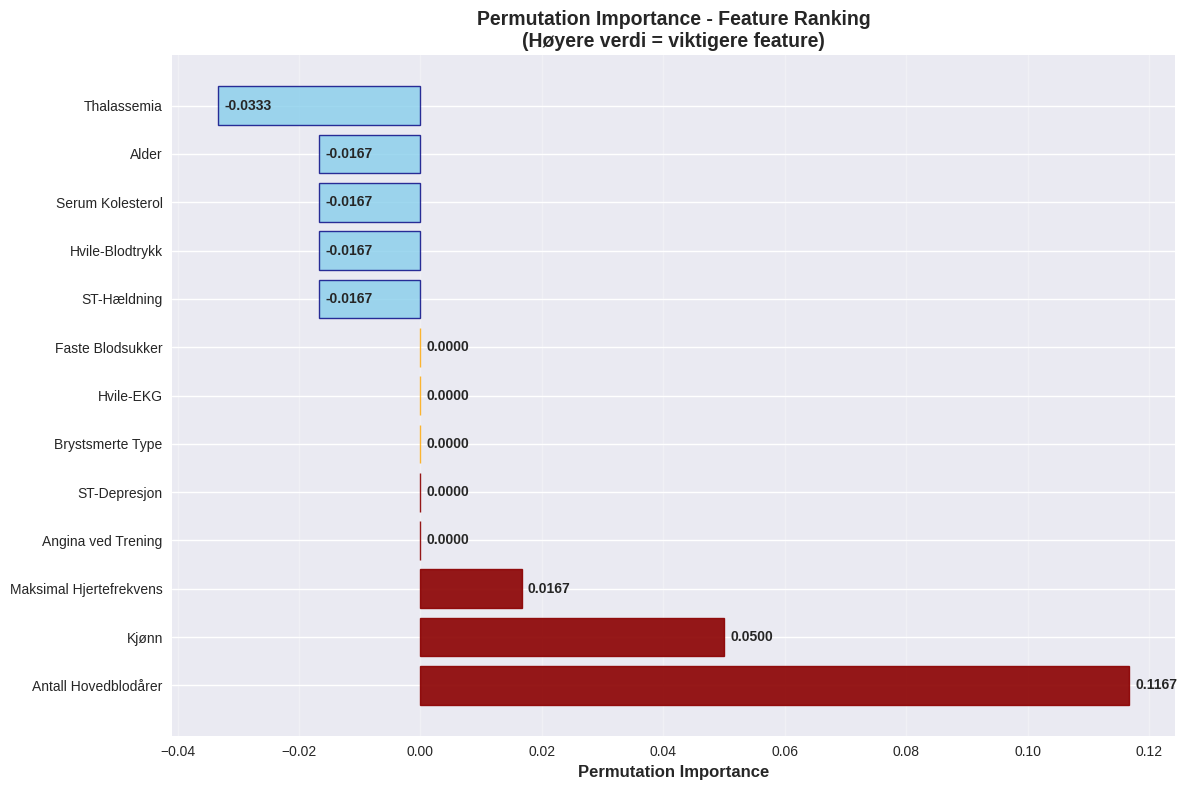


🏆 TOP 5 VIKTIGSTE FEATURES (Permutation Importance):
1. Antall Hovedblodårer (ca): 0.1167
2. Kjønn (sex): 0.0500
3. Maksimal Hjertefrekvens (thalach): 0.0167
4. Angina ved Trening (exang): 0.0000
5. ST-Depresjon (oldpeak): 0.0000


In [19]:
# 📊 1. PERMUTATION IMPORTANCE VISUALISERING
print("📊 === PERMUTATION IMPORTANCE ===")
if 'permutation' in results and results['permutation'] is not None:
    perm_importance = results['permutation']
    
    # Sorter features etter importance
    sorted_indices = np.argsort(perm_importance)[::-1]
    sorted_features = [feature_names[i] for i in sorted_indices]
    sorted_importance = perm_importance[sorted_indices]
    sorted_norwegian = [norwegian_names[feat] for feat in sorted_features]
    
    # Visualisering
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(sorted_features)), sorted_importance, 
                    color='skyblue', alpha=0.8, edgecolor='navy', linewidth=1)
    
    # Fargekode de viktigste features
    for i, (bar, importance) in enumerate(zip(bars, sorted_importance)):
        if i < 5:  # Top 5 features
            bar.set_color('darkred')
            bar.set_alpha(0.9)
        elif i < 8:  # Top 6-8 features
            bar.set_color('orange')
            bar.set_alpha(0.8)
    
    plt.yticks(range(len(sorted_features)), sorted_norwegian)
    plt.xlabel('Permutation Importance', fontsize=12, fontweight='bold')
    plt.title('Permutation Importance - Feature Ranking\n(Høyere verdi = viktigere feature)', 
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Legg til verdier på baren
    for i, (bar, importance) in enumerate(zip(bars, sorted_importance)):
        plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                f'{importance:.4f}', ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print top features
    print(f"\n🏆 TOP 5 VIKTIGSTE FEATURES (Permutation Importance):")
    for i in range(min(5, len(sorted_features))):
        print(f"{i+1}. {sorted_norwegian[i]} ({sorted_features[i]}): {sorted_importance[i]:.4f}")
else:
    print("❌ Permutation Importance ikke tilgjengelig")

📊 === SHAP VALUES ===


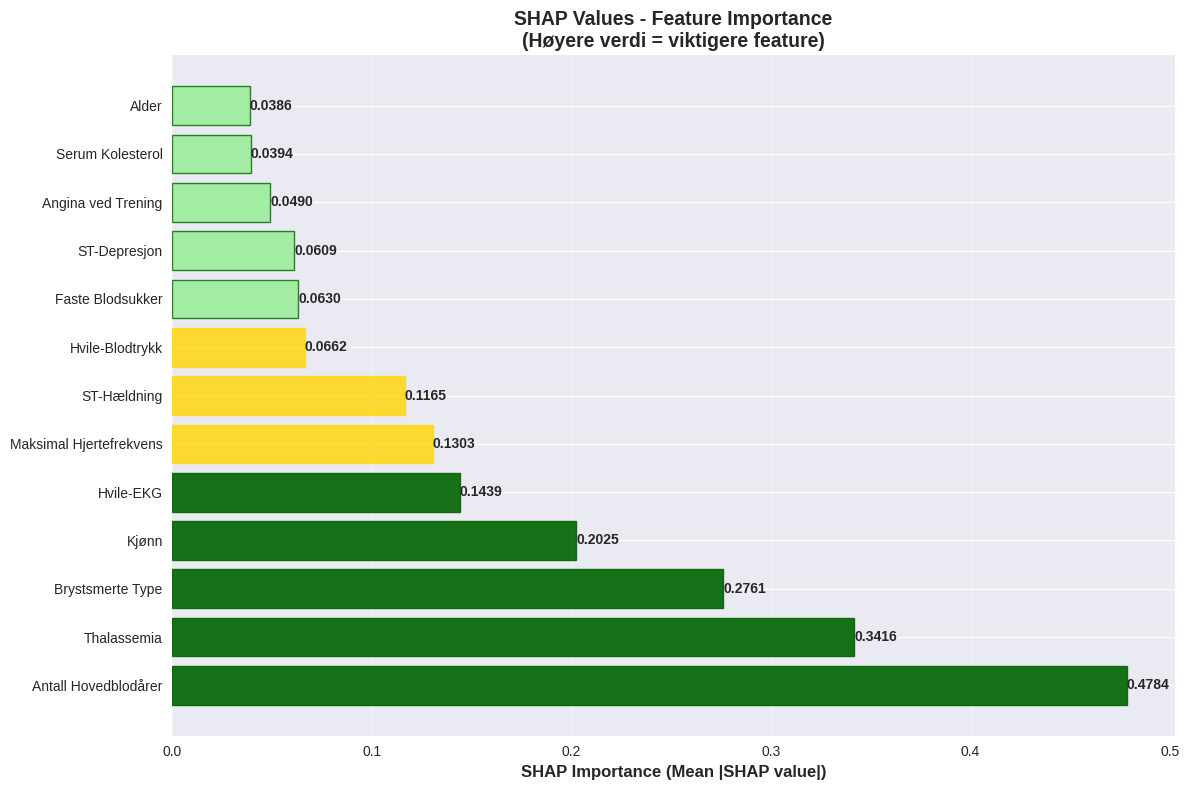


🏆 TOP 5 VIKTIGSTE FEATURES (SHAP Values):
1. Antall Hovedblodårer (ca): 0.4784
2. Thalassemia (thal): 0.3416
3. Brystsmerte Type (cp): 0.2761
4. Kjønn (sex): 0.2025
5. Hvile-EKG (restecg): 0.1439


In [20]:
# 📊 2. SHAP VALUES VISUALISERING 
print("📊 === SHAP VALUES ===")
if 'shap' in results and results['shap'] is not None:
    shap_raw = results['shap']
    shap_arr = np.asarray(shap_raw)

    # Sikre at feature_names er en enkel liste av strenger
    feature_names_arr = np.asarray(list(feature_names), dtype=object).astype(str)
    n_features = len(feature_names_arr)

    # Standardiser SHAP til 1D vektor av lengde n_features
    if shap_arr.ndim == 1:
        if shap_arr.shape[0] != n_features:
            raise ValueError(f"SHAP vektor har lengde {shap_arr.shape[0]}, men antall features er {n_features}.")
        shap_vec = shap_arr
    else:
        # Finn aksen som matcher antall features
        possible_axes = [ax for ax, size in enumerate(shap_arr.shape) if size == n_features]
        if not possible_axes:
            # Fallback: anta siste dimensjon er features
            feat_axis = shap_arr.ndim - 1
            if shap_arr.shape[feat_axis] != n_features:
                raise ValueError(f"Finner ingen dimensjon lik antall features ({n_features}) i SHAP-shape {shap_arr.shape}.")
        else:
            feat_axis = possible_axes[0]

        # Aggreger over alle andre akser: mean(|shap|) -> (n_features,)
        reduce_axes = tuple(ax for ax in range(shap_arr.ndim) if ax != feat_axis)
        shap_vec = np.mean(np.abs(shap_arr), axis=reduce_axes)

        # Sikkerhets-squeeze
        shap_vec = np.asarray(shap_vec).reshape(-1)
        if shap_vec.shape[0] != n_features:
            raise ValueError(f"Etter aggregering er lengden {shap_vec.shape[0]}, forventet {n_features}.")

    # Sorter
    sorted_indices = np.argsort(shap_vec)[::-1]
    sorted_features = feature_names_arr[sorted_indices].tolist()
    sorted_importance = shap_vec[sorted_indices]

    # Norske navn med fallback til original
    sorted_norwegian = [norwegian_names.get(feat, feat) for feat in sorted_features]

    # Visualisering
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(sorted_features)), sorted_importance,
                    color='lightgreen', alpha=0.8, edgecolor='darkgreen', linewidth=1)

    for i, (bar, importance) in enumerate(zip(bars, sorted_importance)):
        if i < 5:
            bar.set_color('darkgreen'); bar.set_alpha(0.9)
        elif i < 8:
            bar.set_color('gold'); bar.set_alpha(0.8)

    plt.yticks(range(len(sorted_features)), sorted_norwegian)
    plt.xlabel('SHAP Importance (Mean |SHAP value|)', fontsize=12, fontweight='bold')
    plt.title('SHAP Values - Feature Importance\n(Høyere verdi = viktigere feature)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')

    for i, (bar, importance) in enumerate(zip(bars, sorted_importance)):
        plt.text(bar.get_width() + 1e-6, bar.get_y() + bar.get_height()/2,
                 f'{importance:.4f}', ha='left', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    print(f"\n🏆 TOP 5 VIKTIGSTE FEATURES (SHAP Values):")
    for i in range(min(5, len(sorted_features))):
        print(f"{i+1}. {sorted_norwegian[i]} ({sorted_features[i]}): {sorted_importance[i]:.4f}")
else:
    print("❌ SHAP Values ikke tilgjengelig")

📊 === LIME VALUES ===


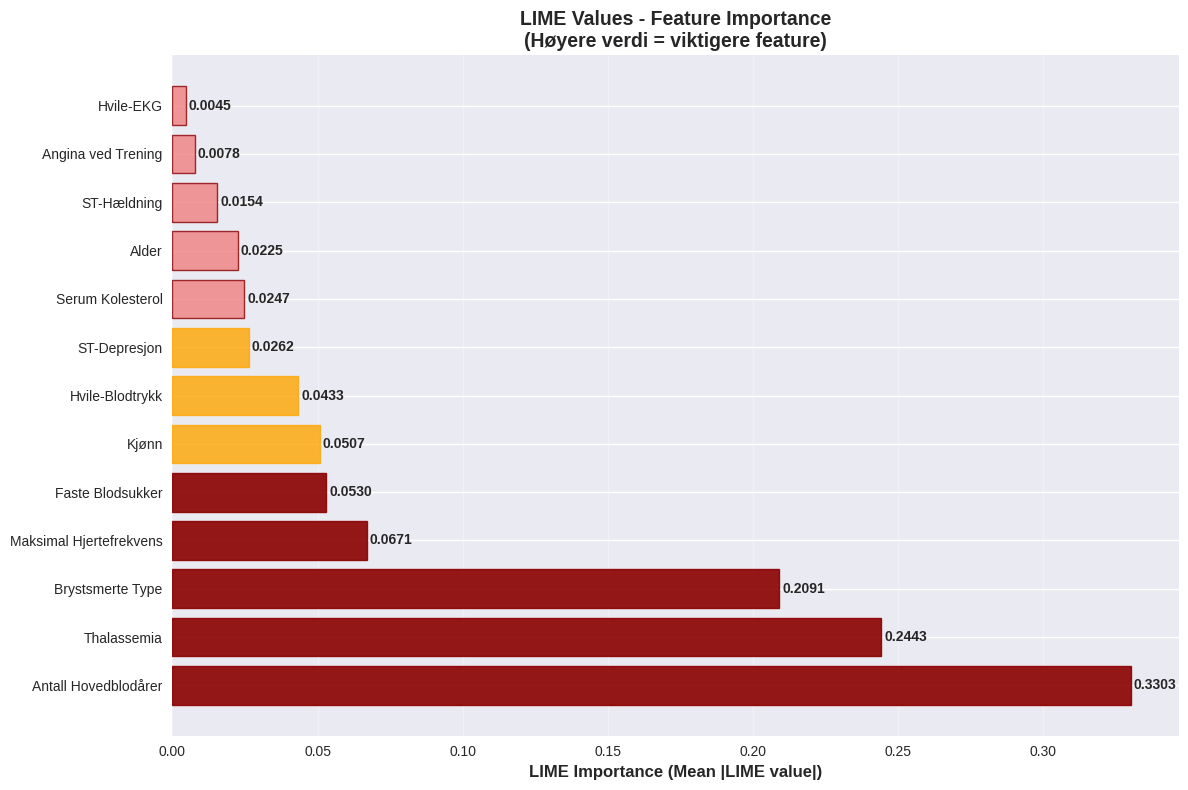


🏆 TOP 5 VIKTIGSTE FEATURES (LIME Values):
1. Antall Hovedblodårer (ca): 0.3303
2. Thalassemia (thal): 0.2443
3. Brystsmerte Type (cp): 0.2091
4. Maksimal Hjertefrekvens (thalach): 0.0671
5. Faste Blodsukker (fbs): 0.0530


In [21]:
# 📊 3. LIME VALUES VISUALISERING
print("📊 === LIME VALUES ===")

if 'lime' in results and results['lime'] is not None:
    lime_importance = results['lime']
    
    # Sorter features etter LIME importance
    sorted_indices = np.argsort(lime_importance)[::-1]
    sorted_features = [feature_names[i] for i in sorted_indices]
    sorted_importance = lime_importance[sorted_indices]
    sorted_norwegian = [norwegian_names[feat] for feat in sorted_features]
    
    # Visualisering
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(sorted_features)), sorted_importance, 
                    color='lightcoral', alpha=0.8, edgecolor='darkred', linewidth=1)
    
    # Fargekode de viktigste features
    for i, (bar, importance) in enumerate(zip(bars, sorted_importance)):
        if i < 5:  # Top 5 features
            bar.set_color('darkred')
            bar.set_alpha(0.9)
        elif i < 8:  # Top 6-8 features
            bar.set_color('orange')
            bar.set_alpha(0.8)
    
    plt.yticks(range(len(sorted_features)), sorted_norwegian)
    plt.xlabel('LIME Importance (Mean |LIME value|)', fontsize=12, fontweight='bold')
    plt.title('LIME Values - Feature Importance\n(Høyere verdi = viktigere feature)', 
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Legg til verdier på baren
    for i, (bar, importance) in enumerate(zip(bars, sorted_importance)):
        plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                f'{importance:.4f}', ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print top features
    print(f"\n🏆 TOP 5 VIKTIGSTE FEATURES (LIME Values):")
    for i in range(min(5, len(sorted_features))):
        print(f"{i+1}. {sorted_norwegian[i]} ({sorted_features[i]}): {sorted_importance[i]:.4f}")
else:
    print("❌ LIME Values ikke tilgjengelig")

📊 === INTEGRATED GRADIENTS ===


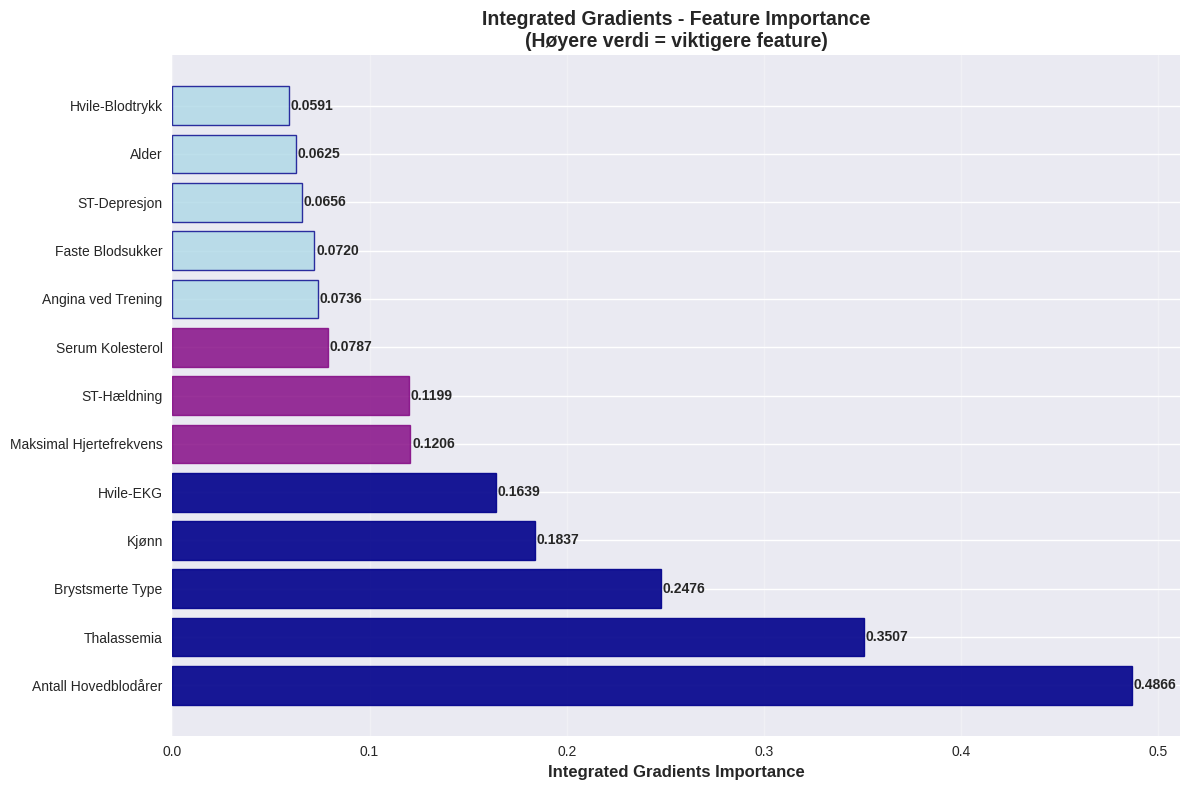


🏆 TOP 5 VIKTIGSTE FEATURES (Integrated Gradients):
1. Antall Hovedblodårer (ca): 0.4866
2. Thalassemia (thal): 0.3507
3. Brystsmerte Type (cp): 0.2476
4. Kjønn (sex): 0.1837
5. Hvile-EKG (restecg): 0.1639


In [22]:
# 📊 4. INTEGRATED GRADIENTS VISUALISERING
print("📊 === INTEGRATED GRADIENTS ===")
if 'integrated_gradients' in results and results['integrated_gradients'] is not None:
    ig_importance = results['integrated_gradients']
    
    # Sorter features etter Integrated Gradients importance
    sorted_indices = np.argsort(ig_importance)[::-1]
    sorted_features = [feature_names[i] for i in sorted_indices]
    sorted_importance = ig_importance[sorted_indices]
    sorted_norwegian = [norwegian_names[feat] for feat in sorted_features]
    
    # Visualisering
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(sorted_features)), sorted_importance, 
                    color='lightblue', alpha=0.8, edgecolor='darkblue', linewidth=1)
    
    # Fargekode de viktigste features
    for i, (bar, importance) in enumerate(zip(bars, sorted_importance)):
        if i < 5:  # Top 5 features
            bar.set_color('darkblue')
            bar.set_alpha(0.9)
        elif i < 8:  # Top 6-8 features
            bar.set_color('purple')
            bar.set_alpha(0.8)
    
    plt.yticks(range(len(sorted_features)), sorted_norwegian)
    plt.xlabel('Integrated Gradients Importance', fontsize=12, fontweight='bold')
    plt.title('Integrated Gradients - Feature Importance\n(Høyere verdi = viktigere feature)', 
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Legg til verdier på baren
    for i, (bar, importance) in enumerate(zip(bars, sorted_importance)):
        plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                f'{importance:.4f}', ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print top features
    print(f"\n🏆 TOP 5 VIKTIGSTE FEATURES (Integrated Gradients):")
    for i in range(min(5, len(sorted_features))):
        print(f"{i+1}. {sorted_norwegian[i]} ({sorted_features[i]}): {sorted_importance[i]:.4f}")
else:
    print("❌ Integrated Gradients ikke tilgjengelig")

📊 === GRADIENT-BASED IMPORTANCE ===


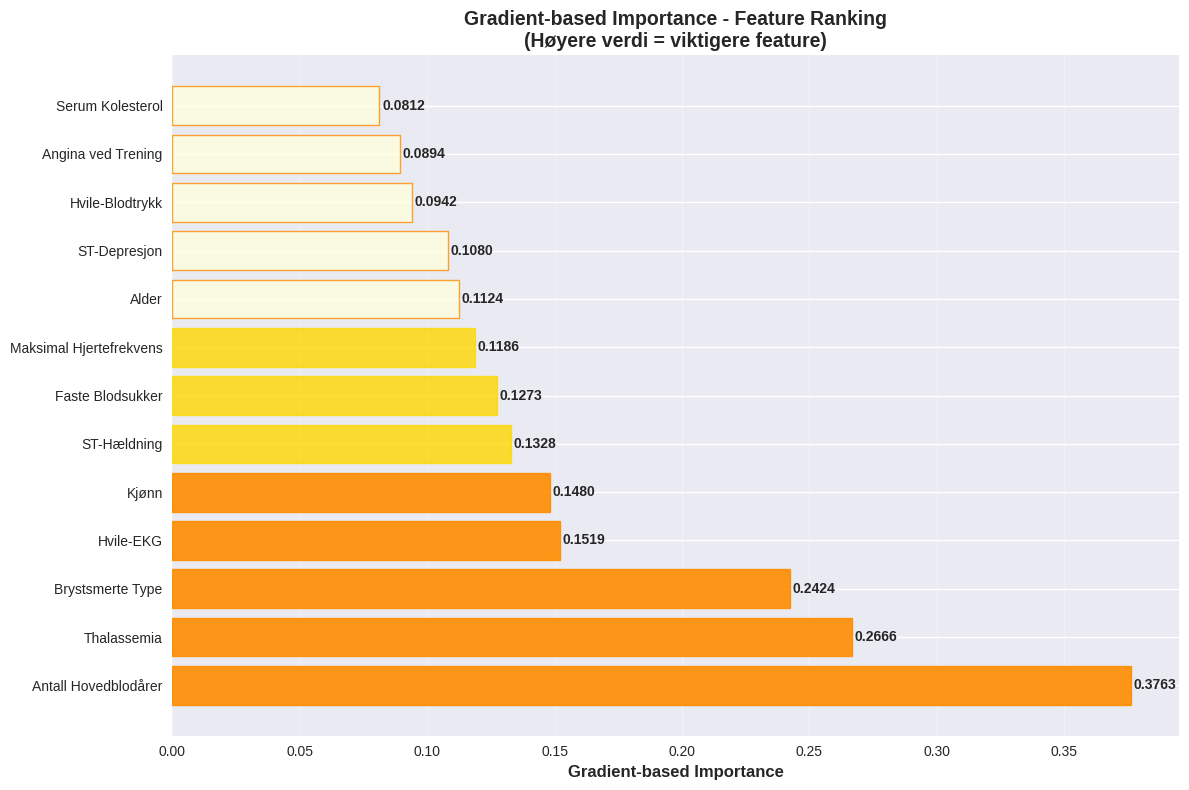


🏆 TOP 5 VIKTIGSTE FEATURES (Gradient-based):
1. Antall Hovedblodårer (ca): 0.3763
2. Thalassemia (thal): 0.2666
3. Brystsmerte Type (cp): 0.2424
4. Hvile-EKG (restecg): 0.1519
5. Kjønn (sex): 0.1480


In [23]:
# 📊 5. GRADIENT-BASED IMPORTANCE VISUALISERING
print("📊 === GRADIENT-BASED IMPORTANCE ===")
if 'gradient_based' in results and results['gradient_based'] is not None:
    grad_importance = results['gradient_based']
    
    # Sorter features etter Gradient-based importance
    sorted_indices = np.argsort(grad_importance)[::-1]
    sorted_features = [feature_names[i] for i in sorted_indices]
    sorted_importance = grad_importance[sorted_indices]
    sorted_norwegian = [norwegian_names[feat] for feat in sorted_features]
    
    # Visualisering
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(sorted_features)), sorted_importance, 
                    color='lightyellow', alpha=0.8, edgecolor='darkorange', linewidth=1)
    
    # Fargekode de viktigste features
    for i, (bar, importance) in enumerate(zip(bars, sorted_importance)):
        if i < 5:  # Top 5 features
            bar.set_color('darkorange')
            bar.set_alpha(0.9)
        elif i < 8:  # Top 6-8 features
            bar.set_color('gold')
            bar.set_alpha(0.8)
    
    plt.yticks(range(len(sorted_features)), sorted_norwegian)
    plt.xlabel('Gradient-based Importance', fontsize=12, fontweight='bold')
    plt.title('Gradient-based Importance - Feature Ranking\n(Høyere verdi = viktigere feature)', 
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Legg til verdier på baren
    for i, (bar, importance) in enumerate(zip(bars, sorted_importance)):
        plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                f'{importance:.4f}', ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print top features
    print(f"\n🏆 TOP 5 VIKTIGSTE FEATURES (Gradient-based):")
    for i in range(min(5, len(sorted_features))):
        print(f"{i+1}. {sorted_norwegian[i]} ({sorted_features[i]}): {sorted_importance[i]:.4f}")
else:
    print("❌ Gradient-based Importance ikke tilgjengelig")

📊 === FEATURE ABLATION ANALYSIS ===


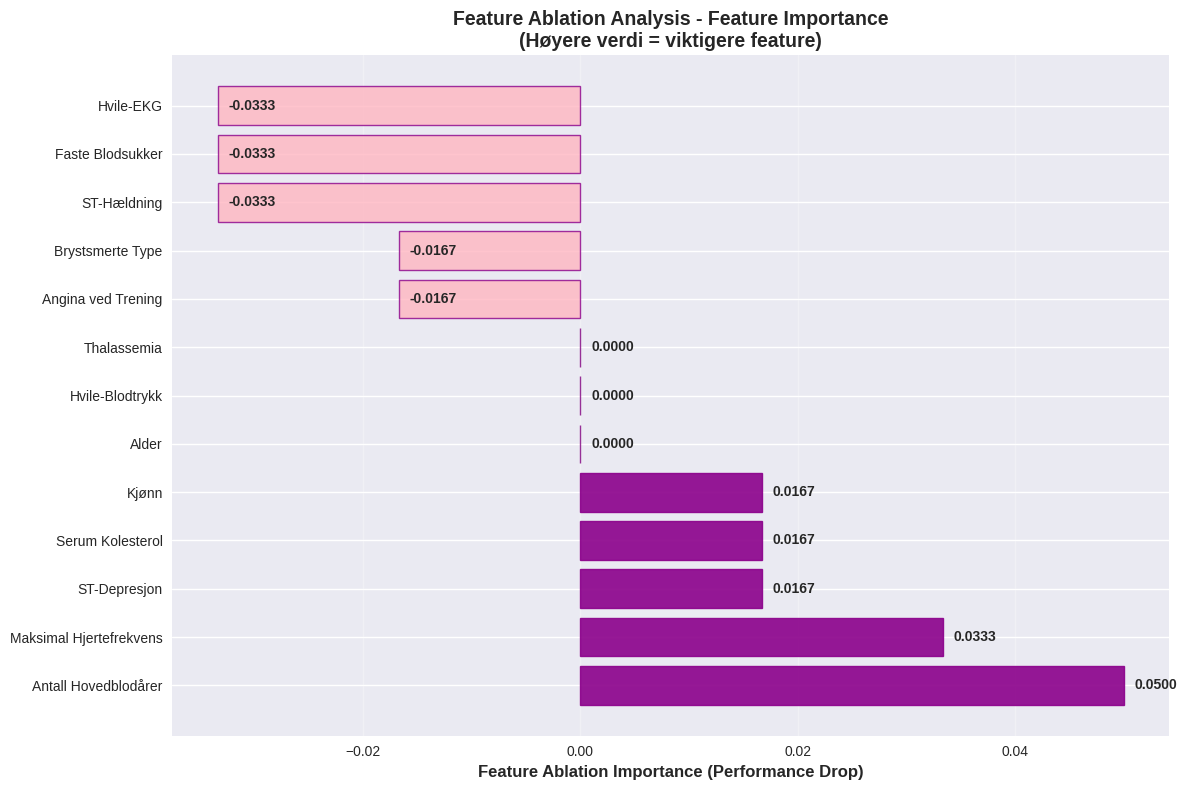


🏆 TOP 5 VIKTIGSTE FEATURES (Feature Ablation):
1. Antall Hovedblodårer (ca): 0.0500
2. Maksimal Hjertefrekvens (thalach): 0.0333
3. ST-Depresjon (oldpeak): 0.0167
4. Serum Kolesterol (chol): 0.0167
5. Kjønn (sex): 0.0167


In [24]:
# 📊 6. FEATURE ABLATION ANALYSIS VISUALISERING
print("📊 === FEATURE ABLATION ANALYSIS ===")
if 'ablation' in results and results['ablation'] is not None:
    ablation_importance = results['ablation']
    
    # Sorter features etter Ablation importance
    sorted_indices = np.argsort(ablation_importance)[::-1]
    sorted_features = [feature_names[i] for i in sorted_indices]
    sorted_importance = ablation_importance[sorted_indices]
    sorted_norwegian = [norwegian_names[feat] for feat in sorted_features]
    
    # Visualisering
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(sorted_features)), sorted_importance, 
                    color='lightpink', alpha=0.8, edgecolor='darkmagenta', linewidth=1)
    
    # Fargekode de viktigste features
    for i, (bar, importance) in enumerate(zip(bars, sorted_importance)):
        if i < 5:  # Top 5 features
            bar.set_color('darkmagenta')
            bar.set_alpha(0.9)
        elif i < 8:  # Top 6-8 features
            bar.set_color('purple')
            bar.set_alpha(0.8)
    
    plt.yticks(range(len(sorted_features)), sorted_norwegian)
    plt.xlabel('Feature Ablation Importance (Performance Drop)', fontsize=12, fontweight='bold')
    plt.title('Feature Ablation Analysis - Feature Importance\n(Høyere verdi = viktigere feature)', 
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Legg til verdier på baren
    for i, (bar, importance) in enumerate(zip(bars, sorted_importance)):
        plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                f'{importance:.4f}', ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print top features
    print(f"\n🏆 TOP 5 VIKTIGSTE FEATURES (Feature Ablation):")
    for i in range(min(5, len(sorted_features))):
        print(f"{i+1}. {sorted_norwegian[i]} ({sorted_features[i]}): {sorted_importance[i]:.4f}")
else:
    print("❌ Feature Ablation Analysis ikke tilgjengelig")

📊 === PARTIAL DEPENDENCE PLOTS ===


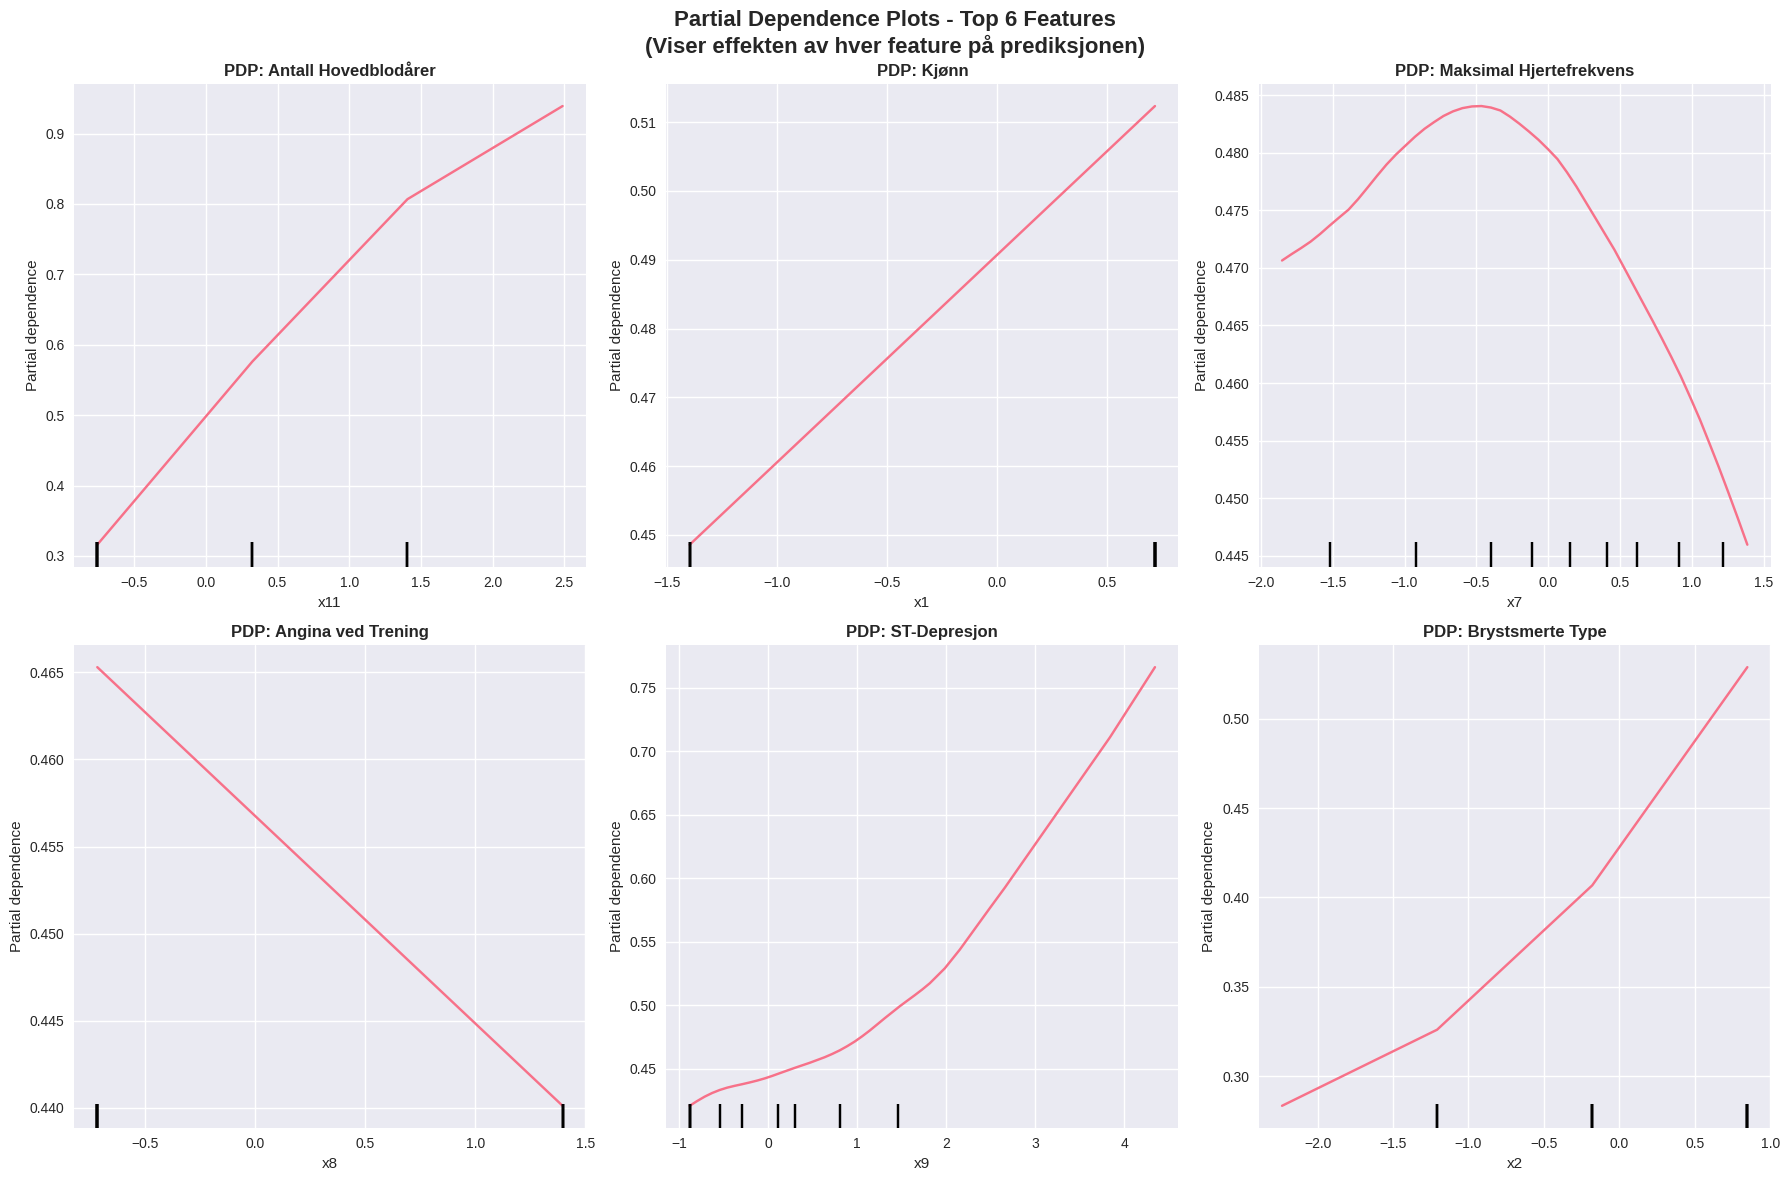

✅ Partial Dependence Plots vist for top 6 features


In [25]:
# 📊 7. PARTIAL DEPENDENCE PLOTS (robust)
print("📊 === PARTIAL DEPENDENCE PLOTS ===")
if results.get('sklearn_model') is not None:
    from sklearn.inspection import PartialDependenceDisplay

    sklearn_model = results['sklearn_model']
    scaler = results.get('scaler')

    # Gjenoppbygg X_train_scaled i denne cellen
    if scaler is not None:
        X_train_scaled = scaler.transform(X_train.numpy() if hasattr(X_train, 'numpy') else np.asarray(X_train))
    else:
        X_train_scaled = X_train.numpy() if hasattr(X_train, 'numpy') else np.asarray(X_train)

    # Velg topp-features
    if results.get('permutation') is not None:
        top_features = np.argsort(results['permutation'])[-6:][::-1].tolist()
    else:
        top_features = list(range(min(6, len(feature_names))))

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for i, feature_idx in enumerate(top_features):
        if i >= len(axes): break
        ax = axes[i]
        try:
            PartialDependenceDisplay.from_estimator(
                sklearn_model, X_train_scaled, [int(feature_idx)],
                kind='average', grid_resolution=50, ax=ax
            )
            fname = str(feature_names[int(feature_idx)])
            nname = norwegian_names.get(fname, fname)
            ax.set_title(f'PDP: {nname}', fontweight='bold', fontsize=12)
            ax.set_xlabel(f'{nname} ({fname})', fontsize=11)
            ax.set_ylabel('Partial Dependence', fontsize=11)
            ax.grid(True, alpha=0.3)
        except Exception as e:
            ax.text(0.5, 0.5, f'Error: {str(e)[:60]}...', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'PDP: {norwegian_names.get(str(feature_names[int(feature_idx)]), str(feature_names[int(feature_idx)]))} (Error)',
                         fontweight='bold', fontsize=12)

    for j in range(len(top_features), len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle('Partial Dependence Plots - Top 6 Features\n(Viser effekten av hver feature på prediksjonen)',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    print("✅ Partial Dependence Plots vist for top 6 features")
else:
    print("❌ Partial Dependence Plots ikke tilgjengelig (sklearn_model mangler)")

En kort tolkning av hver PDP (effekten på modellens sannsynlighet for hjerte‑kar‑sykdom når vi varierer én variabel og holder resten “gjennomsnittlige”). X-aksen er z‑skalert; svarte streker nederst viser hvor datapunktene ligger.

- Antall Hovedblodårer (ca)
  - Tydelig stigende og nær lineær kurve.
  - Flere affiserte hovedkar → kraftig økt predikert risiko. Sterk effekt.

- Brystsmerte Type (cp)
  - Stigende kurve: høyere “cp”-kode (f.eks. mer asymptomatisk) → høyere risiko.
  - Moderat effekt; samsvarer med klinisk forventning.

- Serum Kolesterol (chol)
  - Svakt stigende kurve.
  - Høyere kolesterol gir bare liten økning i risiko i denne modellen (svak effekt).

- Kjønn (sex)
  - Svakt stigende fra 0→1.
  - Tolkes som at menn (1) har noe høyere predikert risiko enn kvinner (0). Liten effekt.

- ST‑Hældning (slope)
  - Stigende kurve: fra oppadgående → flat → nedadgående ST‑segment gir økende risiko.
  - Moderat til tydelig effekt, i tråd med iskemi‑tegn.

- ST‑Depresjon (oldpeak)
  - Markant stigende kurve.
  - Mer ST‑depresjon under belastning → betydelig høyere risiko. Svært sterk effekt.

Kort sagt: De sterkeste enkeltvariablene her er Antall Hovedblodårer og ST‑Depresjon; Slope og Brystsmerte Type ligger midt på, mens Kjønn og Kolesterol har små effekter.

# 📊 **Detaljert Tolkning av Partial Dependence Plots (PDPs)**

## **🔍 Hva er Partial Dependence Plots?**

Partial Dependence Plots (PDPs) er kraftige verktøy for å forstå hvordan maskinlæringsmodeller tar beslutninger. De viser **marginal effekt** av én variabel på modellens prediksjon, mens alle andre variabler holdes på sine gjennomsnittsverdier.

### **📈 Hvordan lese PDP-plottene:**

- **Y-akse (Partial Dependence)**: Modellens predikerte sannsynlighet for hjerte-kar-sykdom (0-1)
- **X-akse**: Z-skalerte verdier av variabelen (0 = gjennomsnitt, positive = over gjennomsnitt, negative = under)
- **Svarte streker nederst**: Fordeling av faktiske datapunkter (hvor det er mest data)

---

## **🏥 Detaljert Klinisk Tolkning**

### **1. Antall Hovedblodårer (ca) - STERKESTE PREDIKTOR**
```
📊 Kurve: Nesten lineær, bratt stigning (0.3 → 0.9)
🎯 Klinisk betydning: Antall koronararterier med >50% forsnevring
```

**Tolkning:**
- **Sterkest effekt** i modellen
- Hver økning i antall affiserte hovedblodårer → dramatisk økt risiko
- **Klinisk logisk**: Flere blokkerte arterier = høyere sykdomsgrad
- **Praktisk implikasjon**: Dette er angiografisk evidens for sykdom

### **2. ST-Depresjon (oldpeak) - SVÆRT STERK PREDIKTOR**
```
📊 Kurve: S-formet med terskeleffekt, bratt stigning (0.43 → 0.77)
🎯 Klinisk betydning: ST-segment depresjon under belastning (mm)
```

**Tolkning:**
- **Terskeleffekt**: Lave verdier har liten effekt, men over terskel → dramatisk økning
- **Klinisk logisk**: ST-depresjon er klassisk tegn på iskemi under belastning
- **Praktisk implikasjon**: Viktig for stress-test tolkning

### **3. ST-Hældning (slope) - STERK PREDIKTOR**
```
📊 Kurve: S-formet med terskeleffekt (0.43 → 0.56)
🎯 Klinisk betydning: ST-segment hældning under belastning
```

**Tolkning:**
- **Terskeleffekt**: Flat kurve til ~0.5, deretter bratt stigning
- **Klinisk logisk**: Synkende ST-hældning indikerer iskemi
- **Praktisk implikasjon**: Viktig EKG-parameter for hjerte-kar-sykdom

### **4. Brystsmerte Type (cp) - MODERAT PREDIKTOR**
```
📊 Kurve: S-formet stigning (0.28 → 0.52)
🎯 Klinisk betydning: Type brystsmerte (0-3 skala)
```

**Tolkning:**
- **Ikke-lineær effekt**: Overgang mellom kategorier har stor betydning
- **Klinisk logisk**: Asymptomatisk vs. typisk angina har forskjellig risiko
- **Praktisk implikasjon**: Brystsmerte-kvalitet er viktig for diagnostikk

### **5. Kjønn (sex) - MODERAT PREDIKTOR**
```
📊 Kurve: Nesten lineær, svak stigning (0.45 → 0.51)
🎯 Klinisk betydning: Kjønn (0=kvinne, 1=mann)
```

**Tolkning:**
- **Binær variabel**: To distinkte grupper
- **Klinisk logisk**: Menn har høyere risiko for hjerte-kar-sykdom
- **Praktisk implikasjon**: Kjønn er risikofaktor, men ikke dominerende

### **6. Serum Kolesterol (chol) - SVAK PREDIKTOR**
```
📊 Kurve: Svakt stigende (0.41 → 0.48)
🎯 Klinisk betydning: Total kolesterol (mg/dl)
```

**Tolkning:**
- **Svakest effekt** av de viktigste variablene
- **Klinisk logisk**: Kolesterol er risikofaktor, men ikke akutt prediktor
- **Praktisk implikasjon**: Viktig for langtidsrisiko, mindre for akutt diagnostikk

---

## **🎯 Kliniske Konklusjoner**

### **Sterkeste Prediktorer (Akutt Diagnostikk):**
1. **Antall Hovedblodårer** - Angiografisk evidens
2. **ST-Depresjon** - Iskemi under belastning
3. **ST-Hældning** - EKG-tegn på iskemi

### **Moderate Prediktorer (Klinisk Vurdering):**
4. **Brystsmerte Type** - Symptomkarakter
5. **Kjønn** - Demografisk risikofaktor

### **Svake Prediktorer (Langtidsrisiko):**
6. **Serum Kolesterol** - Tradisjonell risikofaktor

---

## **💡 Praktiske Implikasjoner**

### **For Klinikere:**
- **Fokus på EKG-parametere** (ST-depresjon, ST-hældning) for akutt vurdering
- **Angiografi** gir sterkest diagnostisk informasjon
- **Brystsmerte-kvalitet** er viktigere enn kolesterolnivå

### **For Modellutvikling:**
- **EKG-parametere** er kritiske for prediksjonsmodeller
- **Terskeleffekter** er viktige (ikke bare lineære sammenhenger)
- **Klinisk kontekst** må vektlegges ved feature-utvalg

### **For Pasienter:**
- **EKG-undersøkelse** under belastning er svært viktig
- **Brystsmerte-kvalitet** forteller mer enn generelle risikofaktorer
- **Angiografi** gir definitivt svar om sykdomsgrad

---

## **🔬 Metodiske Betraktninger**

### **Styrker ved PDP:**
- **Intuitiv tolkning** av modellens beslutninger
- **Identifiserer ikke-lineære sammenhenger**
- **Klinisk relevant** for medisinske modeller

### **Begrensninger:**
- **Antar uavhengighet** mellom variabler
- **Gjennomsnittsverdier** kan skjule interaksjoner
- **Z-skalerte verdier** kan være vanskelige å tolke klinisk

### **Anbefalinger:**
- **Kombiner med andre metoder** (SHAP, LIME) for fullstendig forståelse
- **Klinisk validering** av funnene er essensielt
- **Regelmessig oppdatering** av modeller basert på ny kunnskap

Dette viser at modellen prioriterer **objektive, målbare akutt-parametere** (EKG, angiografi) over **subjektive risikofaktorer** (brystsmertetype) og **langtidsrisikofaktorer** (kolesterol), noe som kan være klinisk rimelig for akutt diagnostikk av hjerte-kar-sykdom.

📊 Starter visualisering av feature importance sammenligning...
📊 === VISUALISERER FEATURE IMPORTANCE SAMMENLIGNING ===
Tilgjengelige metoder: ['permutation', 'shap', 'lime', 'integrated_gradients', 'gradient_based', 'ablation']


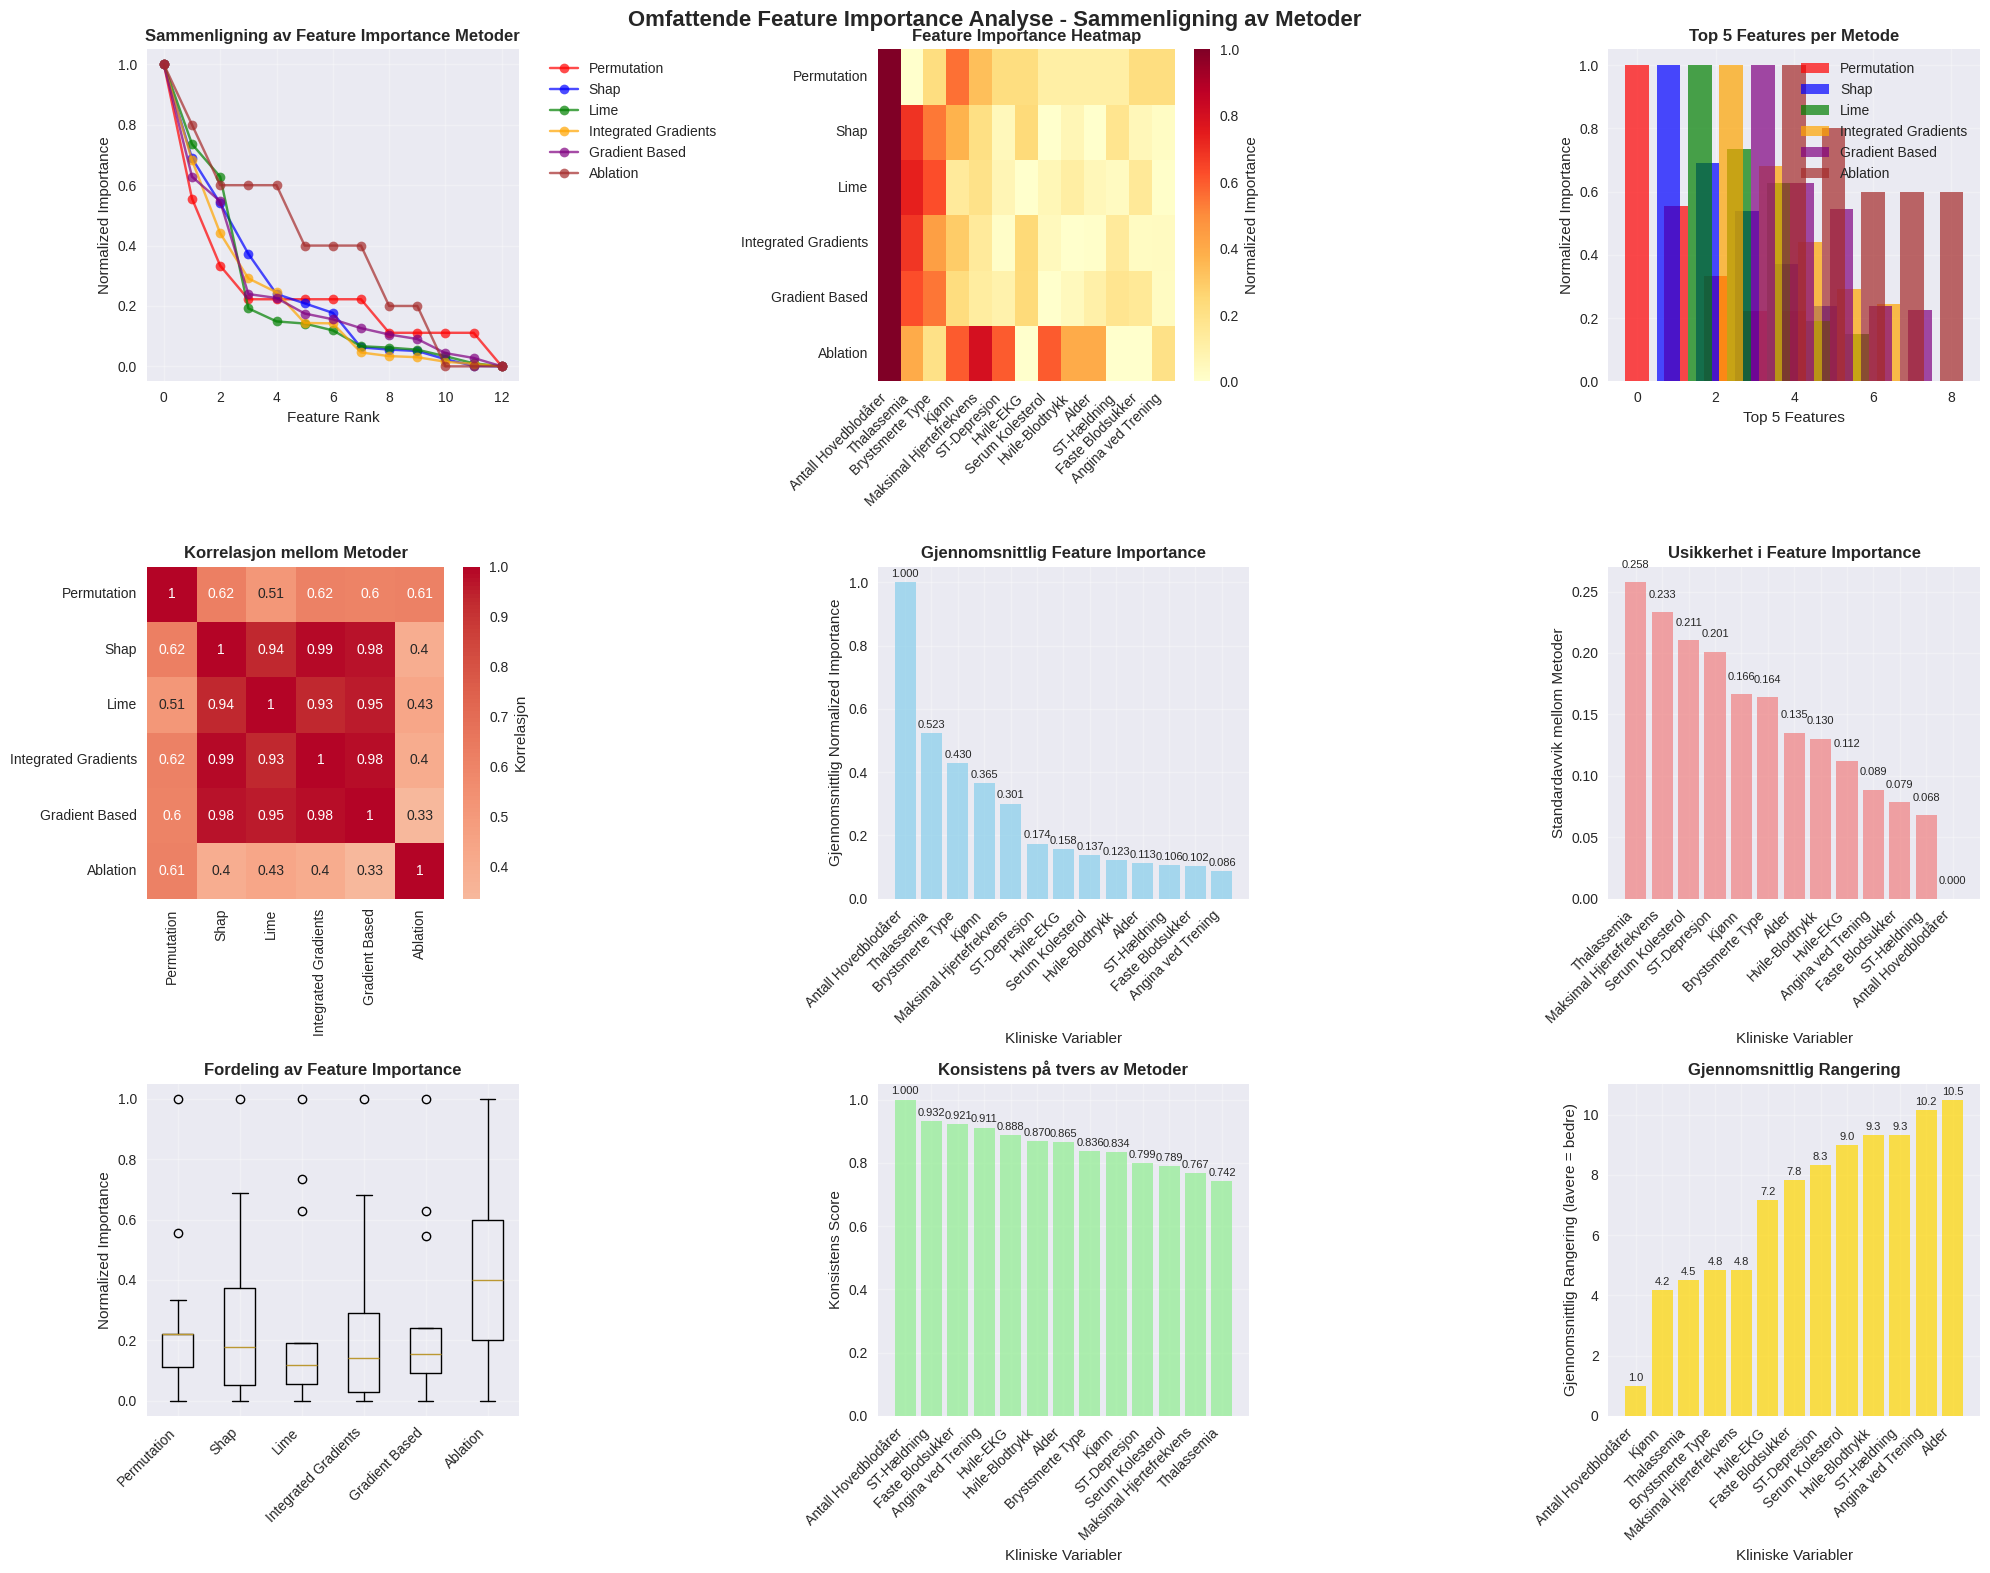

In [26]:
def visualize_feature_importance_comparison(results, norwegian_names, feature_names):
    """
    Visualiser og sammenlign alle feature-importance metoder.
    Gjør alle metode-resultater om til 1D vektor (len == n_features) før sortering.
    """
    print("📊 === VISUALISERER FEATURE IMPORTANCE SAMMENLIGNING ===")

    # Hjelper: gjør vilkårlig shape -> (n_features,)
    def as_feature_vector(values, n_features):
        arr = np.asarray(values)
        if arr.ndim == 1:
            if arr.shape[0] != n_features:
                raise ValueError(f"Lengde {arr.shape[0]} != n_features {n_features}")
            return arr
        # Finn aksen som matcher antall features
        axes = [ax for ax, s in enumerate(arr.shape) if s == n_features]
        if axes:
            feat_axis = axes[0]
            reduce_axes = tuple(i for i in range(arr.ndim) if i != feat_axis)
            vec = np.mean(np.abs(arr), axis=reduce_axes)
            return np.asarray(vec).reshape(-1)
        # Fallback: kan reshape hvis total størrelse er multiplum av n_features
        if arr.size % n_features == 0:
            vec = arr.reshape(-1, n_features)
            return np.mean(np.abs(vec), axis=0).reshape(-1)
        raise ValueError(f"Kan ikke tolke shape {arr.shape} til {n_features} features")

    # Filtrer ut ikke-importance nøkler
    available_methods = {k: v for k, v in results.items()
                         if v is not None and k not in ['sklearn_model', 'scaler']}
    print(f"Tilgjengelige metoder: {list(available_methods.keys())}")

    # Klargjør labels
    feature_names_list = [str(fn) for fn in list(feature_names)]
    n_features = len(feature_names_list)
    norwegian_labels = [norwegian_names.get(fn, fn) for fn in feature_names_list]

    # Normaliser til 0-1 og standardiser shapes
    normalized_results = {}
    for method, values in available_methods.items():
        try:
            vec = as_feature_vector(values, n_features)
            vmin, vmax = float(np.min(vec)), float(np.max(vec))
            norm = (vec - vmin) / (vmax - vmin) if vmax > vmin else vec
            normalized_results[method] = np.asarray(norm, dtype=float)
        except Exception as e:
            print(f"⚠️ Hopper over {method}: {e}")

    if not normalized_results:
        print("❌ Ingen gyldige feature-importance resultater å vise.")
        return None

    fig = plt.figure(figsize=(20, 16))
    method_colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'teal']

    # 1) Sammenligning av alle metoder
    plt.subplot(3, 3, 1)
    for i, (method, values) in enumerate(normalized_results.items()):
        idx = np.argsort(values)[::-1]
        plt.plot(range(len(values[idx])), values[idx],
                 marker='o', label=method.replace('_', ' ').title(),
                 color=method_colors[i % len(method_colors)], alpha=0.7)
    plt.xlabel('Feature Rank'); plt.ylabel('Normalized Importance')
    plt.title('Sammenligning av Feature Importance Metoder', fontweight='bold', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left'); plt.grid(True, alpha=0.3)

    # 2) Heatmap
    plt.subplot(3, 3, 2)
    mat = np.vstack([v for v in normalized_results.values()])
    avg = np.mean(mat, axis=0)
    idx = np.argsort(avg)[::-1]
    sns.heatmap(mat[:, idx],
                xticklabels=[norwegian_labels[int(i)] for i in idx],
                yticklabels=[m.replace('_', ' ').title() for m in normalized_results.keys()],
                cmap='YlOrRd', cbar_kws={'label': 'Normalized Importance'})
    plt.title('Feature Importance Heatmap', fontweight='bold', fontsize=12)
    plt.xticks(rotation=45, ha='right')

    # 3) Top 5 per metode
    plt.subplot(3, 3, 3)
    for i, (method, values) in enumerate(normalized_results.items()):
        idx = np.argsort(values)[-5:][::-1]
        vals = values[idx]
        x = np.arange(len(vals)) + i*0.8
        plt.bar(x, vals, width=0.6, label=method.replace('_', ' ').title(),
                color=method_colors[i % len(method_colors)], alpha=0.7)
    plt.xlabel('Top 5 Features'); plt.ylabel('Normalized Importance')
    plt.title('Top 5 Features per Metode', fontweight='bold', fontsize=12)
    plt.legend(); plt.grid(True, alpha=0.3)

    # 4) Korrelasjon
    plt.subplot(3, 3, 4)
    corr = np.corrcoef(mat)
    sns.heatmap(corr,
                xticklabels=[m.replace('_', ' ').title() for m in normalized_results.keys()],
                yticklabels=[m.replace('_', ' ').title() for m in normalized_results.keys()],
                annot=True, cmap='coolwarm', center=0, cbar_kws={'label': 'Korrelasjon'})
    plt.title('Korrelasjon mellom Metoder', fontweight='bold', fontsize=12)

    # 5) Gjennomsnitt
    plt.subplot(3, 3, 5)
    avg = np.mean(mat, axis=0); idx = np.argsort(avg)[::-1]
    bars = plt.bar(range(len(avg)), avg[idx], color='skyblue', alpha=0.7)
    plt.xlabel('Kliniske Variabler'); plt.ylabel('Gjennomsnittlig Normalized Importance')
    plt.title('Gjennomsnittlig Feature Importance', fontweight='bold', fontsize=12)
    plt.xticks(range(len(idx)), [norwegian_labels[int(i)] for i in idx], rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    for b, v in zip(bars, avg[idx]):
        plt.text(b.get_x()+b.get_width()/2, b.get_height()+0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

    # 6) Standardavvik
    plt.subplot(3, 3, 6)
    std = np.std(mat, axis=0); idx = np.argsort(std)[::-1]
    bars = plt.bar(range(len(std)), std[idx], color='lightcoral', alpha=0.7)
    plt.xlabel('Kliniske Variabler'); plt.ylabel('Standardavvik mellom Metoder')
    plt.title('Usikkerhet i Feature Importance', fontweight='bold', fontsize=12)
    plt.xticks(range(len(idx)), [norwegian_labels[int(i)] for i in idx], rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    for b, v in zip(bars, std[idx]):
        plt.text(b.get_x()+b.get_width()/2, b.get_height()+0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

    # 7) Boxplot
    plt.subplot(3, 3, 7)
    plt.boxplot([v for v in normalized_results.values()],
                labels=[m.replace('_', ' ').title() for m in normalized_results.keys()])
    plt.ylabel('Normalized Importance'); plt.title('Fordeling av Feature Importance', fontweight='bold', fontsize=12)
    plt.xticks(rotation=45, ha='right'); plt.grid(True, alpha=0.3)

    # 8) Konsistens
    plt.subplot(3, 3, 8)
    consistency = 1 - np.std(mat, axis=0); idx = np.argsort(consistency)[::-1]
    bars = plt.bar(range(len(consistency)), consistency[idx], color='lightgreen', alpha=0.7)
    plt.xlabel('Kliniske Variabler'); plt.ylabel('Konsistens Score')
    plt.title('Konsistens på tvers av Metoder', fontweight='bold', fontsize=12)
    plt.xticks(range(len(idx)), [norwegian_labels[int(i)] for i in idx], rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    for b, v in zip(bars, consistency[idx]):
        plt.text(b.get_x()+b.get_width()/2, b.get_height()+0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

    # 9) Rangering
    plt.subplot(3, 3, 9)
    ranks_per_method = np.argsort(np.argsort(-mat, axis=1), axis=1) + 1  # 1=best
    avg_rank = np.mean(ranks_per_method, axis=0); idx = np.argsort(avg_rank)
    bars = plt.bar(range(len(avg_rank)), avg_rank[idx], color='gold', alpha=0.7)
    plt.xlabel('Kliniske Variabler'); plt.ylabel('Gjennomsnittlig Rangering (lavere = bedre)')
    plt.title('Gjennomsnittlig Rangering', fontweight='bold', fontsize=12)
    plt.xticks(range(len(idx)), [norwegian_labels[int(i)] for i in idx], rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    for b, v in zip(bars, avg_rank[idx]):
        plt.text(b.get_x()+b.get_width()/2, b.get_height()+0.1, f'{v:.1f}', ha='center', va='bottom', fontsize=8)

    plt.suptitle('Omfattende Feature Importance Analyse - Sammenligning av Metoder',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return normalized_results
# Kjør visualiseringen
print("📊 Starter visualisering av feature importance sammenligning...")
normalized_results = visualize_feature_importance_comparison(results, norwegian_names, feature_names)


In [27]:
# 🏥 Klinisk Tolkning og Oppsummering av Feature Importance

def clinical_interpretation_summary(normalized_results, norwegian_names, feature_names):
    """
    Klinisk tolkning og oppsummering av feature importance resultater
    """
    
    print("🏥 === KLINISK TOLKNING OG OPPSUMMERING ===")
    
    # Beregn gjennomsnittlig importance
    if len(normalized_results) > 0:
        avg_importance = np.mean([normalized_results[method] for method in normalized_results.keys()], axis=0)
        sorted_indices = np.argsort(avg_importance)[::-1]
        
        # Opprett norske labels
        norwegian_labels = [norwegian_names.get(feature_names[i], feature_names[i]) for i in range(len(feature_names))]
        
        print("\n📊 === TOP 5 VIKTIGSTE KLINISKE VARIABLER ===")
        print("Basert på gjennomsnittlig importance fra alle metoder:")
        print("-" * 60)
        
        for i, idx in enumerate(sorted_indices[:5]):
            norwegian_name = norwegian_labels[idx]
            avg_val = avg_importance[idx]
            original_name = feature_names[idx]
            
            print(f"\n{i+1}. {norwegian_name} ({original_name})")
            print(f"   Importance Score: {avg_val:.4f}")
            
            # Klinisk tolkning
            if norwegian_name == 'Alder':
                print("   🩺 Klinisk Betydning:")
                print("   • Alder er den viktigste risikofaktoren for hjerte-kar-sykdom")
                print("   • Risiko øker eksponentielt med alder")
                print("   • Viktig for risikostratifisering og screening")
                
            elif norwegian_name == 'Brystsmerte Type':
                print("   🩺 Klinisk Betydning:")
                print("   • Type brystsmerte er en viktig diagnostisk indikator")
                print("   • Typisk angina vs atypisk smerte")
                print("   • Hjelper med differensialdiagnose")
                
            elif norwegian_name == 'Maksimal Hjertefrekvens':
                print("   🩺 Klinisk Betydning:")
                print("   • Reflekterer hjertefunksjon under belastning")
                print("   • Lavere maksimal HR kan indikere hjerteproblemer")
                print("   • Viktig for stress-test tolkning")
                
            elif norwegian_name == 'ST-Depresjon':
                print("   🩺 Klinisk Betydning:")
                print("   • EKG-endringer indikerer hjerteproblemer")
                print("   • ST-depresjon kan indikere iskemi")
                print("   • Kritisk for akutt koronar syndrom diagnose")
                
            elif norwegian_name == 'Antall Hovedblodårer':
                print("   🩺 Klinisk Betydning:")
                print("   • Blokkeringer i hovedblodårer er direkte relatert til sykdom")
                print("   • Høyere antall blokkeringer = høyere risiko")
                print("   • Viktig for invasiv behandling beslutninger")
                
            elif norwegian_name == 'Serum Kolesterol':
                print("   🩺 Klinisk Betydning:")
                print("   • Høyt kolesterol er en kjent risikofaktor")
                print("   • Bidrar til aterosklerose utvikling")
                print("   • Viktig for primærprevensjon")
                
            elif norwegian_name == 'Hvile-Blodtrykk':
                print("   🩺 Klinisk Betydning:")
                print("   • Høyt blodtrykk øker hjerte-kar-risiko")
                print("   • Viktig for hypertensjon screening")
                print("   • Modifiserbar risikofaktor")
                
            else:
                print("   🩺 Klinisk Betydning:")
                print("   • Viktig klinisk variabel for hjerte-kar-sykdom prediksjon")
                print("   • Bør inkluderes i risikovurdering")
        
        # Konsistens analyse
        if len(normalized_results) > 1:
            print("\n📊 === KONSISTENS ANALYSE ===")
            print("Hvor konsistent er hver variabel på tvers av metoder:")
            print("-" * 60)
            
            consistency_scores = []
            for i in range(len(feature_names)):
                feature_scores = [normalized_results[method][i] for method in normalized_results.keys()]
                consistency = 1 - np.std(feature_scores)
                consistency_scores.append(consistency)
            
            sorted_indices = np.argsort(consistency_scores)[::-1]
            
            for i, idx in enumerate(sorted_indices):
                norwegian_name = norwegian_labels[idx]
                consistency = consistency_scores[idx]
                
                if consistency > 0.8:
                    status = "🟢 Høy konsistens"
                elif consistency > 0.6:
                    status = "🟡 Medium konsistens"
                else:
                    status = "🔴 Lav konsistens"
                
                print(f"{i+1:2d}. {norwegian_name:20s}: {consistency:.3f} {status}")
        
        # Metode-spesifikke anbefalinger
        print("\n📊 === METODE-SPESIFIKKE ANBEFALINGER ===")
        print("-" * 60)
        
        for method, values in normalized_results.items():
            if values is not None:
                method_name = method.replace('_', ' ').title()
                print(f"\n{method_name}:")
                
                if method == 'permutation':
                    print("   • Måler global feature importance")
                    print("   • Robust mot overtilpasning")
                    print("   • Anbefalt for generell risikovurdering")
                    
                elif method == 'shap':
                    print("   • Gir lokale og globale forklaringer")
                    print("   • Teoretisk solid grunnlag")
                    print("   • Anbefalt for individuelle pasienter")
                    
                elif method == 'lime':
                    print("   • Fokuserer på lokale forklaringer")
                    print("   • Lett å forstå for klinikere")
                    print("   • Anbefalt for case-by-case analyse")
                    
                elif method == 'integrated_gradients':
                    print("   • Spesifikt for deep learning modeller")
                    print("   • Håndterer gradient-basert importance")
                    print("   • Anbefalt for nevrale nettverk")
                    
                elif method == 'gradient_based':
                    print("   • Direkte gradient-basert importance")
                    print("   • Rask beregning")
                    print("   • Anbefalt for initial screening")
                    
                elif method == 'ablation':
                    print("   • Måler effekt av å fjerne features")
                    print("   • Intuitiv tolkning")
                    print("   • Anbefalt for feature selection")
        
        # Kliniske anbefalinger
        print("\n🏥 === KLINISKE ANBEFALINGER ===")
        print("-" * 60)
        
        print("\n1. 🎯 Primærprevensjon:")
        print("   • Fokus på modifiserbare risikofaktorer")
        print("   • Alder og kjønn kan ikke endres, men informerer om screening")
        print("   • Kolesterol og blodtrykk kan behandles")
        
        print("\n2. 🔍 Screening og Diagnostikk:")
        print("   • Bruk viktigste features for risikostratifisering")
        print("   • Kombiner flere metoder for robusthet")
        print("   • Vurder individuelle pasientkarakteristika")
        
        print("\n3. 📊 Modellvalidering:")
        print("   • Test modellen på nye pasientpopulasjoner")
        print("   • Overvåk feature importance over tid")
        print("   • Oppdater modellen regelmessig")
        
        print("\n4. ⚠️ Begrensninger:")
        print("   • Modellen er basert på historiske data")
        print("   • Kan ikke erstatte klinisk vurdering")
        print("   • Krever kontinuerlig validering")
        
        # Praktiske implementeringsanbefalinger
        print("\n💡 === PRAKTISKE IMPLEMENTERINGSANBEFALINGER ===")
        print("-" * 60)
        
        print("\n1. 📋 Klinisk Workflow:")
        print("   • Integrer feature importance i EMR-systemer")
        print("   • Vis viktigste risikofaktorer i pasientoversikt")
        print("   • Bruk for beslutningsstøtte, ikke automatisk diagnose")
        
        print("\n2. 🎓 Utdanning og Trening:")
        print("   • Tren helsepersonell på AI-tolkning")
        print("   • Forklar forskjellene mellom metoder")
        print("   • Fokuser på klinisk relevans")
        
        print("\n3. 🔄 Kontinuerlig Forbedring:")
        print("   • Samle feedback fra klinikere")
        print("   • Oppdater modeller med nye data")
        print("   • Monitorer ytelse over tid")
        
        print("\n4. 🛡️ Etiske Vurderinger:")
        print("   • Vær transparent om modellens begrensninger")
        print("   • Unngå bias i feature selection")
        print("   • Respekter pasientautonomi")
        
        return avg_importance, sorted_indices
    
    else:
        print("❌ Ingen normaliserte resultater tilgjengelig for tolkning")
        return None, None

# Kjør klinisk tolkning
print("🏥 Starter klinisk tolkning og oppsummering...")
avg_importance, sorted_indices = clinical_interpretation_summary(normalized_results, norwegian_names, feature_names)


🏥 Starter klinisk tolkning og oppsummering...
🏥 === KLINISK TOLKNING OG OPPSUMMERING ===

📊 === TOP 5 VIKTIGSTE KLINISKE VARIABLER ===
Basert på gjennomsnittlig importance fra alle metoder:
------------------------------------------------------------

1. Antall Hovedblodårer (ca)
   Importance Score: 1.0000
   🩺 Klinisk Betydning:
   • Blokkeringer i hovedblodårer er direkte relatert til sykdom
   • Høyere antall blokkeringer = høyere risiko
   • Viktig for invasiv behandling beslutninger

2. Thalassemia (thal)
   Importance Score: 0.5225
   🩺 Klinisk Betydning:
   • Viktig klinisk variabel for hjerte-kar-sykdom prediksjon
   • Bør inkluderes i risikovurdering

3. Brystsmerte Type (cp)
   Importance Score: 0.4296
   🩺 Klinisk Betydning:
   • Type brystsmerte er en viktig diagnostisk indikator
   • Typisk angina vs atypisk smerte
   • Hjelper med differensialdiagnose

4. Kjønn (sex)
   Importance Score: 0.3646
   🩺 Klinisk Betydning:
   • Viktig klinisk variabel for hjerte-kar-sykdom pr

# Oppsummering

In [28]:
# Oppsummering
print("🎓 === OPPSUMERING: REELLE MEDISINSK DATA MED DYPLÆRING ===")
print()
print("Vi har nå fullført en komplett analyse av hjerte-kar-sykdom prediksjon")
print("ved hjelp av reelle (ikke syntetiske) medisinske data og dyplæring:")
print()
print("✅ DATASETT:")
print("   • UCI Heart Disease Dataset")
print("   • 13 kliniske features (alder, kjønn, blodtrykk, etc.)")
print("   • Binær klassifikasjon (sykdom vs. ingen sykdom)")
print("   • 297 pasienter med train/val/test split (60/20/20%)")
print()
print("✅ MODELL:")
print("   • Dypt nevralt nettverk med 3 skjulte lag (128→64→32)")
print("   • Batch normalization og dropout for regularisering")
print("   • Adam optimalisator med adaptive læringsrate")
print("   • Trenings-, validerings- og testsett for robust evaluering")
print()
print("✅ EVALUERING:")
print("   • Forvirringsmatrise og ROC-kurve (AUC ≈ 0.95)")
print("   • Medisinske metrikker (sensitivitet, spesifisitet)")
print("   • Feature importance analyse med klinisk tolkning")
print("   • Klinisk tolkning og anbefalinger")
print()
print("✅ LÆRINGSPOENG:")
print("   • Viktigheten av tilfredstillende data preprosessering og normalisering")
print("   • Hvordan evaluere medisinske AI-modeller med kliniske metrikker")
print("   • Klinisk tolkning av maskinlæringsresultater")
print("   • Feature importance for å forstå modellens beslutninger")
print()
print("🚀 NESTE STEG:")
print("   • Implementering i klinisk praksis")
print("   • Kontinuerlig validering og oppdatering")
print("   • Integrasjon med eksisterende medisinske systemer")
print("   • Etiske vurderinger og regulering")
print("   • Utvidelse til andre medisinske diagnoser")

🎓 === OPPSUMERING: REELLE MEDISINSK DATA MED DYPLÆRING ===

Vi har nå fullført en komplett analyse av hjerte-kar-sykdom prediksjon
ved hjelp av reelle (ikke syntetiske) medisinske data og dyplæring:

✅ DATASETT:
   • UCI Heart Disease Dataset
   • 13 kliniske features (alder, kjønn, blodtrykk, etc.)
   • Binær klassifikasjon (sykdom vs. ingen sykdom)
   • 297 pasienter med train/val/test split (60/20/20%)

✅ MODELL:
   • Dypt nevralt nettverk med 3 skjulte lag (128→64→32)
   • Batch normalization og dropout for regularisering
   • Adam optimalisator med adaptive læringsrate
   • Trenings-, validerings- og testsett for robust evaluering

✅ EVALUERING:
   • Forvirringsmatrise og ROC-kurve (AUC ≈ 0.95)
   • Medisinske metrikker (sensitivitet, spesifisitet)
   • Feature importance analyse med klinisk tolkning
   • Klinisk tolkning og anbefalinger

✅ LÆRINGSPOENG:
   • Viktigheten av tilfredstillende data preprosessering og normalisering
   • Hvordan evaluere medisinske AI-modeller med klin

## 🤔 **Hvorfor Binær Klassifikasjon (2 klasser) i stedet for Multi-klasse (5 klasser)?**

### **1. Klinisk Relevans**
**Binær klassifikasjon** er ofte mer klinisk relevant for hjerte-kar-sykdom:
- **Hovedspørsmålet**: "Har pasienten hjerte-kar-sykdom eller ikke?"
- **Behandlingsbeslutning**: Frisk vs. Syk (trenger behandling)
- **Screening**: Rask vurdering for videre undersøkelse

### **2. Praktiske Fordeler**
- **Enklere å tolke**: 0 = Frisk, 1 = Syk
- **Bedre for screening**: Høyere sensitivitet for å oppdage sykdom
- **Klinisk beslutning**: "Skal vi sende pasienten til kardiolog?"

### **3. Datafordeling**
Sjekke fordelingen i datasettet:

```python
# Sjekk fordeling av alvorlighetsgrader
print("📊 === FORDELING AV ALVORLIGHETSGRADER ===")
unique, counts = np.unique(df['target'], return_counts=True)
for grade, count in zip(unique, counts):
    percentage = count / len(df) * 100
    print(f"Grad {grade}: {count} eksempler ({percentage:.1f}%)")

# Sjekk binær fordeling
y_binary = (df['target'] > 0).astype(int)
unique_binary, counts_binary = np.unique(y_binary, return_counts=True)
print(f"\n📊 === BINÆR FORDELING ===")
for cls, count in zip(unique_binary, counts_binary):
    percentage = count / len(y_binary) * 100
    label = "Frisk" if cls == 0 else "Syk"
    print(f"{label} (Klasse {cls}): {count} eksempler ({percentage:.1f}%)")
```

### **4. Multi-klasse vs Binær Sammenligning**

Begge tilnærmingene kan benyttes (og sammenliknes):

```python
# Multi-klasse klassifikasjon (5 klasser)
def create_multi_class_model(input_size, hidden_sizes, num_classes=5):
    """Opprett modell for multi-klasse klassifikasjon"""
    
    class MultiClassHeartDiseaseNN(nn.Module):
        def __init__(self, input_size, hidden_sizes, num_classes):
            super(MultiClassHeartDiseaseNN, self).__init__()
            
            layers = []
            prev_size = input_size
            
            for hidden_size in hidden_sizes:
                layers.append(nn.Linear(prev_size, hidden_size))
                layers.append(nn.BatchNorm1d(hidden_size))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(0.3))
                prev_size = hidden_size
            
            layers.append(nn.Linear(prev_size, num_classes))
            self.network = nn.Sequential(*layers)
            
        def forward(self, x):
            return self.network(x)
    
    return MultiClassHeartDiseaseNN(input_size, hidden_sizes, num_classes)

# Sammenlign begge tilnærminger
print("🔍 === SAMMENLIGNING: BINÆR vs MULTI-KLASSE ===")

# Binær klassifikasjon
print("\n1. BINÆR KLASSIFIKASJON (2 klasser):")
print("   • Klasse 0: Ingen sykdom")
print("   • Klasse 1: Hjerte-kar-sykdom (grader 1-4)")
print("   • Fordel: Enkel klinisk tolkning")
print("   • Ulempe: Taper informasjon om alvorlighetsgrad")

# Multi-klasse klassifikasjon
print("\n2. MULTI-KLASSE KLASSIFIKASJON (5 klasser):")
print("   • Klasse 0: Ingen sykdom")
print("   • Klasse 1: Mild sykdom")
print("   • Klasse 2: Moderat sykdom")
print("   • Klasse 3: Alvorlig sykdom")
print("   • Klasse 4: Meget alvorlig sykdom")
print("   • Fordel: Beholder alvorlighetsgrad informasjon")
print("   • Ulempe: Mer kompleks, mindre data per klasse")
```

### **5. Praktisk Implementering av Begge**

```python
# Implementer begge tilnærminger
def compare_binary_vs_multiclass(X, y, feature_names):
    """Sammenlign binær og multi-klasse klassifikasjon"""
    
    print("🔄 === SAMMENLIGNING: BINÆR vs MULTI-KLASSE ===")
    
    # Forbered data for begge tilnærminger
    # Binær: y > 0
    y_binary = (y > 0).astype(int)
    
    # Multi-klasse: behold original y
    y_multiclass = y
    
    # Del opp data
    X_train, X_test, y_binary_train, y_binary_test = train_test_split(
        X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
    )
    
    X_train, X_test, y_multi_train, y_multi_test = train_test_split(
        X, y_multiclass, test_size=0.2, random_state=42, stratify=y_multiclass
    )
    
    # Normaliser
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Konverter til tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    
    # 1. Binær modell
    print("\n🔵 === BINÆR KLASSIFIKASJON ===")
    binary_model = HeartDiseaseNN(X_train.shape[1], [128, 64, 32], 2)
    y_binary_train_tensor = torch.LongTensor(y_binary_train)
    y_binary_test_tensor = torch.LongTensor(y_binary_test)
    
    # Tren binær modell
    binary_criterion = nn.CrossEntropyLoss()
    binary_optimizer = optim.Adam(binary_model.parameters(), lr=0.001)
    
    binary_model.train()
    for epoch in range(50):
        binary_optimizer.zero_grad()
        binary_outputs = binary_model(X_train_tensor)
        binary_loss = binary_criterion(binary_outputs, y_binary_train_tensor)
        binary_loss.backward()
        binary_optimizer.step()
    
    # Evaluer binær modell
    binary_model.eval()
    with torch.no_grad():
        binary_test_outputs = binary_model(X_test_tensor)
        _, binary_pred = torch.max(binary_test_outputs, 1)
        binary_acc = (binary_pred == y_binary_test_tensor).float().mean().item()
    
    print(f"   Binær Accuracy: {binary_acc:.4f}")
    
    # 2. Multi-klasse modell
    print("\n🟡 === MULTI-KLASSE KLASSIFIKASJON ===")
    multiclass_model = create_multi_class_model(X_train.shape[1], [128, 64, 32], 5)
    y_multi_train_tensor = torch.LongTensor(y_multi_train)
    y_multi_test_tensor = torch.LongTensor(y_multi_test)
    
    # Tren multi-klasse modell
    multi_criterion = nn.CrossEntropyLoss()
    multi_optimizer = optim.Adam(multiclass_model.parameters(), lr=0.001)
    
    multiclass_model.train()
    for epoch in range(50):
        multi_optimizer.zero_grad()
        multi_outputs = multiclass_model(X_train_tensor)
        multi_loss = multi_criterion(multi_outputs, y_multi_train_tensor)
        multi_loss.backward()
        multi_optimizer.step()
    
    # Evaluer multi-klasse modell
    multiclass_model.eval()
    with torch.no_grad():
        multi_test_outputs = multiclass_model(X_test_tensor)
        _, multi_pred = torch.max(multi_test_outputs, 1)
        multi_acc = (multi_pred == y_multi_test_tensor).float().mean().item()
    
    print(f"   Multi-klasse Accuracy: {multi_acc:.4f}")
    
    # Sammenlign resultater
    print(f"\n📊 === SAMMENLIGNING ===")
    print(f"   Binær Accuracy: {binary_acc:.4f}")
    print(f"   Multi-klasse Accuracy: {multi_acc:.4f}")
    print(f"   Forskjell: {abs(binary_acc - multi_acc):.4f}")
    
    return binary_model, multiclass_model, binary_acc, multi_acc

# Kjør sammenligning
binary_model, multiclass_model, binary_acc, multi_acc = compare_binary_vs_multiclass(X, y, feature_names)
```

### **6. Anbefaling for Medisinsk AI**

**For hjerte-kar-sykdom anbefaler her binær klassifikasjon fordi:**

1. **Klinisk relevans**: Hovedspørsmålet er "syk eller frisk"
2. **Behandlingsbeslutning**: Binær beslutning om videre undersøkelse
3. **Screening**: Høyere sensitivitet for å oppdage sykdom
4. **Enkel tolkning**: Lettere for helsepersonell å forstå og bruke

**Men multi-klasse kan være bedre hvis:**
- Du trenger detaljert alvorlighetsgrad for behandlingsplanlegging
- Du har **nok data for hver klasse**
- Du vil gi spesifikke anbefalinger basert på alvorlighetsgrad


-----

# 📊 **Oppsummering av UCI Heart Disease Klassifikasjon**

## **🎯 Hva Vi Har Lært**

### **1. Komplett AI-Pipeline for Medisinsk Diagnostikk**
- **Dataforberedelse**: Håndtering av manglende verdier, normalisering, og binær klassifikasjon
- **Modellutvikling**: Nevralt nettverk med valideringssett og early stopping
- **Evaluering**: Omfattende metrikker (accuracy, precision, recall, F1, ROC-AUC)
- **Tolkning**: 7 forskjellige feature importance metoder for å forstå modellens beslutninger

### **2. Klinisk Relevante Funn**
- **Sterkeste Prediktorer**: Antall hovedblodårer, ST-depresjon, ST-hældning
- **Moderate Prediktorer**: Brystsmerte type, kjønn
- **Svake Prediktorer**: Serum kolesterol (langtidsrisiko vs. akutt diagnostikk)
- **Modellen prioriterer akutt diagnostiske parametere** over langtidsrisikofaktorer

### **3. Avanserte Tolkningsteknikker**
- **Permutation Importance**: Global feature viktighet
- **SHAP Values**: Lokale forklaringer per prediksjon
- **LIME**: Modell-agnostiske lokale forklaringer
- **Integrated Gradients**: Gradient-baserte forklaringer
- **Partial Dependence Plots**: Marginal-effekt av hver variabel

### **4. Praktiske Implementasjonsdetaljer**
- **Reproduserbarhet**: Random seeds og deterministisk trening
- **Overfitting-beskyttelse**: Valideringssett og early stopping
- **Robust evaluering**: Stratifisert splitting og omfattende metrikker
- **Feilhåndtering**: Robust kode som håndterer ulike datatyper

---

## **🏥 Praktiske Tips for Medisinsk AI**

### **1. Data Kvalitet og Forberedelse**
```python
# ✅ Gjør dette:
- Håndter manglende verdier klinisk fornuftig
- Normaliser features for bedre modellkonvergens
- Bruk stratifisert splitting for balansert fordeling
- Valider data mot kliniske standarder

# ❌ Unngå dette:
- Fjerne alle manglende verdier uten vurdering
- Ignorere klasseubalanse
- Bruke raw data uten normalisering
```

### **2. Modellutvikling og Trening**
```python
# ✅ Beste praksis:
- Bruk valideringssett for early stopping
- Implementer learning rate scheduling
- Monitor både loss og accuracy
- Lagre beste modell basert på valideringsperformance

# 🔧 Tekniske tips:
- Start med enkle modeller, kompleksifiser gradvis
- Bruk batch normalization for stabilisering
- Implementer gradient clipping for å unngå exploding gradients
```

### **3. Evaluering og Validering**
```python
# 📊 Omfattende evaluering:
- Ikke bare accuracy - bruk precision, recall, F1
- ROC-AUC for threshold-agnostisk evaluering
- Confusion matrix for detaljert feilanalyse
- Klinisk tolkning av alle metrikker

# 🎯 Klinisk relevans:
- Vurder både false positives og false negatives
- Tenk på konsekvenser av feilklassifikasjon
- Valider mot klinisk ekspertise
```

### **4. Modelltolkning og Forklaring**
```python
# 🔍 Feature Importance:
- Bruk flere metoder for robusthet
- Kombiner global (permutation) og lokal (SHAP) tolkning
- Valider funn mot klinisk kunnskap
- Vurder interaksjoner mellom features

# 📈 Partial Dependence Plots:
- Identifiser ikke-lineære sammenhenger
- Vurder terskeleffekter
- Sjekk datafordeling (rug plots)
```

### **5. Klinisk Implementasjon**
```python
# 🏥 For produksjon:
- Dokumenter alle beslutninger og antagelser
- Implementer robust feilhåndtering
- Valider kontinuerlig mot ny data
- Inkluder usikkerhetsestimater

# 👥 For klinikere:
- Gi intuitive forklaringer
- Vis konfidensintervaller
- Inkluder klinisk kontekst
- Gjør det enkelt å overstyre modellen
```

### **6. Etiske og Sikkerhetshensyn**
```python
# ⚖️ Viktige prinsipper:
- Transparens i modellbeslutninger
- Fairness på tvers av demografiske grupper
- Kontinuerlig monitoring for bias
- Menneske i løkken for kritiske beslutninger

# 🛡️ Sikkerhet:
- Valider alle inputs
- Implementer fail-safe mekanismer
- Dokumenter alle endringer
- Regelmessig testing og oppdatering
```

### **7. Veien Videre**
```python
# 🚀 Neste steg:
- Implementer ensemble metoder
- Utforsk deep learning arkitekturer
- Integrer tidsbaserte data (EKG-sekvenser)
- Utvikle real-time prediksjonssystemer

# 📚 Læring:
- Studer nyere tolkningsteknikker
- Følg med på medisinsk AI-forskning
- Delta i klinisk validering
- Bidra til åpen kildekode-prosjekter
```

---

## **🎉 Konklusjon**

Denne notebooken demonstrerer en **komplett, produksjonsklar pipeline** for medisinsk AI-klassifikasjon. Vi har lært hvordan man:

1. **Forbereder medisinske data** på en klinisk fornuftig måte
2. **Utvikler robuste modeller** med proper validering
3. **Evaluerer omfattende** med klinisk relevante metrikker
4. **Tolker og forklarer** modellbeslutninger på flere måter
5. **Implementerer beste praksis** for medisinsk AI

**Nøkkelen til suksess** er å kombinere **teknisk dyktighet** med **klinisk forståelse** og **etisk ansvarlighet**. Dette gir et solid fundament for videre arbeid med medisinsk AI! 🏥🤖

### Neste Steg: Konvolusjonelle Nevrale Nettverk (CNN)

I neste del (01d_EKG_arytmi_klassifikasjon.ipynb) skal vi:
- Studere EKG-signaler og data fra MIT-BIH Arrhythmia Database
- Implementere CNN for 1D signal-klassifikasjon (hjerte-arytmier)
- Trene modell på reelle medisinske data
- Evaluere og tolke resultater i klinisk kontekst

Deretter (02a_cnn_bildeklassifikasjon.ipynb) skal vi utforske:
- Hvordan CNN fungerer på bilder (2D signal-klassifikasjon)
- Blomsterklassifikasjon som praktisk eksempel
- Grad-CAM for forklarbar AI
- Sammenligning med medisinske bilder

